In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as tf
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torchvision.models.vgg as vgg

import gc

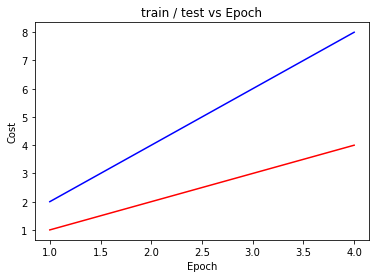

In [2]:
plt.plot([1,2,3,4], [1,2,3,4], 'r', label='train')
plt.plot([1,2,3,4], [2,4,6,8], 'b', label='test')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('train / test vs Epoch')
plt.show()


In [3]:
stat1 = torch.Tensor([0.5071, 0.4865, 0.4409])
stat2 = torch.Tensor([0.2009, 0.1984, 0.2023])
stats = stat1, stat2
stats

(tensor([0.5071, 0.4865, 0.4409]), tensor([0.2009, 0.1984, 0.2023]))

In [4]:
train_transforms = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.RandomCrop(32, padding=4, padding_mode='reflect'),
    tf.ToTensor(),
    tf.Normalize(*stats, inplace=True)
])

test_transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(*stats)
])

In [5]:
train_data = CIFAR100(download=True, train=True, root="../data", transform=train_transforms)
test_data = CIFAR100(download=True, train=False, root='../data', transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


<h4><u><b> for data_loader image check </h4>

<h3><u><b><i>model : ResNet

In [6]:
import torchvision.models.resnet as resnet

conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [7]:
class ResNet(nn.Module):
    # model = ResNet(Bottleneck, [3, 4, 6, 3], 100, true) #resnet 50 
    def __init__(self, block, initial_conv, layers, channels, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
                
        #input = 3x32x32
        self.conv1 = nn.Conv2d(3, initial_conv, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.inplanes = initial_conv #make_layers에서 사용함! // 순서상 여기가 맞는 듯..ㅎㅎ


        self.bn1 = nn.BatchNorm2d(initial_conv)
        self.relu = nn.ReLU(inplace=True)
        
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))

        # self.block_list = nn.Sequential()
        # for i in range(len(layers)):
        #     self.block_list.add_module("dense_block_lalyer_{}".format(i), self._make_layer(block, channels[i], layers[i]))

        self.layer1 = self._make_layer(block, channels[0], layers[0])
        self.layer2 = self._make_layer(block, channels[1], layers[1])
        self.layer3 = self._make_layer(block, channels[2], layers[2])
        # self.layer4 = self._make_layer(block, channels[3], layers[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[-1] * block.expansion, num_classes) #Linear(2048(layer4's nb_output_channel), num_classes)
    
        # weight initialization!
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    

    def _make_layer(self, block, planes, blocks, stride=1):
        
        downsample = None
        
    
        if stride != 1 or self.inplanes != planes * block.expansion: 
            
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), 
                nn.BatchNorm2d(planes * block.expansion), 
            )

        layers = [] 
        layers.append(block(self.inplanes, planes, stride, downsample)) 
        
        
        self.inplanes = planes * block.expansion 
        
        for _ in range(1, blocks): 
            layers.append(block(self.inplanes, planes)) 
            
            
        
        return nn.Sequential(*layers)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        #x = self.block_list(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

testing model(success)

In [8]:
try_model = ResNet(Bottleneck, 16, [3,4,6], [64,128,256], 100, True)
test_tensor = torch.randn([1,3,32,32])
try_model(test_tensor)
# li = '|'.join(map(str, [1,2,3]))
# print(li, type(li))

tensor([[ 0.2784, -0.1374,  0.3571,  0.1032, -0.0635, -0.1014,  0.2117, -0.2788,
         -0.1347,  0.1176,  0.0494,  0.2943,  0.1631, -0.0857,  0.0167, -0.1485,
          0.1164,  0.0409,  0.2655,  0.1475,  0.0855,  0.0553,  0.3226,  0.1877,
         -0.2737,  0.0361,  0.1050,  0.1567,  0.1873,  0.1050,  0.0492,  0.0938,
          0.1101,  0.0549,  0.3139,  0.0869, -0.1396,  0.1628, -0.5247,  0.1589,
          0.2855,  0.0430, -0.0375,  0.1986, -0.1579, -0.1262, -0.0009,  0.4196,
         -0.1013,  0.1584,  0.0158, -0.0948,  0.0813,  0.3560, -0.2707, -0.4653,
         -0.0987,  0.1581, -0.1850,  0.2543,  0.0612,  0.2005, -0.0849,  0.0366,
          0.0454,  0.4418,  0.3255, -0.1155,  0.3907,  0.2151,  0.3033, -0.0847,
         -0.3249, -0.2238,  0.1969, -0.1456, -0.2788, -0.2573, -0.1024, -0.0805,
          0.0403,  0.0245,  0.1416,  0.0431, -0.0335, -0.0720, -0.0504,  0.2493,
         -0.0527, -0.0746, -0.0566,  0.1281,  0.0679,  0.0122,  0.1497,  0.2932,
         -0.1048, -0.0530,  

In [9]:
def train_model(_model, _epoch, _train_data_loader, _optimizer, _lr_sche,  _creterion, _array_cost, _array_accu, _array_lr):
    train_cost_sum = 0
    corrects = 0
    len_data = len(_train_data_loader)
    print('----------------train----------------')
    for batch_idx, data in enumerate(_train_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        _optimizer.zero_grad()
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = creterion(prediction, y)
        cost.backward()
        _optimizer.step()
        _lr_sche.step()
        _array_lr.append(get_lr(_optimizer))

        train_cost_sum += cost.item()
        if (batch_idx + 1) % (len_data/3) == 0:
            train_cost_avg = train_cost_sum / (batch_idx + 1)
            print('Epoch:{:2d}/{} batch_idx:{:3d} Train Cost:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, train_cost_avg))
    
    accuracy = (corrects / len(train_data))*100
    print('Epoch:{:2d}/{} batch_idx:{:3d} Train Accuracy:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, accuracy))
    _array_cost.append(train_cost_sum/len(_train_data_loader))
    _array_accu.append(accuracy)
        

In [10]:
def test_model(_model, _epoch, _test_data_loader, _creterion, _array_cost, _array_accu):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        
        #corrects_tenser = (prediction.argmax(1) == y)
        #print('corrects shape', corrects_tenser.shape)
        
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(_test_data_loader)

    accuracy = (corrects / len(test_data)) * 100
    print('Epoch:{:2d}/{} Test Cost:{:2.6f} Test Accuracy:{:.4f}'
            .format(_epoch, TRAIN_EPOCHS, test_cost_avg, accuracy))
    _array_cost.append(test_cost_avg)
    _array_accu.append(accuracy)

    return test_cost_avg, accuracy

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
BATCH_SIZE = 160
train_data_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

In [13]:
print('train data set shape', len(train_data))
print('test data set shape', len(test_data))

for data in train_data_loader:
    x, y = data
    print('x shape', x.shape)
    print('y shape', y.shape)

    break
train_iteration = len(train_data)/BATCH_SIZE

print('data_loader length', len(train_data_loader))

train data set shape 50000
test data set shape 10000
x shape torch.Size([160, 3, 32, 32])
y shape torch.Size([160])
data_loader length 312


----------------train----------------
Epoch: 1/100 batch_idx:103 Train Cost:4.416906
Epoch: 1/100 batch_idx:207 Train Cost:4.282898
Epoch: 1/100 batch_idx:311 Train Cost:4.199140
Epoch: 1/100 batch_idx:311 Train Accuracy:7.054000
----------------test----------------
Epoch: 1/100 Test Cost:3.991479 Test Accuracy:9.5700


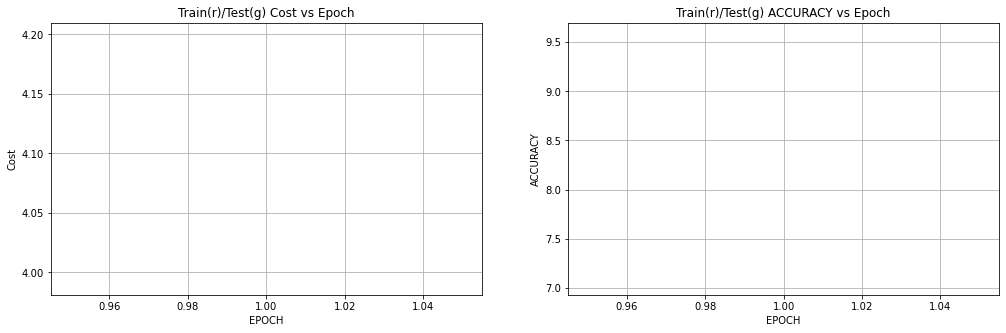

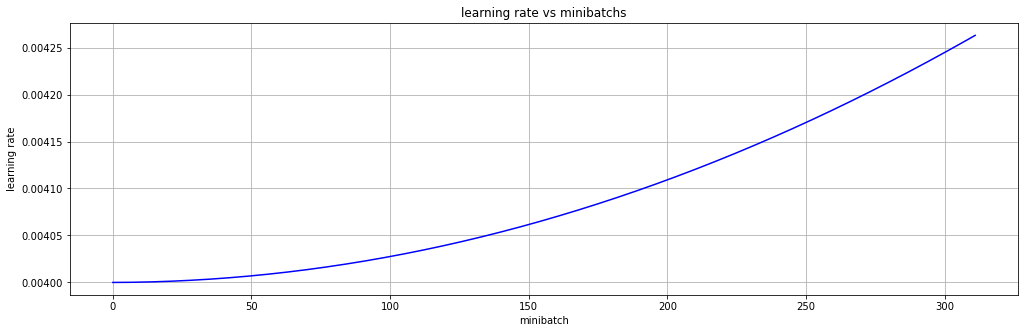

----------------train----------------
Epoch: 2/100 batch_idx:103 Train Cost:3.968441
Epoch: 2/100 batch_idx:207 Train Cost:3.954286
Epoch: 2/100 batch_idx:311 Train Cost:3.940892
Epoch: 2/100 batch_idx:311 Train Accuracy:10.200000
----------------test----------------
Epoch: 2/100 Test Cost:3.880279 Test Accuracy:11.2800


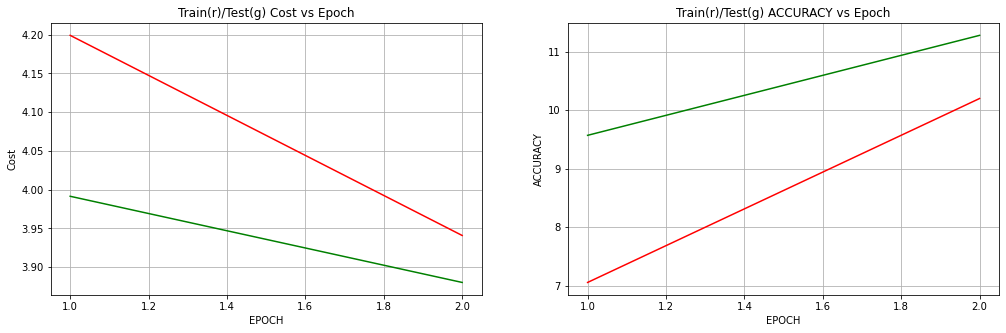

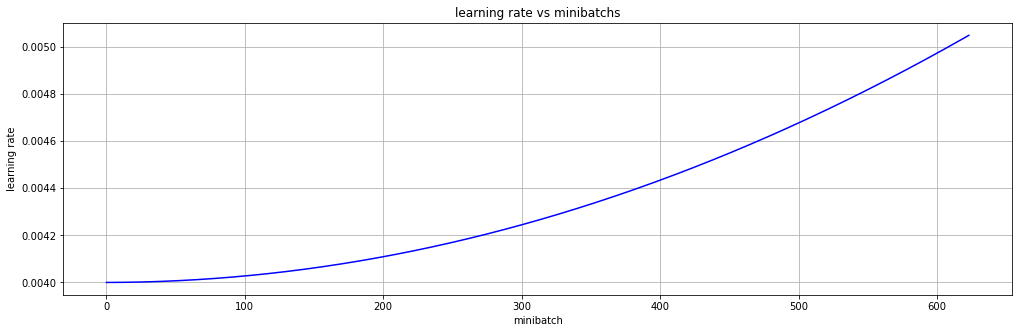

----------------train----------------
Epoch: 3/100 batch_idx:103 Train Cost:3.867453
Epoch: 3/100 batch_idx:207 Train Cost:3.853618
Epoch: 3/100 batch_idx:311 Train Cost:3.839556
Epoch: 3/100 batch_idx:311 Train Accuracy:11.612000
----------------test----------------
Epoch: 3/100 Test Cost:3.780998 Test Accuracy:12.7500


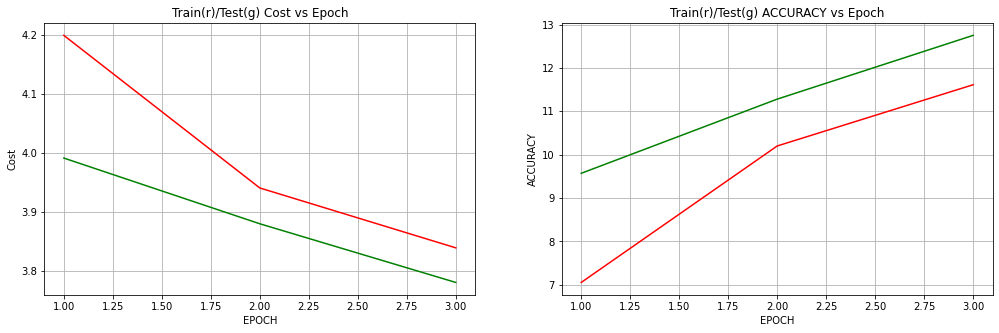

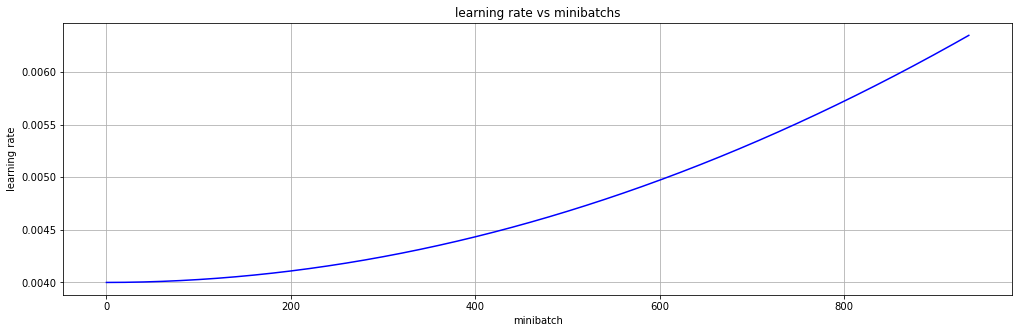

----------------train----------------
Epoch: 4/100 batch_idx:103 Train Cost:3.754199
Epoch: 4/100 batch_idx:207 Train Cost:3.735739
Epoch: 4/100 batch_idx:311 Train Cost:3.720816
Epoch: 4/100 batch_idx:311 Train Accuracy:13.466000
----------------test----------------
Epoch: 4/100 Test Cost:3.641485 Test Accuracy:14.2300


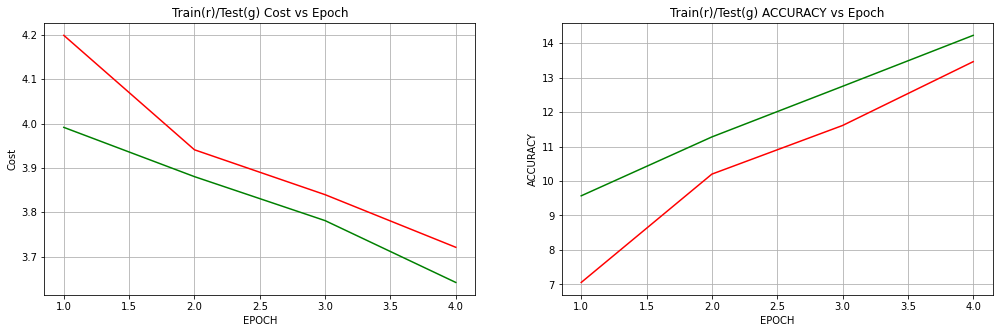

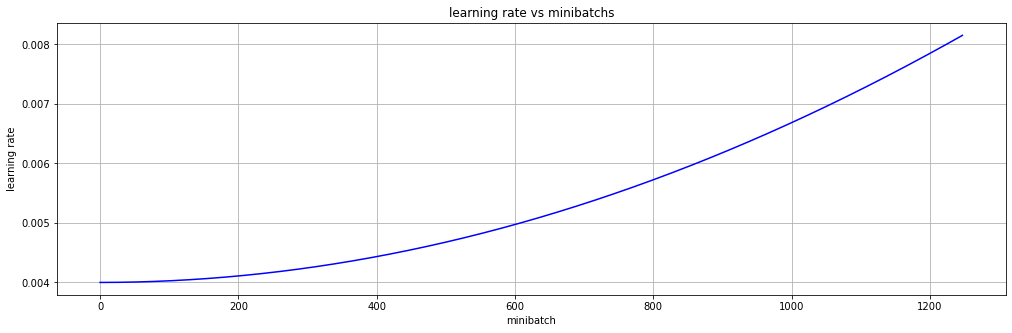

----------------train----------------
Epoch: 5/100 batch_idx:103 Train Cost:3.610566
Epoch: 5/100 batch_idx:207 Train Cost:3.601215
Epoch: 5/100 batch_idx:311 Train Cost:3.577563
Epoch: 5/100 batch_idx:311 Train Accuracy:15.656000
----------------test----------------
Epoch: 5/100 Test Cost:3.534452 Test Accuracy:15.8900


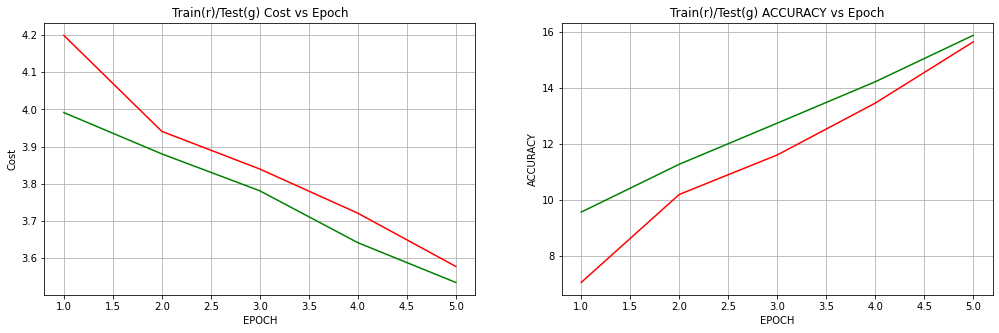

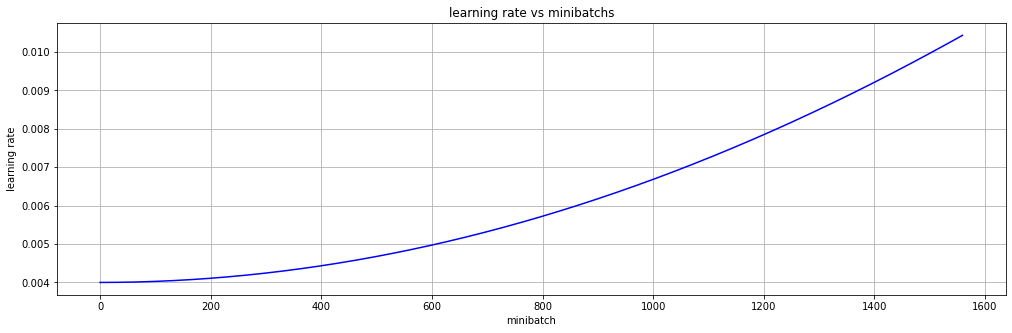

----------------train----------------
Epoch: 6/100 batch_idx:103 Train Cost:3.466130
Epoch: 6/100 batch_idx:207 Train Cost:3.440573
Epoch: 6/100 batch_idx:311 Train Cost:3.412948
Epoch: 6/100 batch_idx:311 Train Accuracy:18.250000
----------------test----------------
Epoch: 6/100 Test Cost:3.345303 Test Accuracy:20.2000


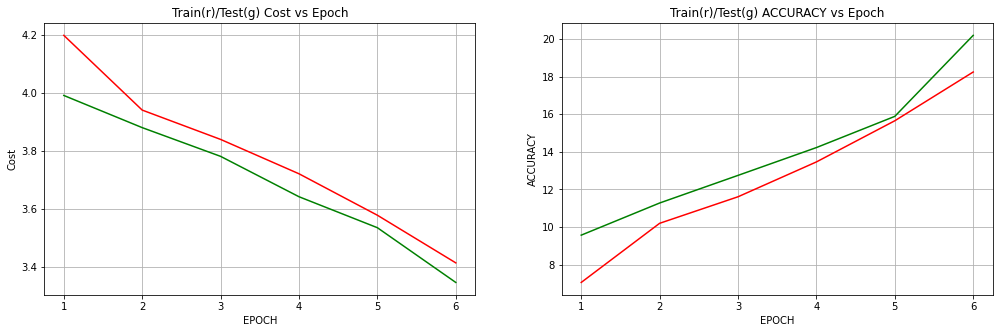

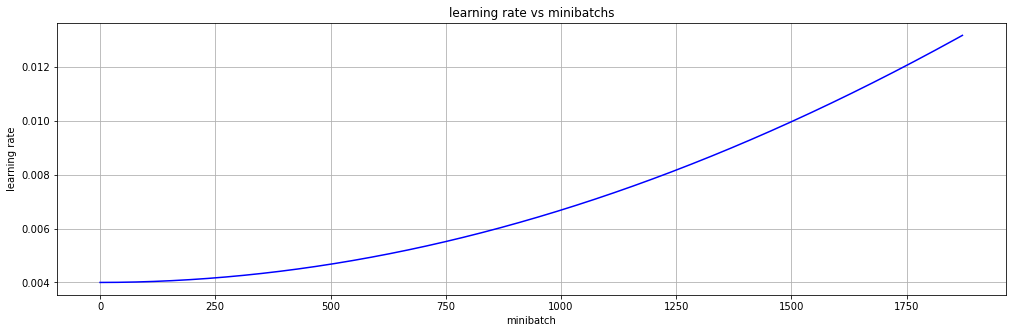

----------------train----------------
Epoch: 7/100 batch_idx:103 Train Cost:3.248211
Epoch: 7/100 batch_idx:207 Train Cost:3.221708
Epoch: 7/100 batch_idx:311 Train Cost:3.188313
Epoch: 7/100 batch_idx:311 Train Accuracy:21.984000
----------------test----------------
Epoch: 7/100 Test Cost:3.294272 Test Accuracy:21.1500


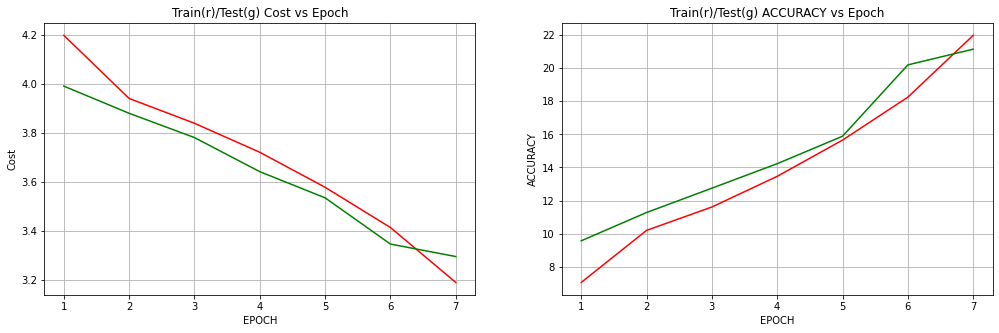

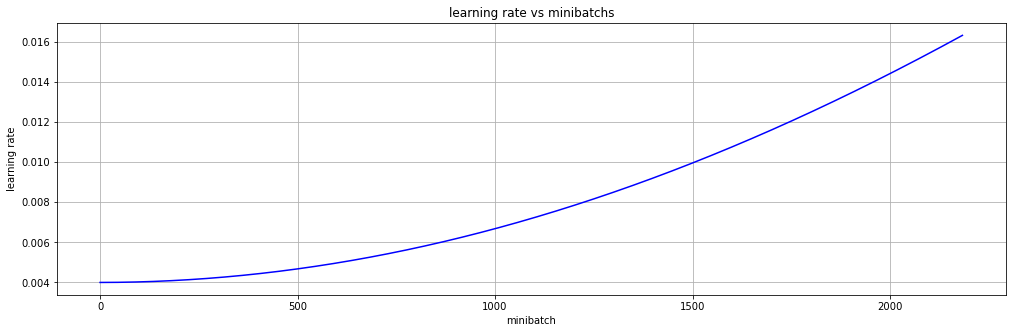

----------------train----------------
Epoch: 8/100 batch_idx:103 Train Cost:3.040416
Epoch: 8/100 batch_idx:207 Train Cost:3.009384
Epoch: 8/100 batch_idx:311 Train Cost:2.983426
Epoch: 8/100 batch_idx:311 Train Accuracy:25.480000
----------------test----------------
Epoch: 8/100 Test Cost:2.916064 Test Accuracy:26.4300


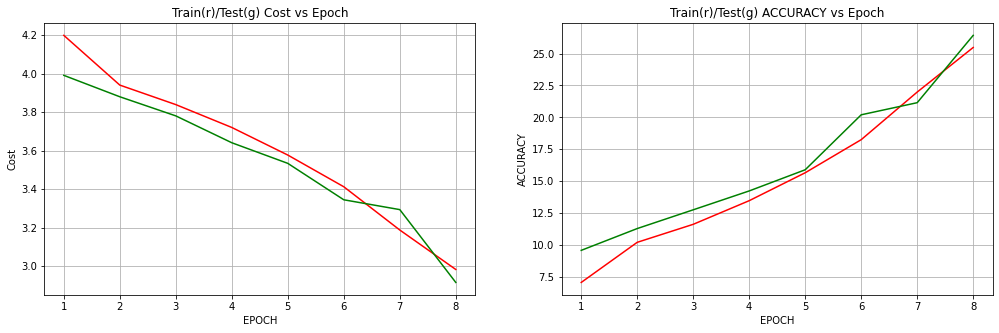

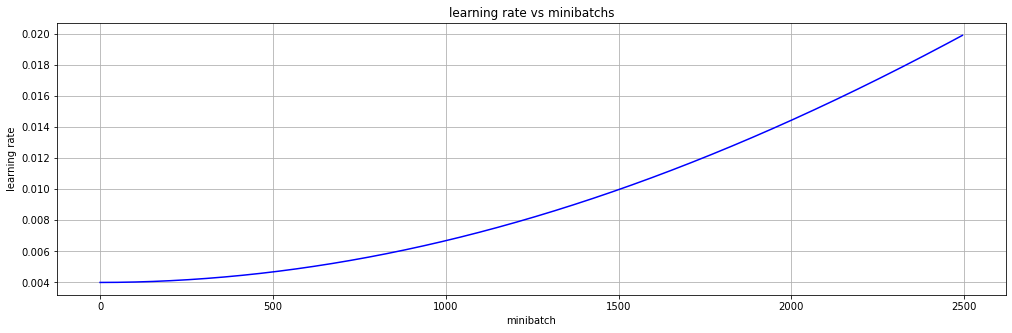

----------------train----------------
Epoch: 9/100 batch_idx:103 Train Cost:2.832343
Epoch: 9/100 batch_idx:207 Train Cost:2.803306
Epoch: 9/100 batch_idx:311 Train Cost:2.778326
Epoch: 9/100 batch_idx:311 Train Accuracy:29.054000
----------------test----------------
Epoch: 9/100 Test Cost:2.924054 Test Accuracy:27.2100


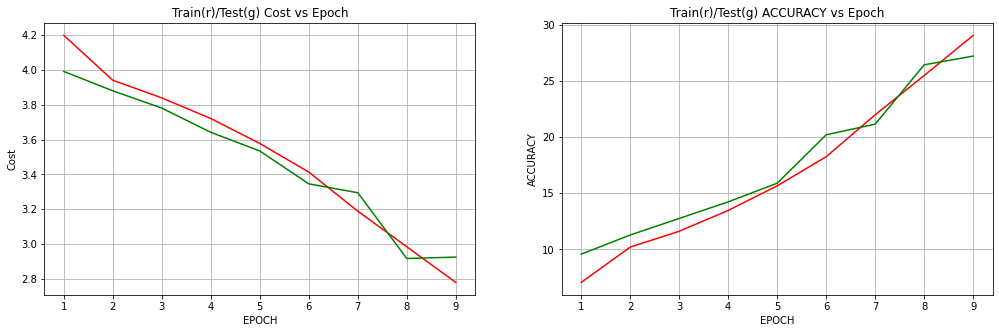

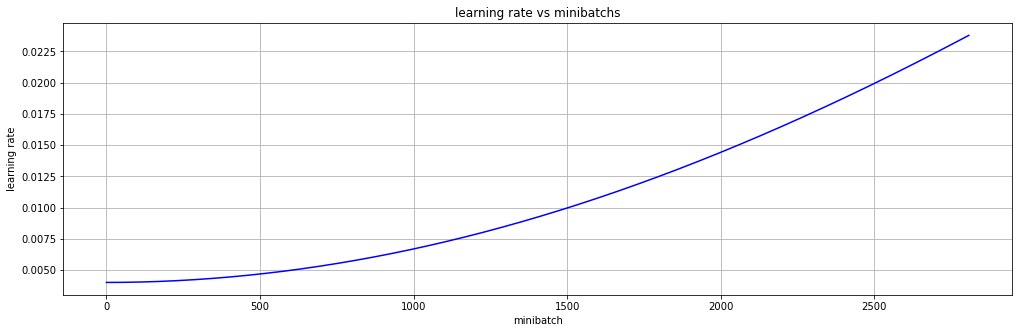

----------------train----------------
Epoch:10/100 batch_idx:103 Train Cost:2.666744
Epoch:10/100 batch_idx:207 Train Cost:2.620365
Epoch:10/100 batch_idx:311 Train Cost:2.586972
Epoch:10/100 batch_idx:311 Train Accuracy:33.256000
----------------test----------------
Epoch:10/100 Test Cost:2.704220 Test Accuracy:30.6100


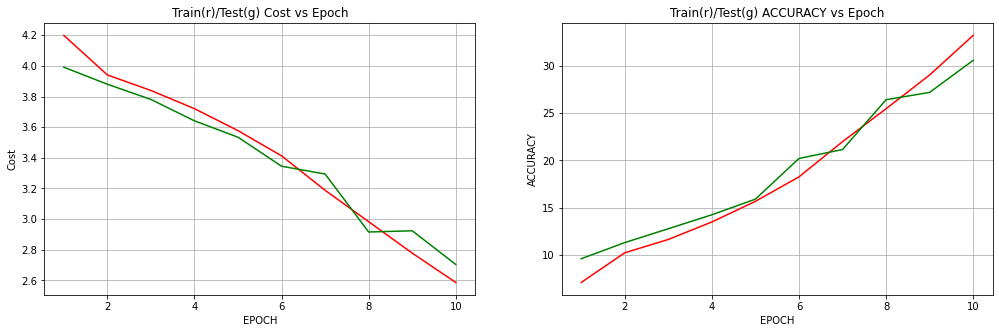

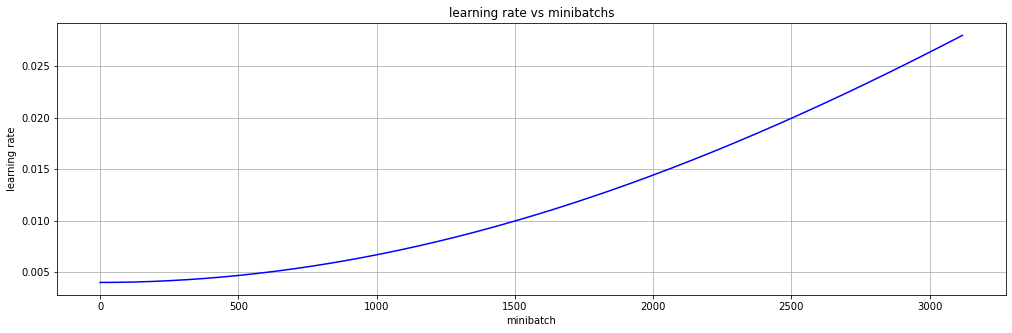

----------------train----------------
Epoch:11/100 batch_idx:103 Train Cost:2.468182
Epoch:11/100 batch_idx:207 Train Cost:2.427615
Epoch:11/100 batch_idx:311 Train Cost:2.406305
Epoch:11/100 batch_idx:311 Train Accuracy:36.660000
----------------test----------------
Epoch:11/100 Test Cost:2.356029 Test Accuracy:37.2800


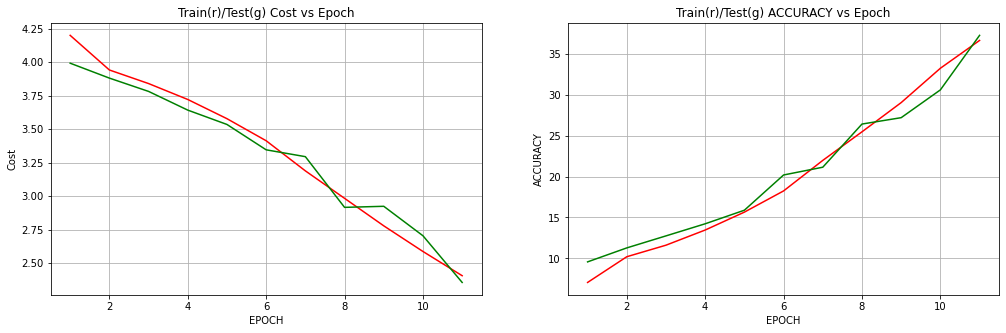

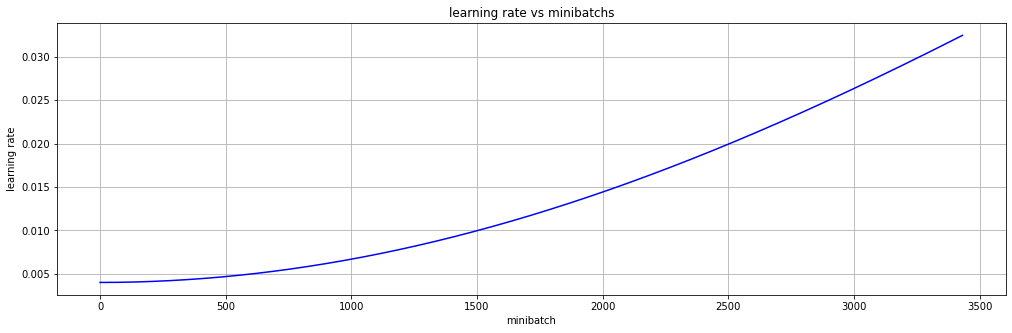

----------------train----------------
Epoch:12/100 batch_idx:103 Train Cost:2.250436
Epoch:12/100 batch_idx:207 Train Cost:2.249571
Epoch:12/100 batch_idx:311 Train Cost:2.225318
Epoch:12/100 batch_idx:311 Train Accuracy:40.226000
----------------test----------------
Epoch:12/100 Test Cost:2.723720 Test Accuracy:33.8800


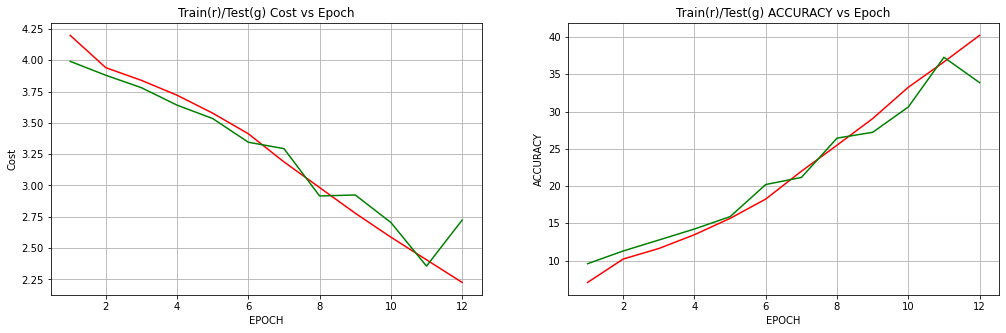

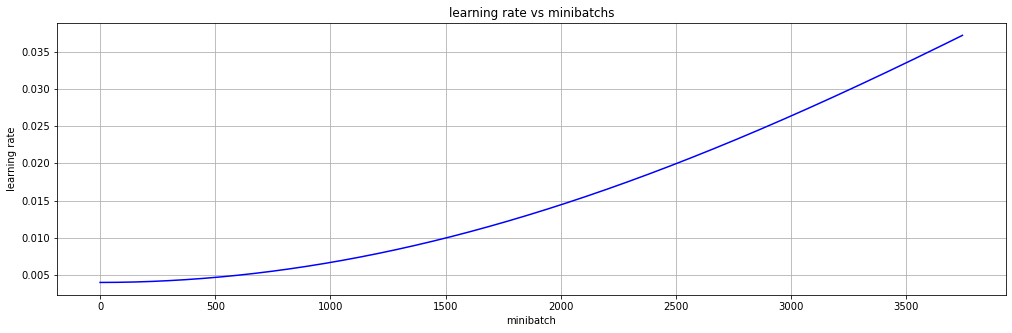

----------------train----------------
Epoch:13/100 batch_idx:103 Train Cost:2.137318
Epoch:13/100 batch_idx:207 Train Cost:2.105119
Epoch:13/100 batch_idx:311 Train Cost:2.080406
Epoch:13/100 batch_idx:311 Train Accuracy:43.568000
----------------test----------------
Epoch:13/100 Test Cost:2.510396 Test Accuracy:37.5000


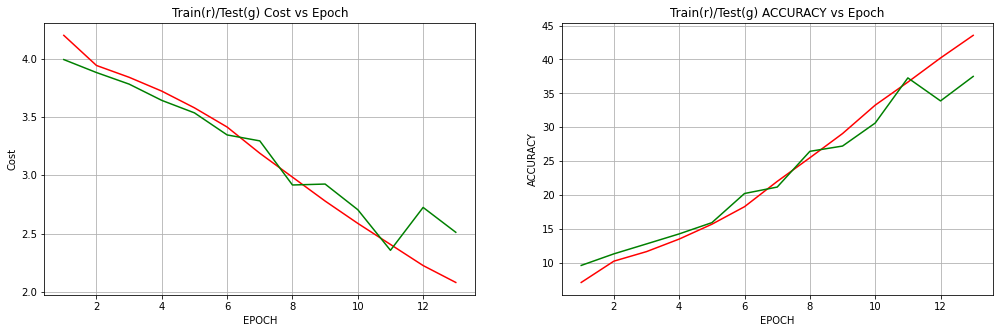

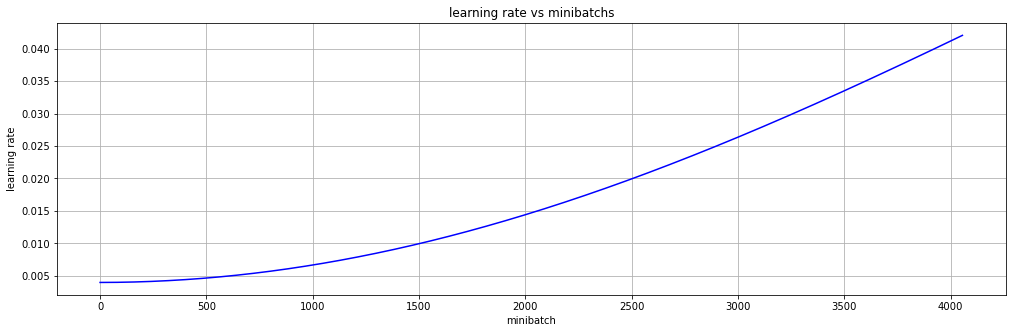

----------------train----------------
Epoch:14/100 batch_idx:103 Train Cost:1.969622
Epoch:14/100 batch_idx:207 Train Cost:1.963250
Epoch:14/100 batch_idx:311 Train Cost:1.945453
Epoch:14/100 batch_idx:311 Train Accuracy:46.302000
----------------test----------------
Epoch:14/100 Test Cost:2.158535 Test Accuracy:41.9200


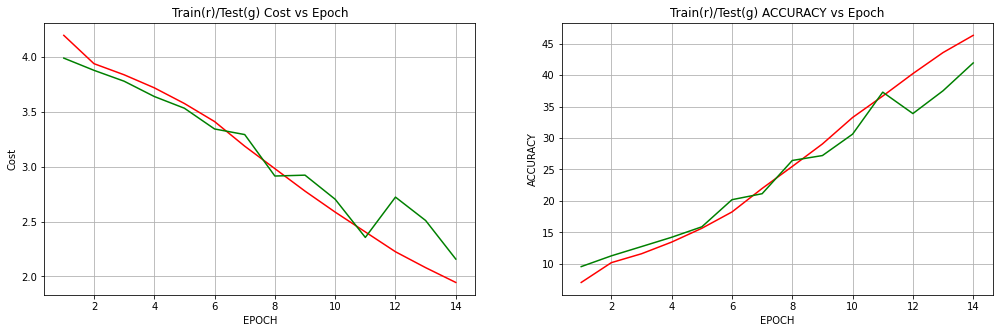

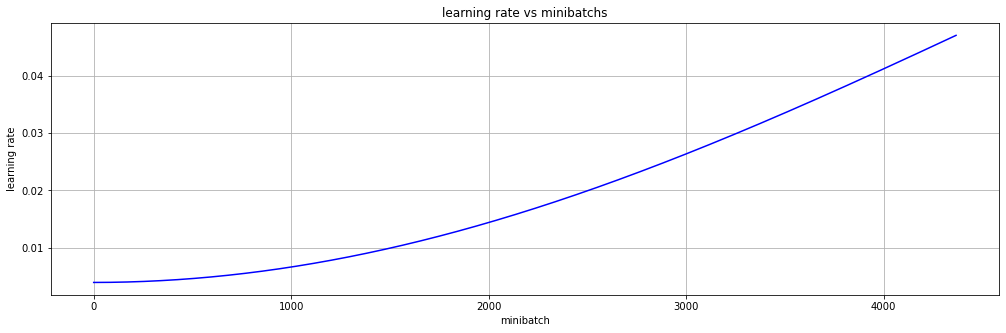

----------------train----------------
Epoch:15/100 batch_idx:103 Train Cost:1.830266
Epoch:15/100 batch_idx:207 Train Cost:1.829394
Epoch:15/100 batch_idx:311 Train Cost:1.814180
Epoch:15/100 batch_idx:311 Train Accuracy:49.458000
----------------test----------------
Epoch:15/100 Test Cost:2.108150 Test Accuracy:44.5900


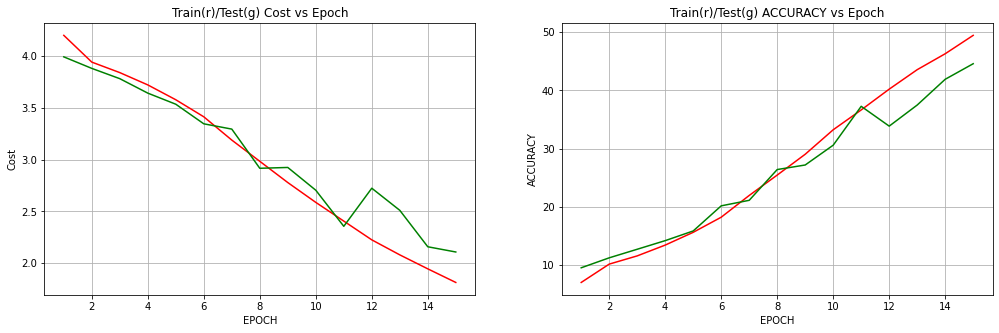

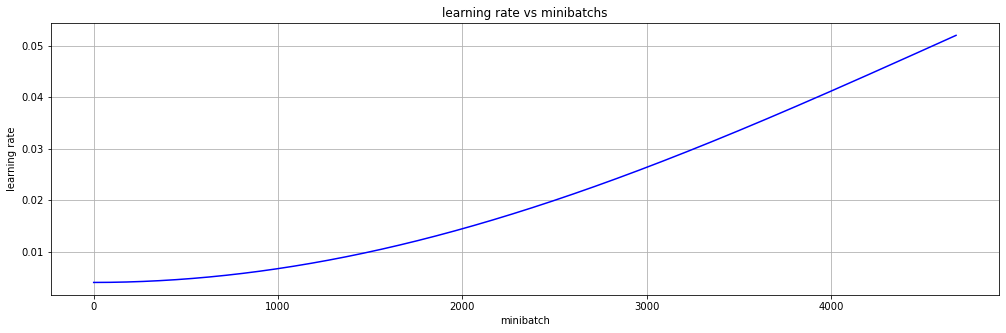

----------------train----------------
Epoch:16/100 batch_idx:103 Train Cost:1.710677
Epoch:16/100 batch_idx:207 Train Cost:1.694061
Epoch:16/100 batch_idx:311 Train Cost:1.704810
Epoch:16/100 batch_idx:311 Train Accuracy:52.292000
----------------test----------------
Epoch:16/100 Test Cost:2.243160 Test Accuracy:43.5000


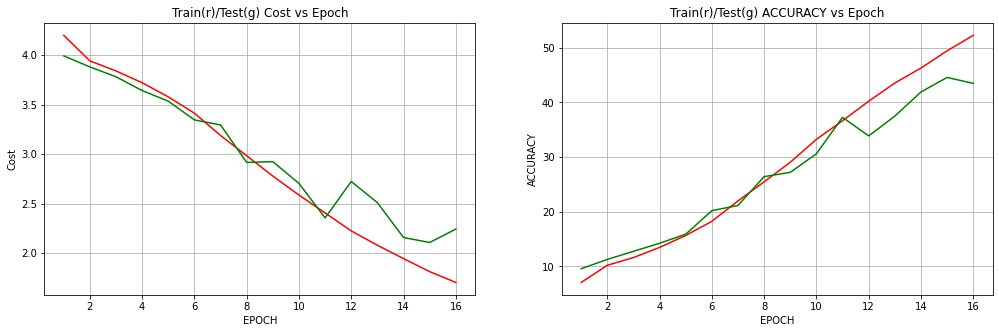

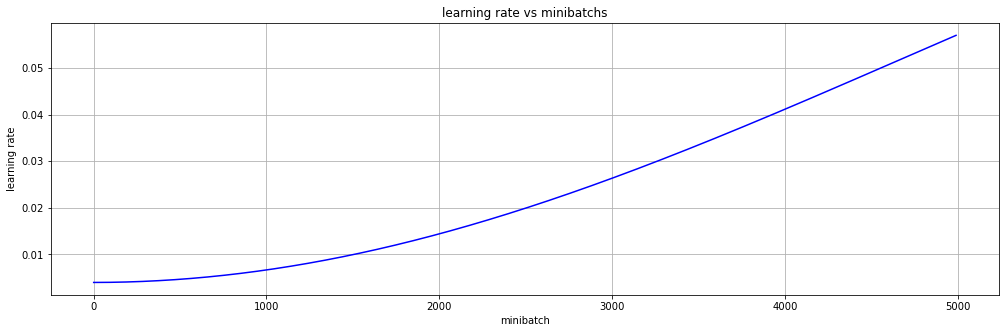

----------------train----------------
Epoch:17/100 batch_idx:103 Train Cost:1.591137
Epoch:17/100 batch_idx:207 Train Cost:1.604921
Epoch:17/100 batch_idx:311 Train Cost:1.600557
Epoch:17/100 batch_idx:311 Train Accuracy:54.850000
----------------test----------------
Epoch:17/100 Test Cost:1.861549 Test Accuracy:49.8800


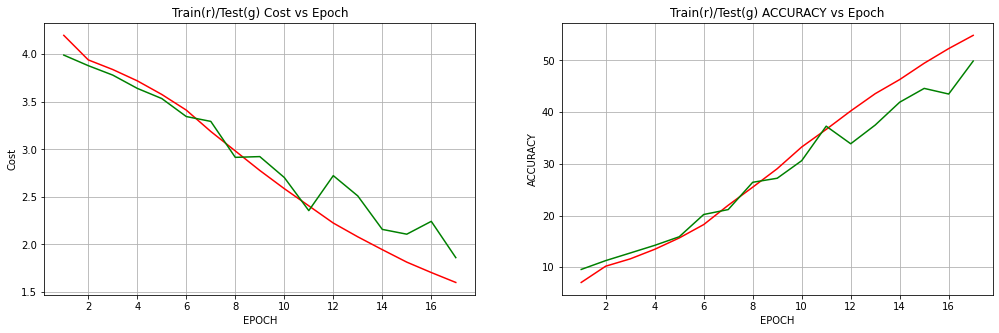

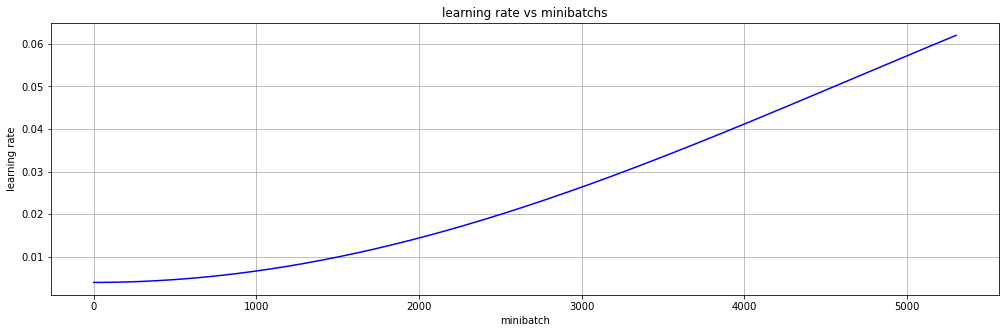

----------------train----------------
Epoch:18/100 batch_idx:103 Train Cost:1.495703
Epoch:18/100 batch_idx:207 Train Cost:1.510619
Epoch:18/100 batch_idx:311 Train Cost:1.507690
Epoch:18/100 batch_idx:311 Train Accuracy:57.078000
----------------test----------------
Epoch:18/100 Test Cost:1.913319 Test Accuracy:50.0200


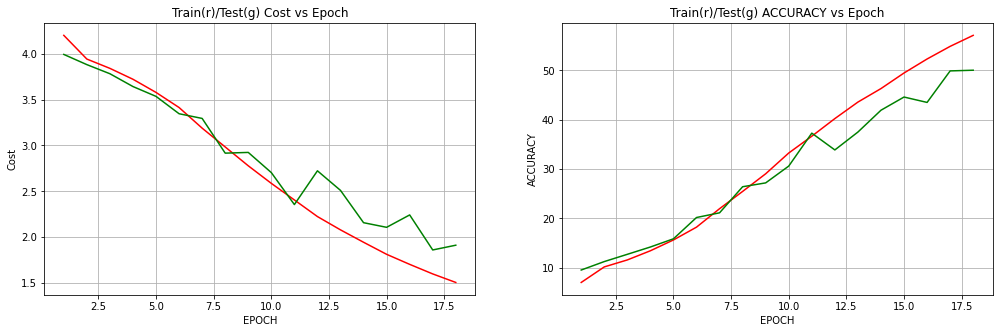

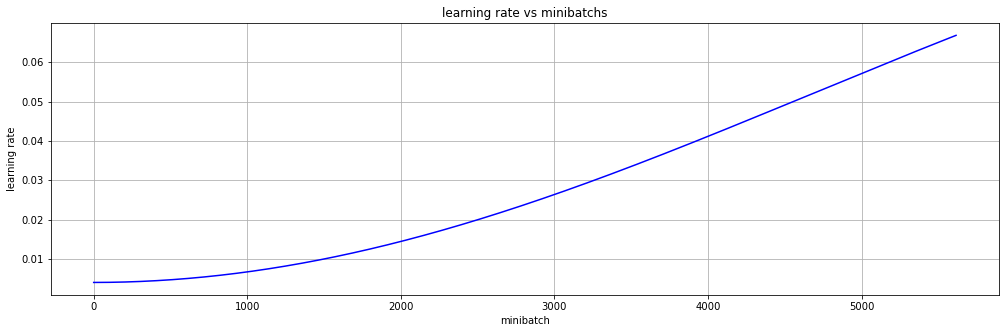

----------------train----------------
Epoch:19/100 batch_idx:103 Train Cost:1.430365
Epoch:19/100 batch_idx:207 Train Cost:1.427223
Epoch:19/100 batch_idx:311 Train Cost:1.429972
Epoch:19/100 batch_idx:311 Train Accuracy:59.118000
----------------test----------------
Epoch:19/100 Test Cost:1.854560 Test Accuracy:51.8500


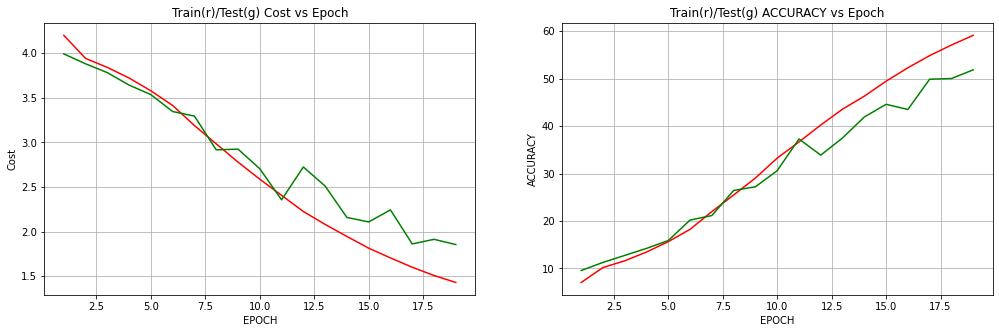

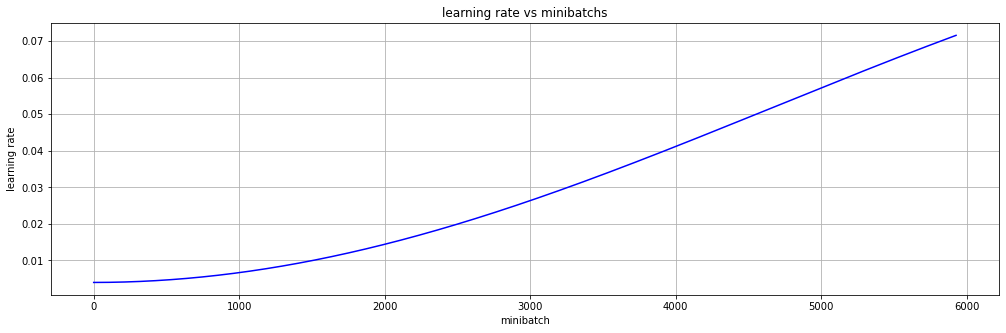

----------------train----------------
Epoch:20/100 batch_idx:103 Train Cost:1.322324
Epoch:20/100 batch_idx:207 Train Cost:1.344623
Epoch:20/100 batch_idx:311 Train Cost:1.351781
Epoch:20/100 batch_idx:311 Train Accuracy:61.040000
----------------test----------------
Epoch:20/100 Test Cost:1.592715 Test Accuracy:55.7400


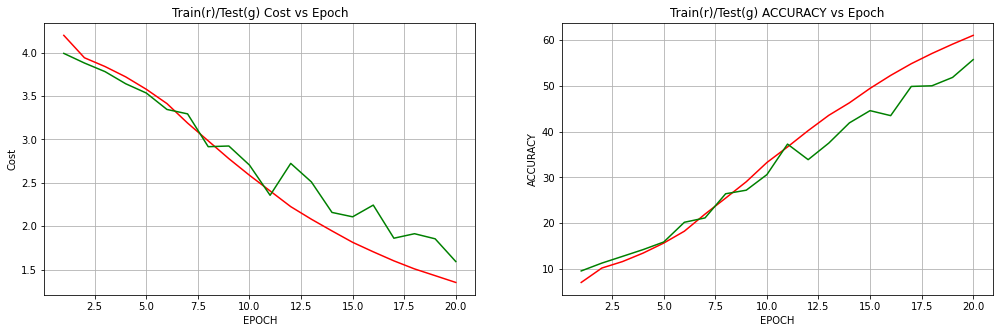

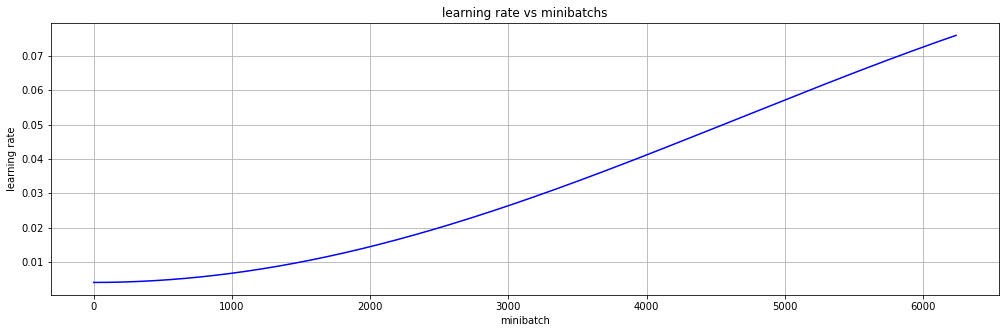

----------------train----------------
Epoch:21/100 batch_idx:103 Train Cost:1.260712
Epoch:21/100 batch_idx:207 Train Cost:1.276739
Epoch:21/100 batch_idx:311 Train Cost:1.286279
Epoch:21/100 batch_idx:311 Train Accuracy:62.478000
----------------test----------------
Epoch:21/100 Test Cost:1.608135 Test Accuracy:56.7300


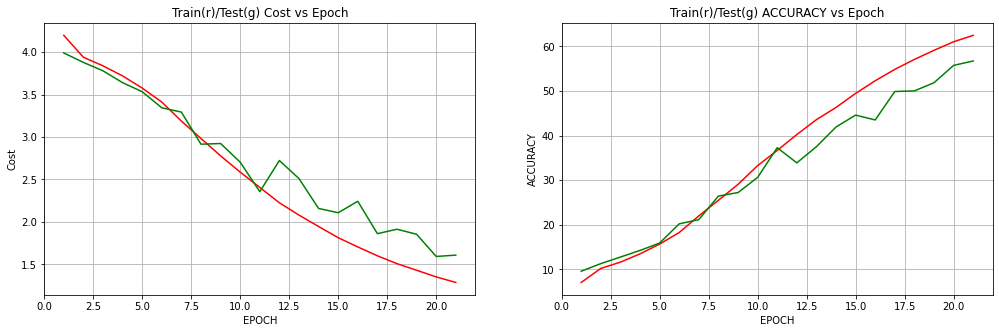

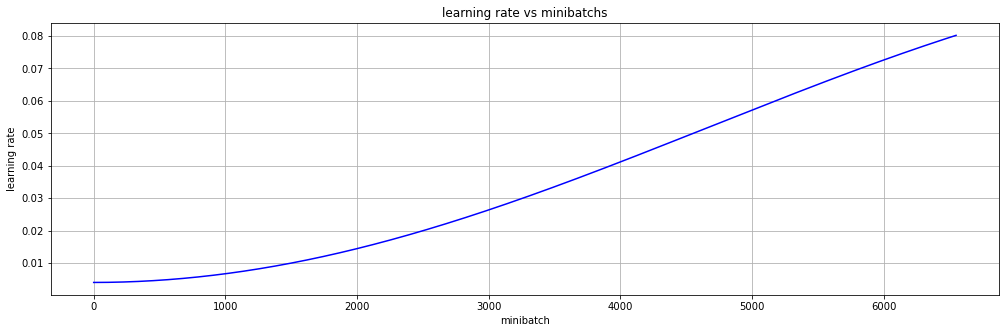

----------------train----------------
Epoch:22/100 batch_idx:103 Train Cost:1.199797
Epoch:22/100 batch_idx:207 Train Cost:1.212638
Epoch:22/100 batch_idx:311 Train Cost:1.215842
Epoch:22/100 batch_idx:311 Train Accuracy:64.532000
----------------test----------------
Epoch:22/100 Test Cost:1.636790 Test Accuracy:56.6300


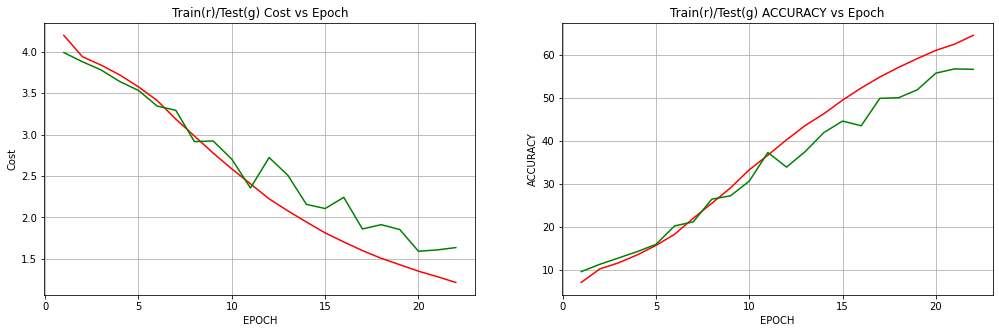

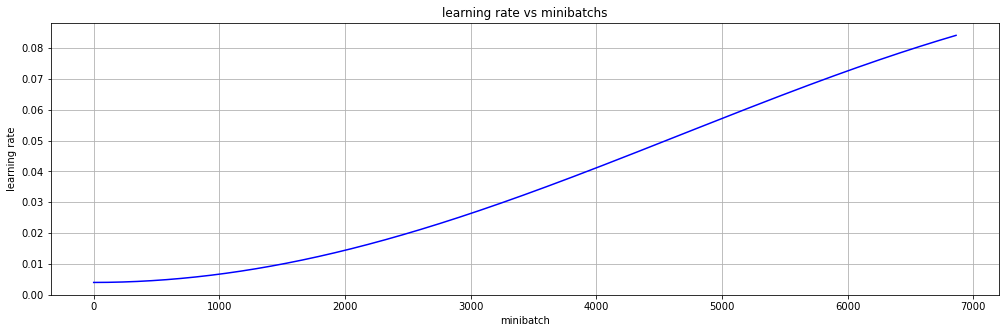

----------------train----------------
Epoch:23/100 batch_idx:103 Train Cost:1.138723
Epoch:23/100 batch_idx:207 Train Cost:1.134303
Epoch:23/100 batch_idx:311 Train Cost:1.153494
Epoch:23/100 batch_idx:311 Train Accuracy:66.194000
----------------test----------------
Epoch:23/100 Test Cost:1.709005 Test Accuracy:55.7400


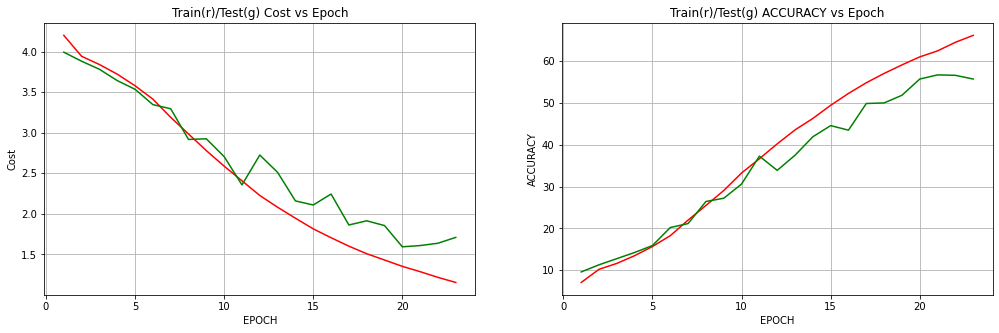

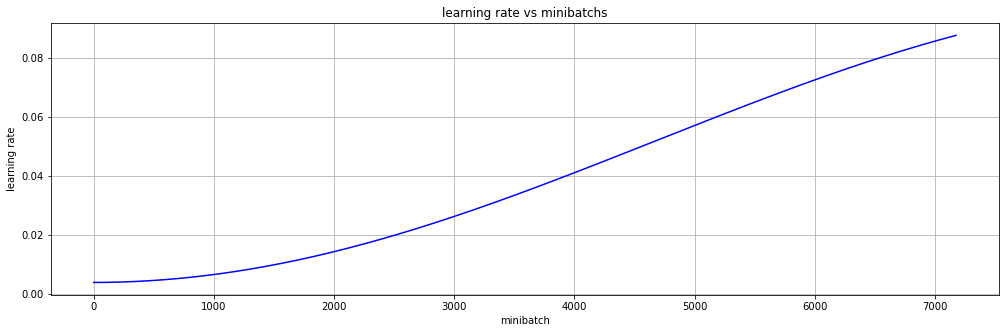

----------------train----------------
Epoch:24/100 batch_idx:103 Train Cost:1.070289
Epoch:24/100 batch_idx:207 Train Cost:1.081982
Epoch:24/100 batch_idx:311 Train Cost:1.094266
Epoch:24/100 batch_idx:311 Train Accuracy:67.816000
----------------test----------------
Epoch:24/100 Test Cost:1.538800 Test Accuracy:58.9800


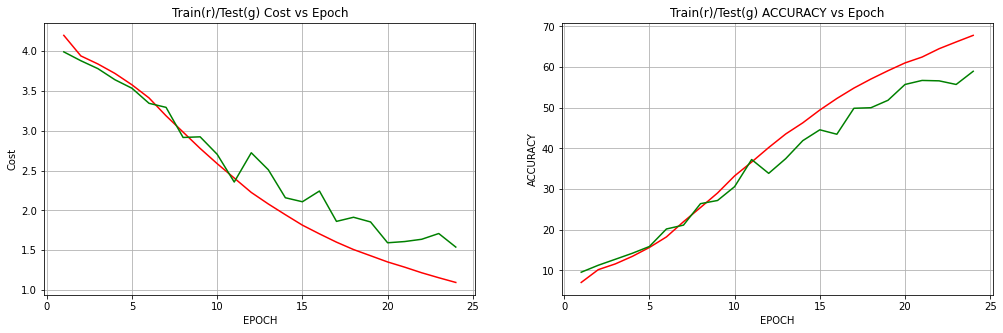

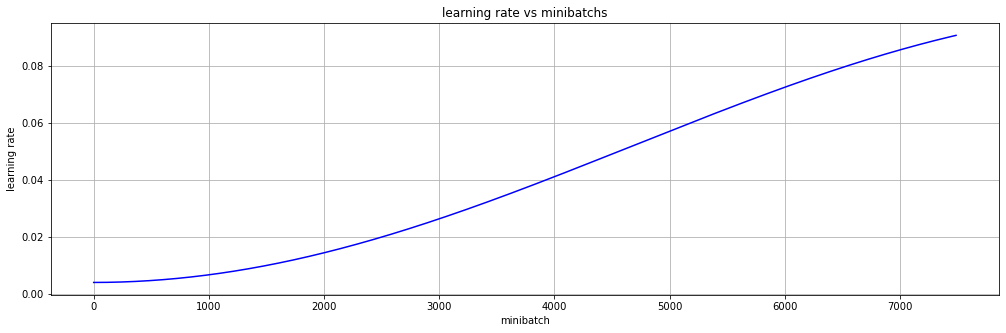

----------------train----------------
Epoch:25/100 batch_idx:103 Train Cost:1.031961
Epoch:25/100 batch_idx:207 Train Cost:1.031220
Epoch:25/100 batch_idx:311 Train Cost:1.042186
Epoch:25/100 batch_idx:311 Train Accuracy:68.980000
----------------test----------------
Epoch:25/100 Test Cost:1.534560 Test Accuracy:58.7800


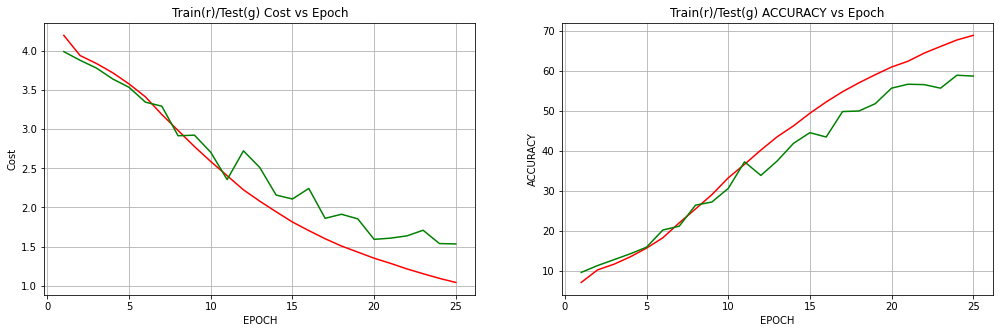

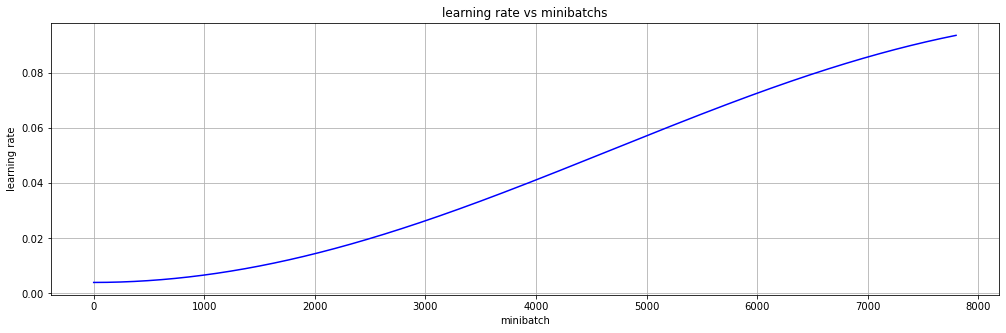

----------------train----------------
Epoch:26/100 batch_idx:103 Train Cost:0.956440
Epoch:26/100 batch_idx:207 Train Cost:0.967062
Epoch:26/100 batch_idx:311 Train Cost:0.979965
Epoch:26/100 batch_idx:311 Train Accuracy:70.950000
----------------test----------------
Epoch:26/100 Test Cost:1.911411 Test Accuracy:54.6600


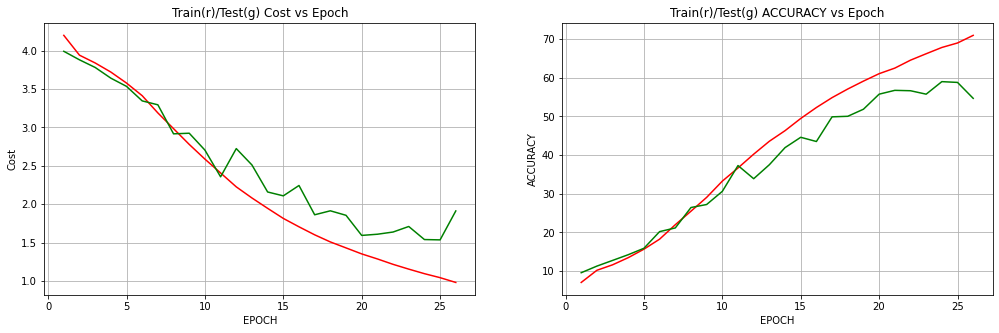

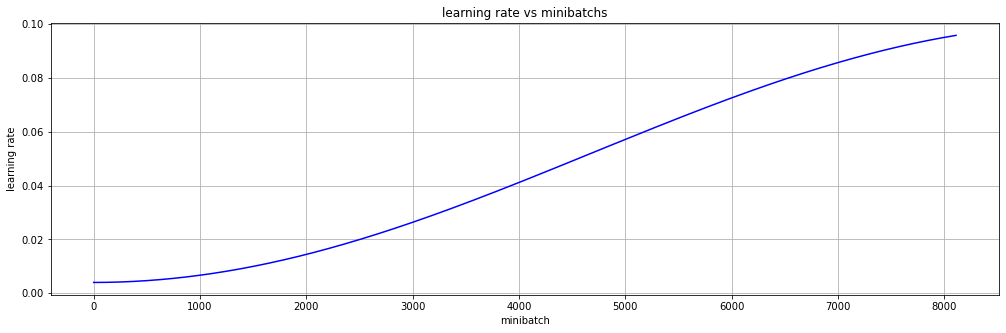

----------------train----------------
Epoch:27/100 batch_idx:103 Train Cost:0.902553
Epoch:27/100 batch_idx:207 Train Cost:0.926896
Epoch:27/100 batch_idx:311 Train Cost:0.938513
Epoch:27/100 batch_idx:311 Train Accuracy:71.968000
----------------test----------------
Epoch:27/100 Test Cost:1.571118 Test Accuracy:59.6300


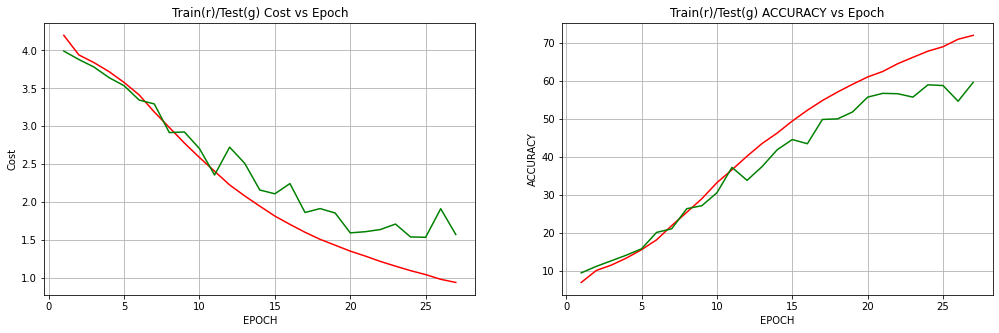

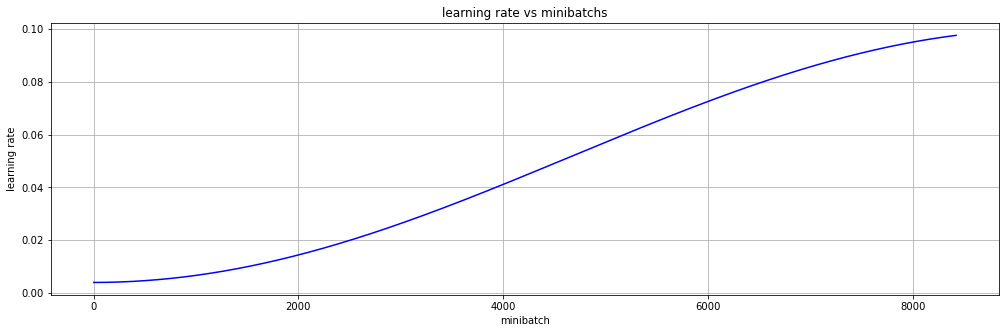

----------------train----------------
Epoch:28/100 batch_idx:103 Train Cost:0.854585
Epoch:28/100 batch_idx:207 Train Cost:0.869443
Epoch:28/100 batch_idx:311 Train Cost:0.879621
Epoch:28/100 batch_idx:311 Train Accuracy:73.432000
----------------test----------------
Epoch:28/100 Test Cost:1.535087 Test Accuracy:61.3600


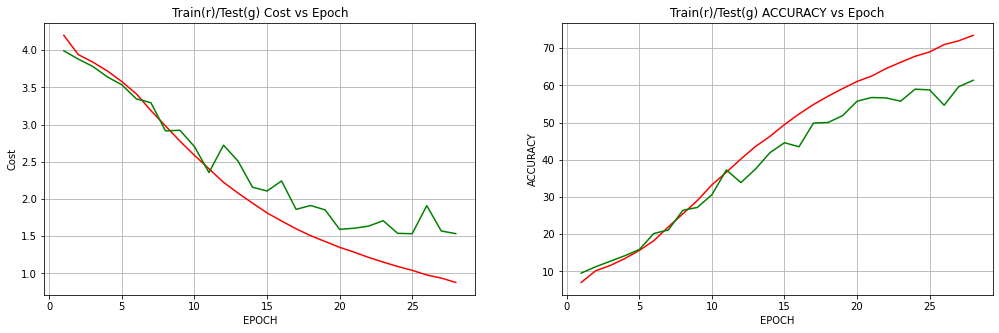

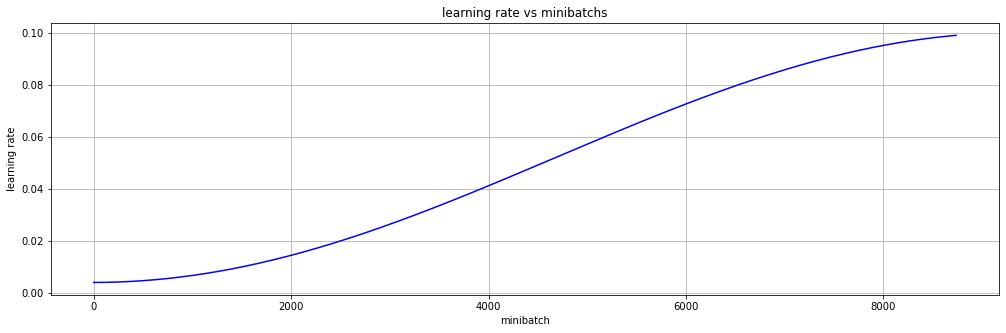

----------------train----------------
Epoch:29/100 batch_idx:103 Train Cost:0.799831
Epoch:29/100 batch_idx:207 Train Cost:0.827864
Epoch:29/100 batch_idx:311 Train Cost:0.841698
Epoch:29/100 batch_idx:311 Train Accuracy:74.492000
----------------test----------------
Epoch:29/100 Test Cost:1.616825 Test Accuracy:60.1500


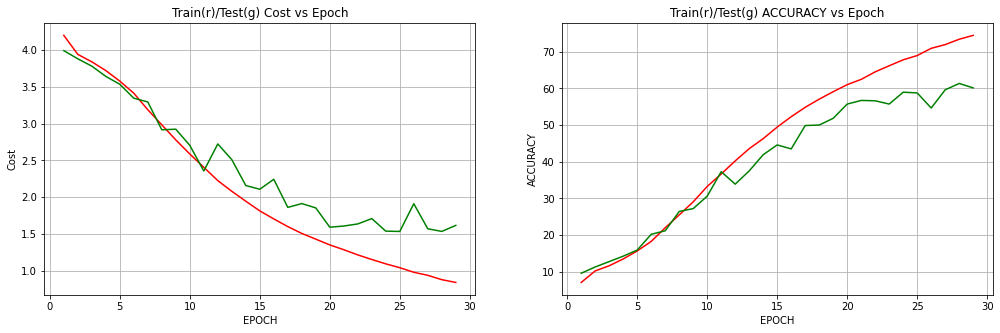

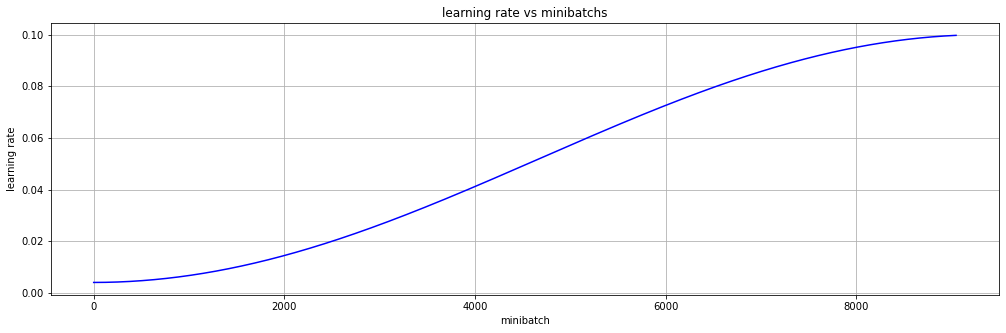

----------------train----------------
Epoch:30/100 batch_idx:103 Train Cost:0.757463
Epoch:30/100 batch_idx:207 Train Cost:0.772232
Epoch:30/100 batch_idx:311 Train Cost:0.787925
Epoch:30/100 batch_idx:311 Train Accuracy:75.882000
----------------test----------------
Epoch:30/100 Test Cost:1.446510 Test Accuracy:61.7600


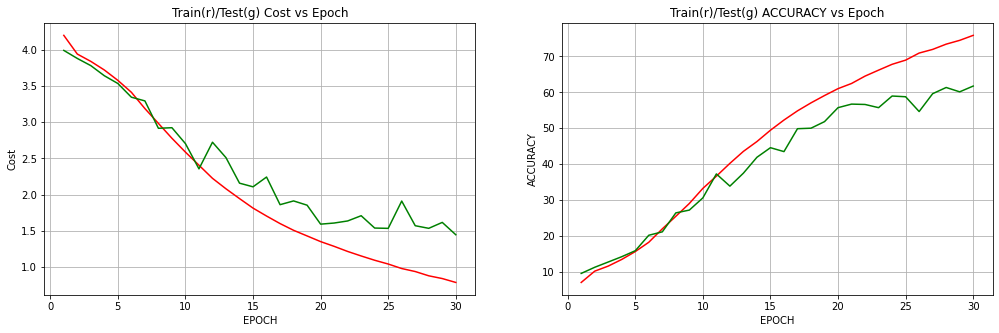

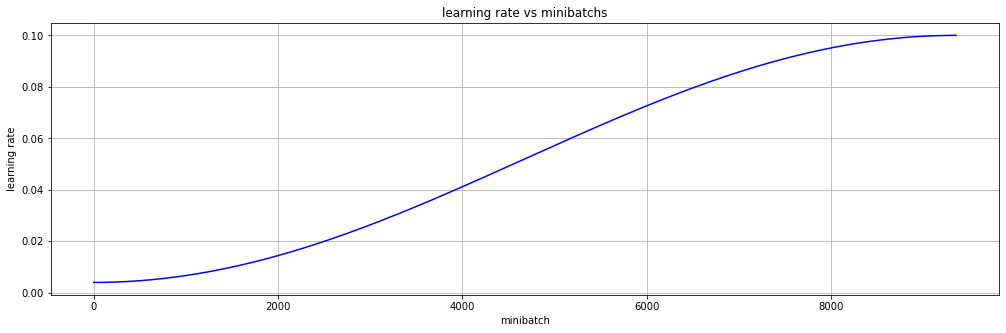

----------------train----------------
Epoch:31/100 batch_idx:103 Train Cost:0.708986
Epoch:31/100 batch_idx:207 Train Cost:0.722945
Epoch:31/100 batch_idx:311 Train Cost:0.740287
Epoch:31/100 batch_idx:311 Train Accuracy:77.306000
----------------test----------------
Epoch:31/100 Test Cost:1.674135 Test Accuracy:61.4900


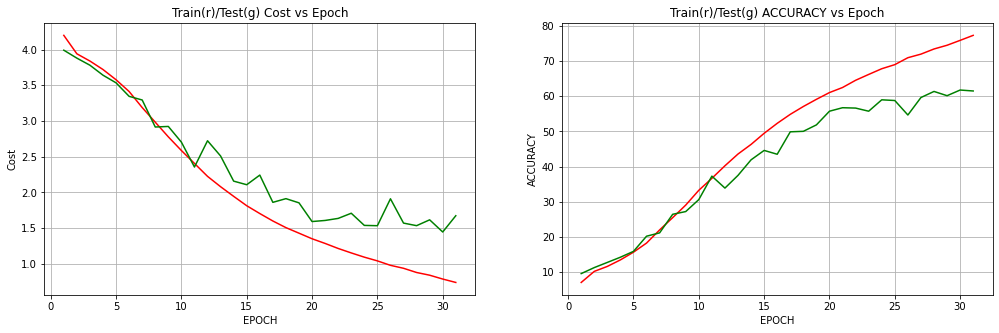

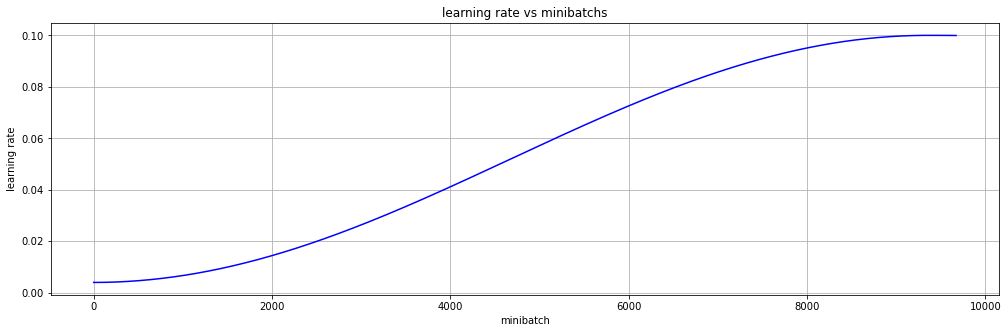

----------------train----------------
Epoch:32/100 batch_idx:103 Train Cost:0.680423
Epoch:32/100 batch_idx:207 Train Cost:0.689225
Epoch:32/100 batch_idx:311 Train Cost:0.702379
Epoch:32/100 batch_idx:311 Train Accuracy:77.988000
----------------test----------------
Epoch:32/100 Test Cost:1.614876 Test Accuracy:61.1400


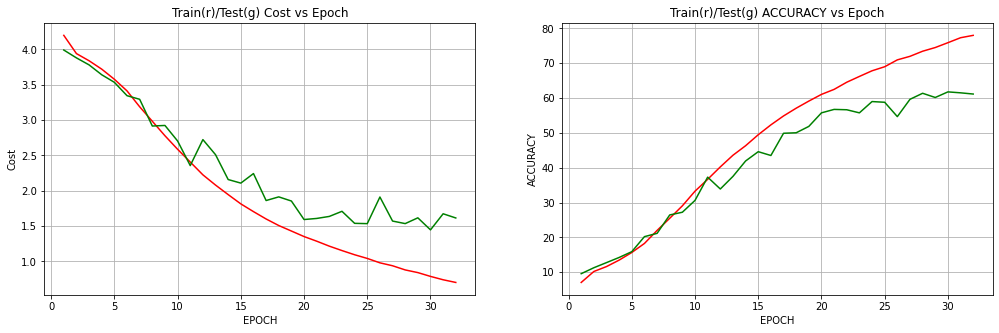

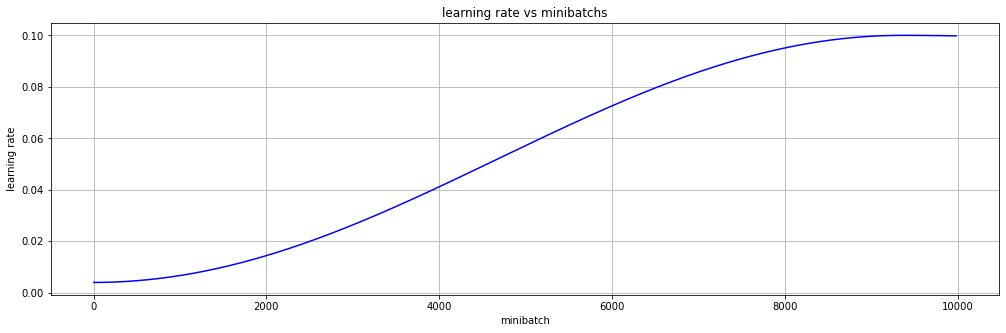

----------------train----------------
Epoch:33/100 batch_idx:103 Train Cost:0.621208
Epoch:33/100 batch_idx:207 Train Cost:0.646691
Epoch:33/100 batch_idx:311 Train Cost:0.666871
Epoch:33/100 batch_idx:311 Train Accuracy:79.128000
----------------test----------------
Epoch:33/100 Test Cost:1.741105 Test Accuracy:59.7000


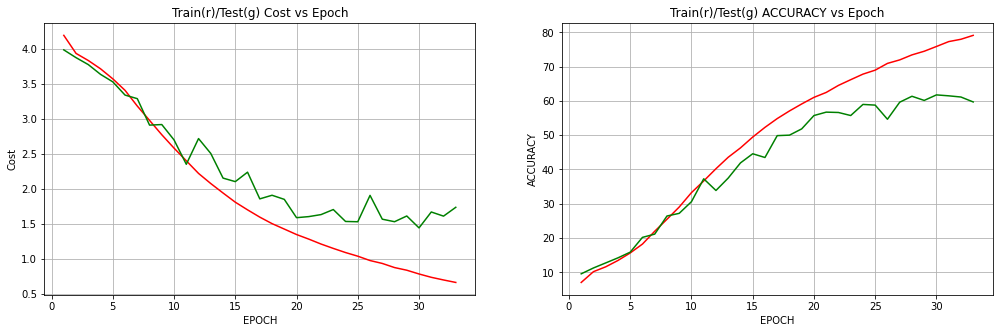

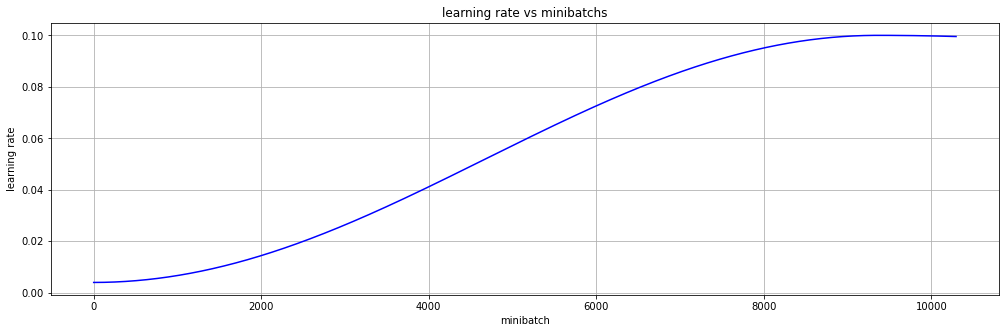

----------------train----------------
Epoch:34/100 batch_idx:103 Train Cost:0.571240
Epoch:34/100 batch_idx:207 Train Cost:0.610017
Epoch:34/100 batch_idx:311 Train Cost:0.622490
Epoch:34/100 batch_idx:311 Train Accuracy:80.484000
----------------test----------------
Epoch:34/100 Test Cost:1.444348 Test Accuracy:64.4500


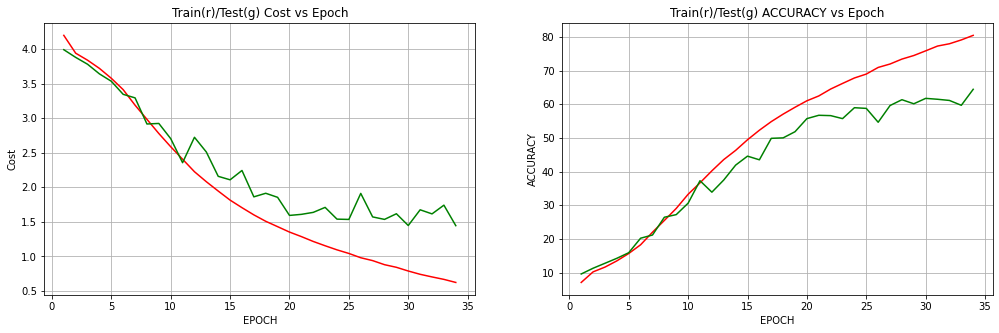

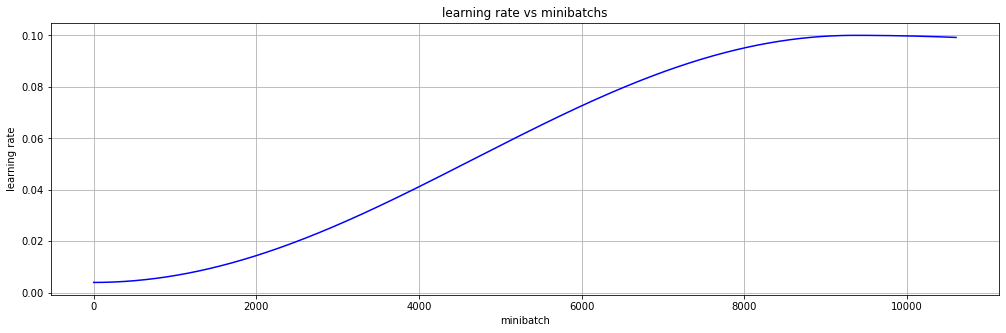

----------------train----------------
Epoch:35/100 batch_idx:103 Train Cost:0.531098
Epoch:35/100 batch_idx:207 Train Cost:0.567029
Epoch:35/100 batch_idx:311 Train Cost:0.581352
Epoch:35/100 batch_idx:311 Train Accuracy:81.636000
----------------test----------------
Epoch:35/100 Test Cost:1.560016 Test Accuracy:62.8600


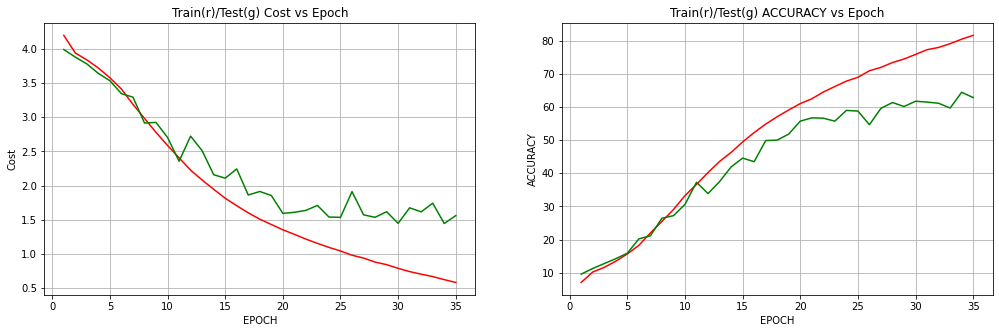

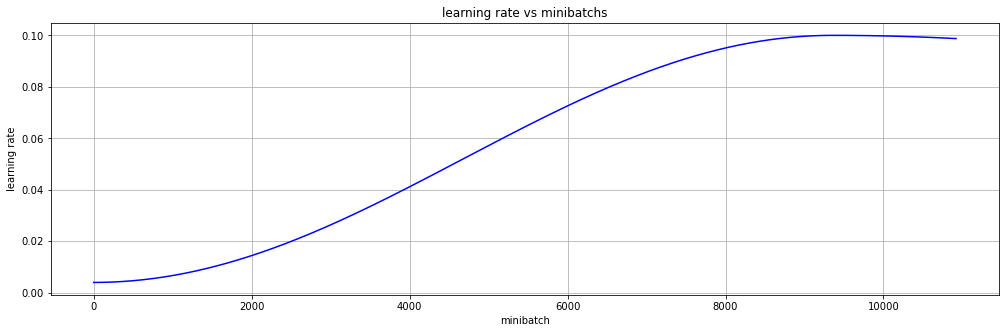

----------------train----------------
Epoch:36/100 batch_idx:103 Train Cost:0.503214
Epoch:36/100 batch_idx:207 Train Cost:0.533704
Epoch:36/100 batch_idx:311 Train Cost:0.555177
Epoch:36/100 batch_idx:311 Train Accuracy:82.408000
----------------test----------------
Epoch:36/100 Test Cost:1.602610 Test Accuracy:63.7700


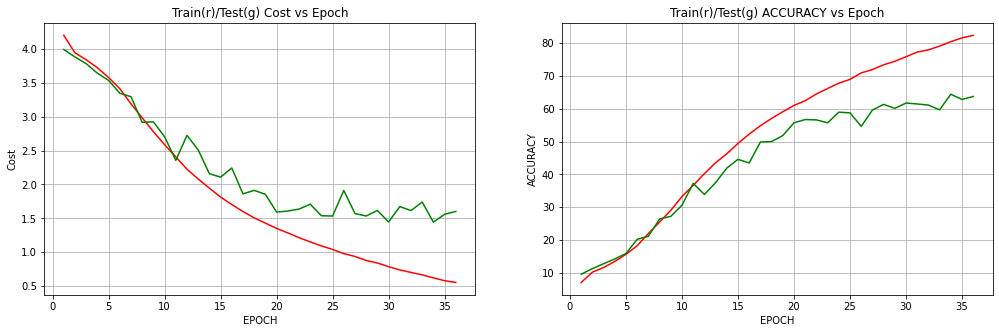

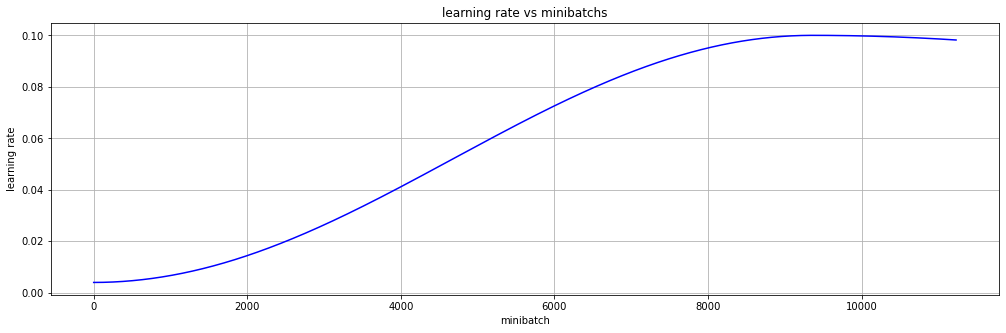

----------------train----------------
Epoch:37/100 batch_idx:103 Train Cost:0.443566
Epoch:37/100 batch_idx:207 Train Cost:0.476010
Epoch:37/100 batch_idx:311 Train Cost:0.500360
Epoch:37/100 batch_idx:311 Train Accuracy:83.880000
----------------test----------------
Epoch:37/100 Test Cost:1.803014 Test Accuracy:61.7800


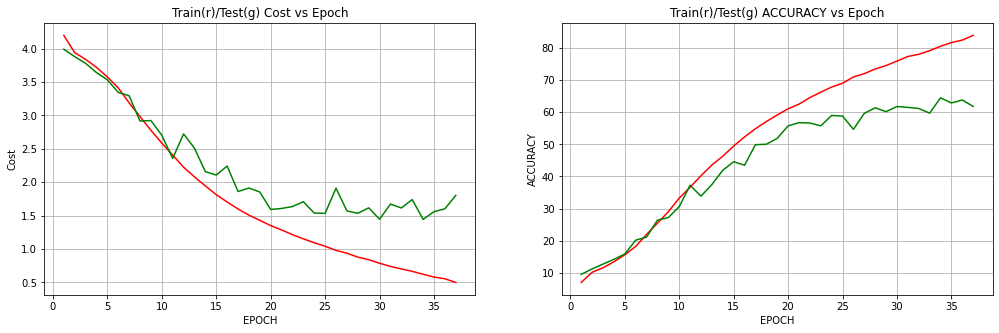

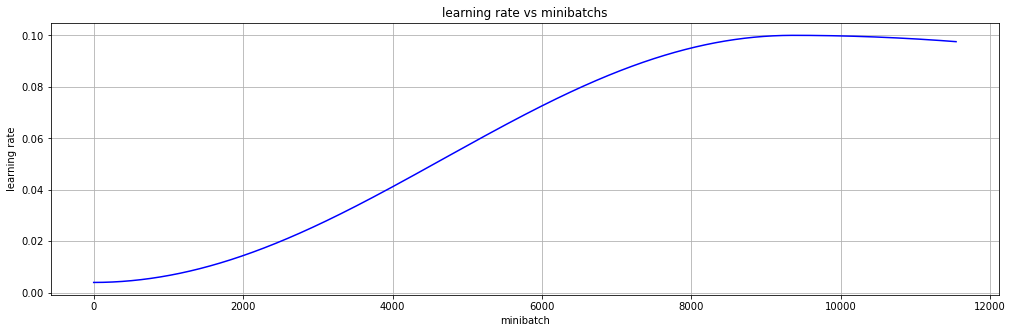

----------------train----------------
Epoch:38/100 batch_idx:103 Train Cost:0.440172
Epoch:38/100 batch_idx:207 Train Cost:0.451548
Epoch:38/100 batch_idx:311 Train Cost:0.477229
Epoch:38/100 batch_idx:311 Train Accuracy:84.528000
----------------test----------------
Epoch:38/100 Test Cost:1.766514 Test Accuracy:62.6900


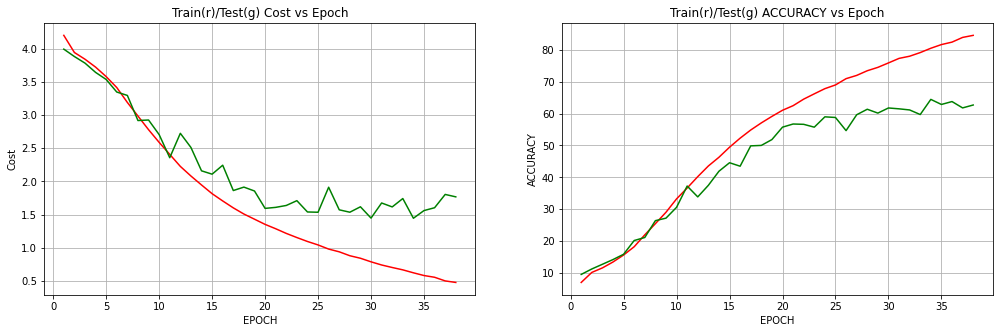

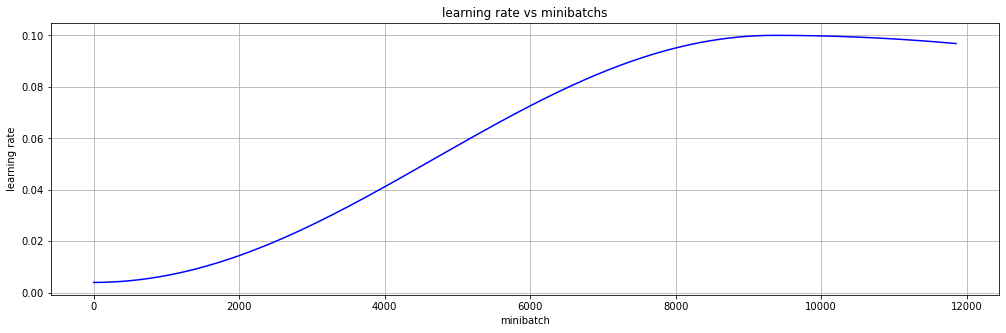

----------------train----------------
Epoch:39/100 batch_idx:103 Train Cost:0.399717
Epoch:39/100 batch_idx:207 Train Cost:0.433147
Epoch:39/100 batch_idx:311 Train Cost:0.445880
Epoch:39/100 batch_idx:311 Train Accuracy:85.484000
----------------test----------------
Epoch:39/100 Test Cost:1.582193 Test Accuracy:63.5800


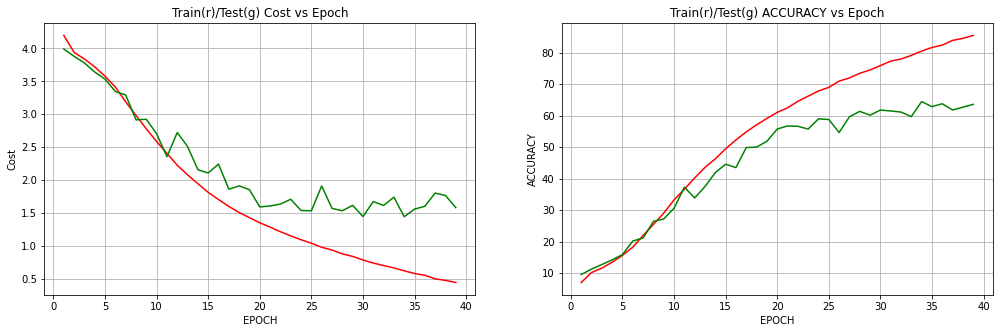

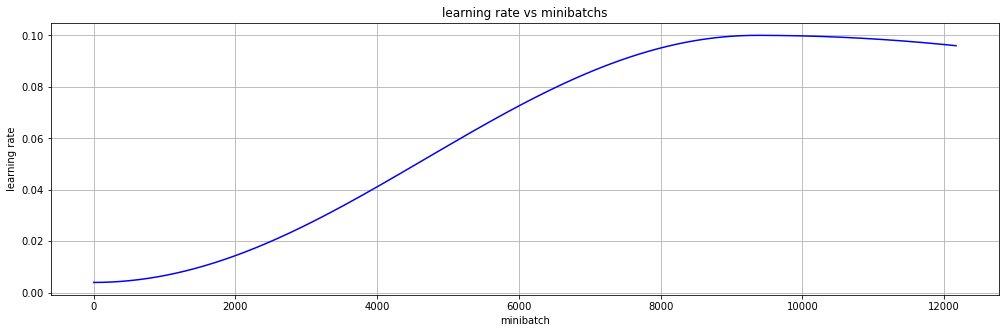

----------------train----------------
Epoch:40/100 batch_idx:103 Train Cost:0.390139
Epoch:40/100 batch_idx:207 Train Cost:0.409935
Epoch:40/100 batch_idx:311 Train Cost:0.430275
Epoch:40/100 batch_idx:311 Train Accuracy:86.010000
----------------test----------------
Epoch:40/100 Test Cost:1.511197 Test Accuracy:65.0900


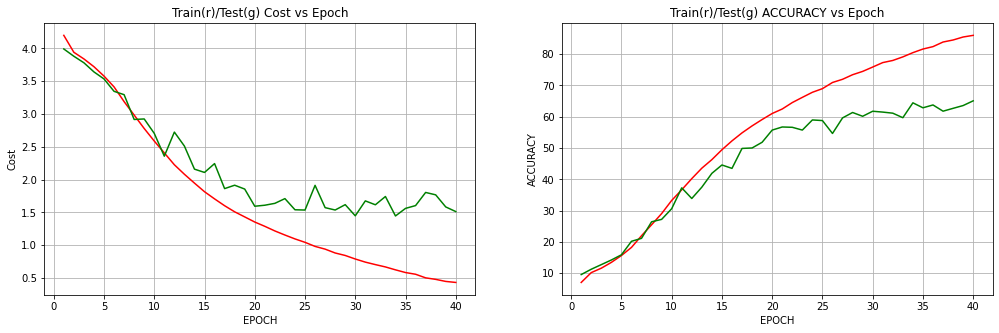

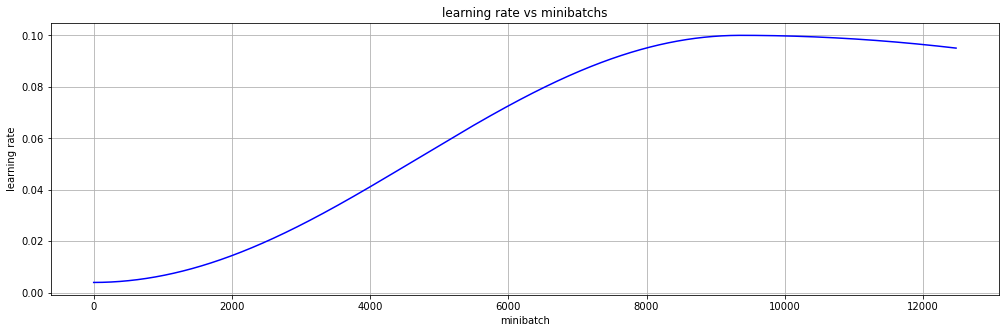

----------------train----------------
Epoch:41/100 batch_idx:103 Train Cost:0.349267
Epoch:41/100 batch_idx:207 Train Cost:0.370556
Epoch:41/100 batch_idx:311 Train Cost:0.389152
Epoch:41/100 batch_idx:311 Train Accuracy:87.288000
----------------test----------------
Epoch:41/100 Test Cost:2.062077 Test Accuracy:61.4200


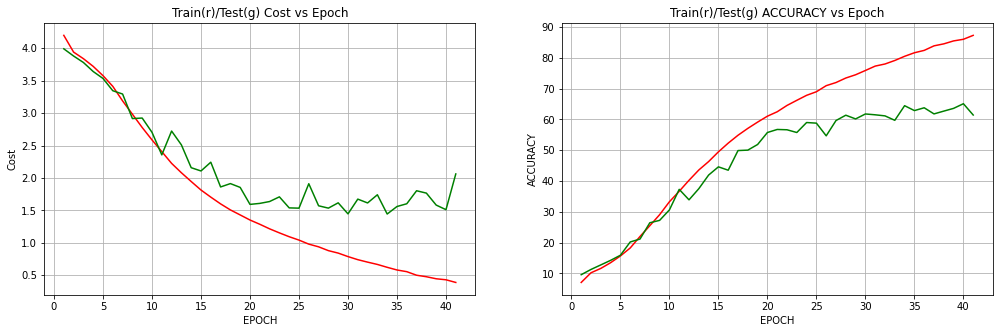

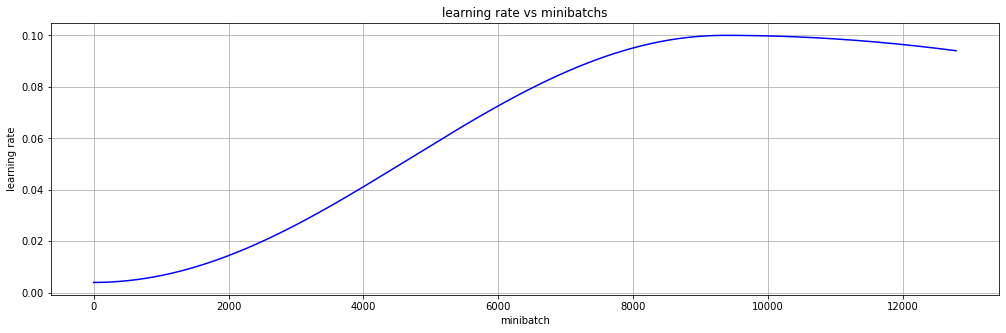

----------------train----------------
Epoch:42/100 batch_idx:103 Train Cost:0.330592
Epoch:42/100 batch_idx:207 Train Cost:0.350445
Epoch:42/100 batch_idx:311 Train Cost:0.360895
Epoch:42/100 batch_idx:311 Train Accuracy:88.066000
----------------test----------------
Epoch:42/100 Test Cost:1.955934 Test Accuracy:61.5100


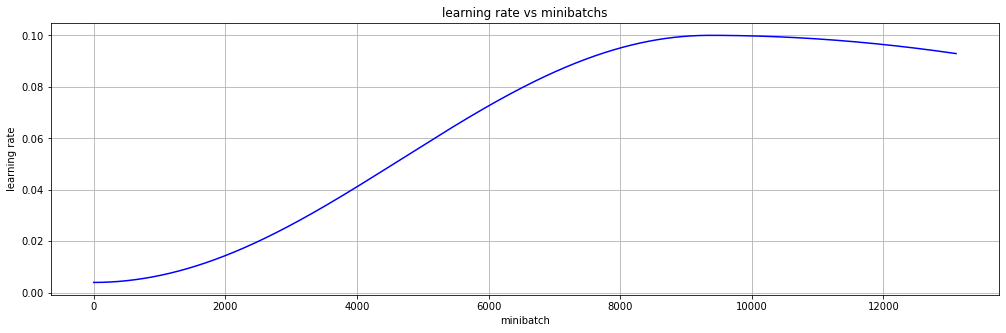

----------------train----------------
Epoch:43/100 batch_idx:103 Train Cost:0.291794
Epoch:43/100 batch_idx:207 Train Cost:0.310244
Epoch:43/100 batch_idx:311 Train Cost:0.331842
Epoch:43/100 batch_idx:311 Train Accuracy:88.940000
----------------test----------------
Epoch:43/100 Test Cost:1.643204 Test Accuracy:65.1600


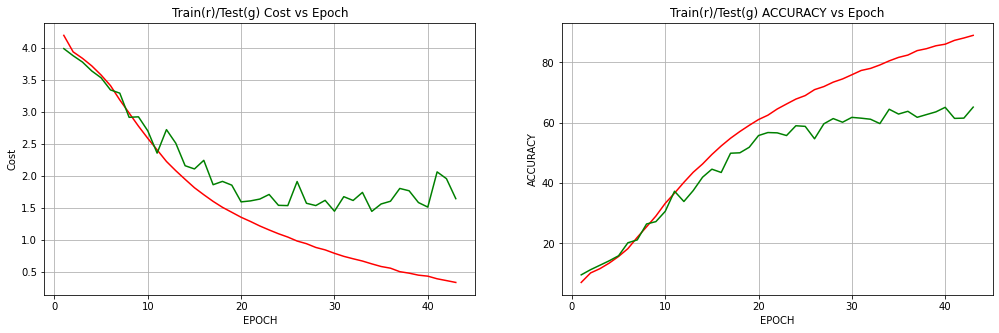

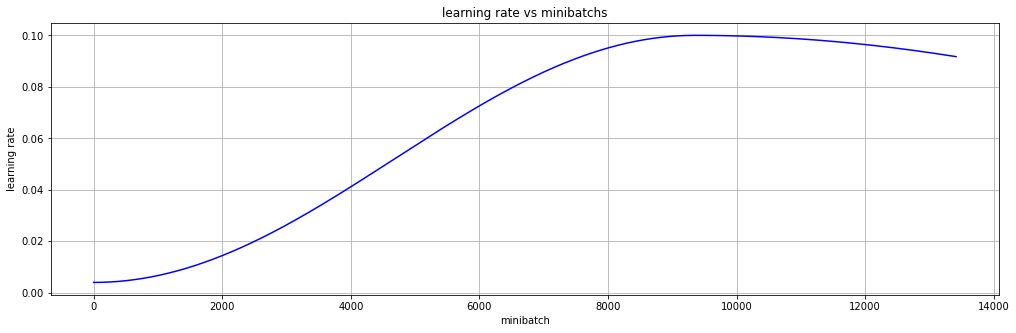

----------------train----------------
Epoch:44/100 batch_idx:103 Train Cost:0.268160
Epoch:44/100 batch_idx:207 Train Cost:0.291871
Epoch:44/100 batch_idx:311 Train Cost:0.307060
Epoch:44/100 batch_idx:311 Train Accuracy:89.810000
----------------test----------------
Epoch:44/100 Test Cost:1.871824 Test Accuracy:63.9800


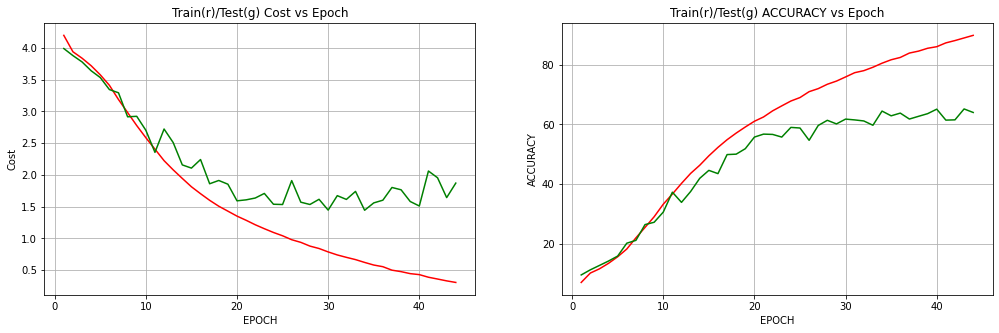

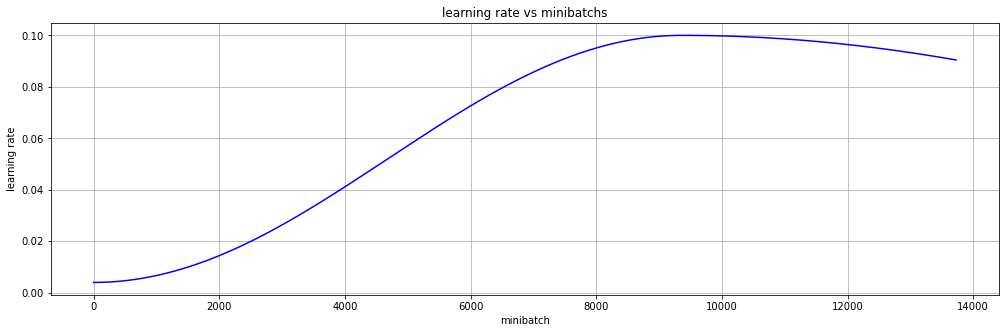

----------------train----------------
Epoch:45/100 batch_idx:103 Train Cost:0.255351
Epoch:45/100 batch_idx:207 Train Cost:0.258010
Epoch:45/100 batch_idx:311 Train Cost:0.269902
Epoch:45/100 batch_idx:311 Train Accuracy:91.068000
----------------test----------------
Epoch:45/100 Test Cost:1.855211 Test Accuracy:64.7500


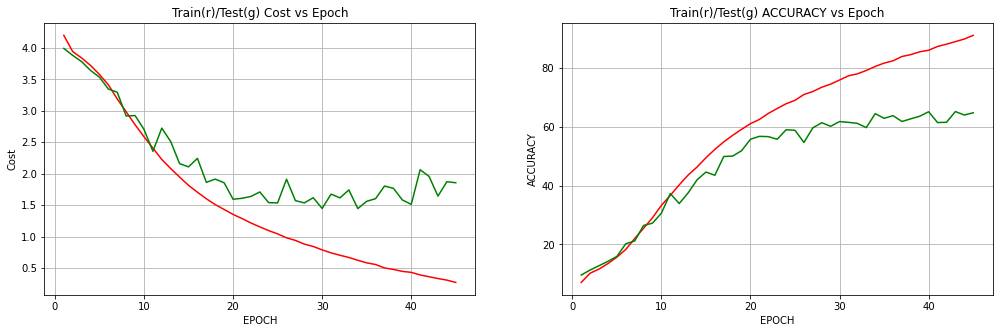

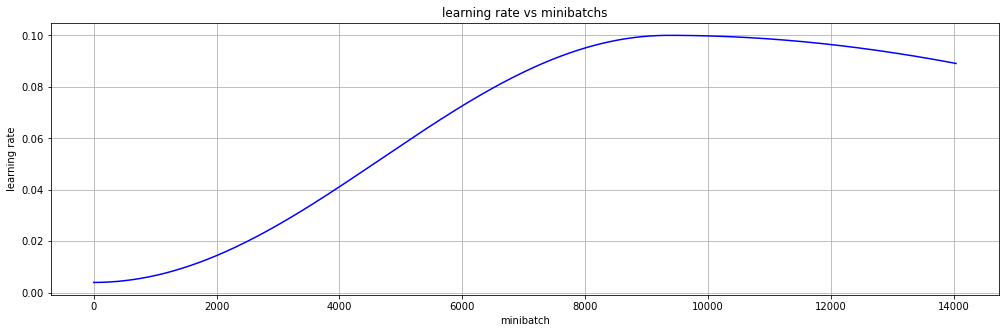

----------------train----------------
Epoch:46/100 batch_idx:103 Train Cost:0.236175
Epoch:46/100 batch_idx:207 Train Cost:0.252647
Epoch:46/100 batch_idx:311 Train Cost:0.263900
Epoch:46/100 batch_idx:311 Train Accuracy:91.174000
----------------test----------------
Epoch:46/100 Test Cost:1.786688 Test Accuracy:66.2300


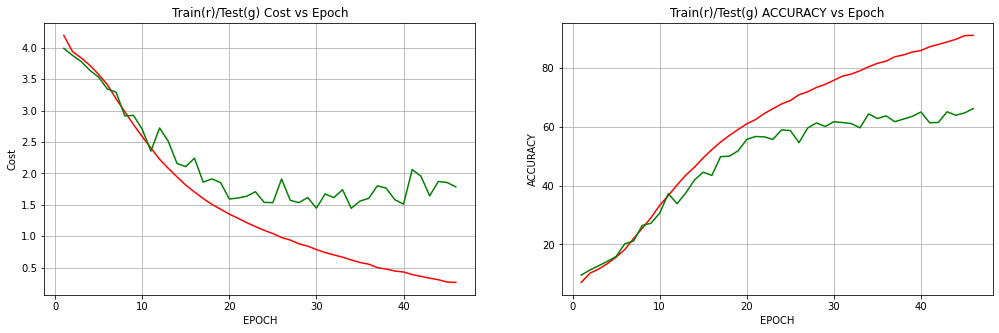

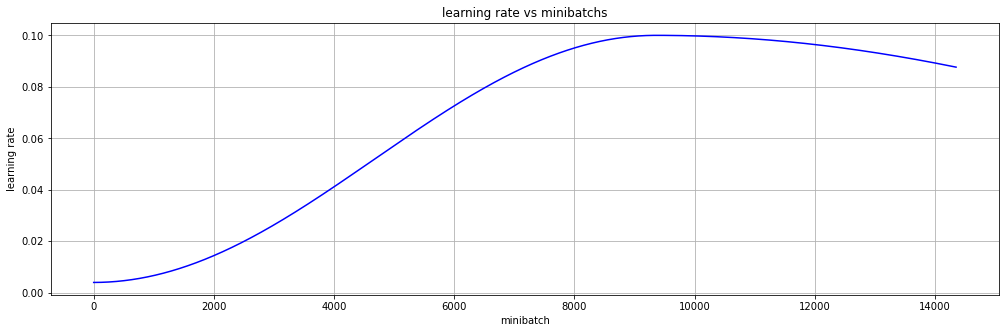

----------------train----------------
Epoch:47/100 batch_idx:103 Train Cost:0.228534
Epoch:47/100 batch_idx:207 Train Cost:0.231291
Epoch:47/100 batch_idx:311 Train Cost:0.248554
Epoch:47/100 batch_idx:311 Train Accuracy:91.774000
----------------test----------------
Epoch:47/100 Test Cost:2.068531 Test Accuracy:63.0400


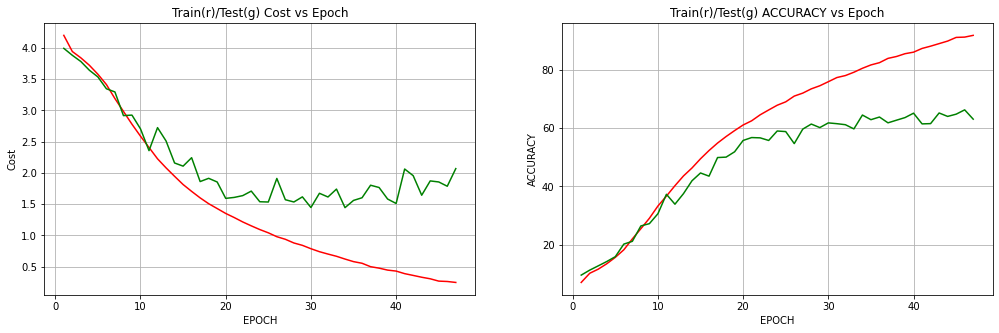

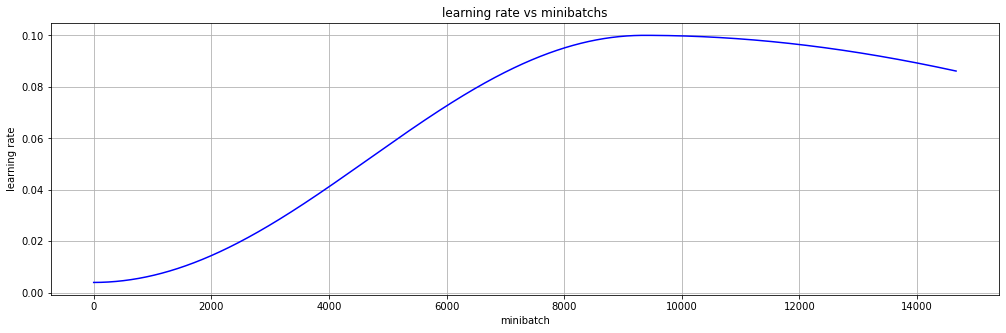

----------------train----------------
Epoch:48/100 batch_idx:103 Train Cost:0.205711
Epoch:48/100 batch_idx:207 Train Cost:0.207175
Epoch:48/100 batch_idx:311 Train Cost:0.220310
Epoch:48/100 batch_idx:311 Train Accuracy:92.572000
----------------test----------------
Epoch:48/100 Test Cost:1.815562 Test Accuracy:65.8400


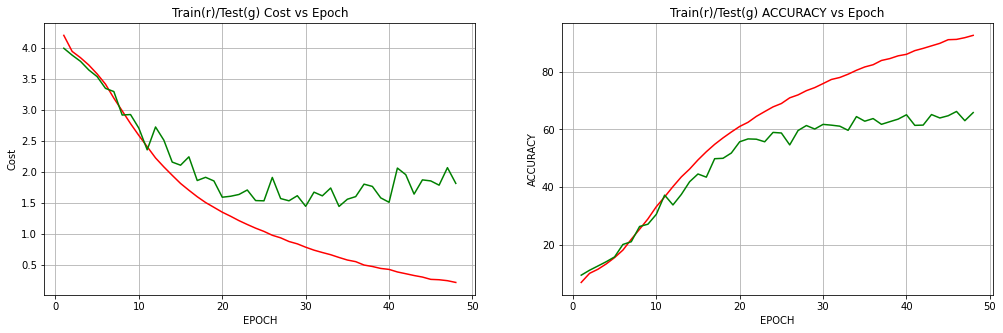

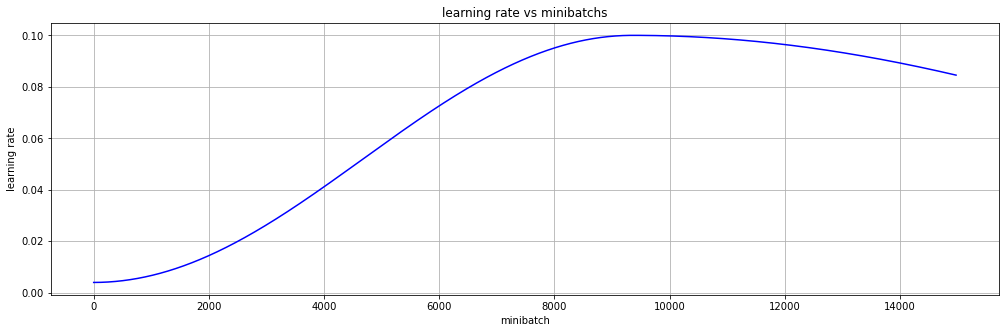

----------------train----------------
Epoch:49/100 batch_idx:103 Train Cost:0.196947
Epoch:49/100 batch_idx:207 Train Cost:0.198442
Epoch:49/100 batch_idx:311 Train Cost:0.204706
Epoch:49/100 batch_idx:311 Train Accuracy:93.072000
----------------test----------------
Epoch:49/100 Test Cost:1.762057 Test Accuracy:65.6900


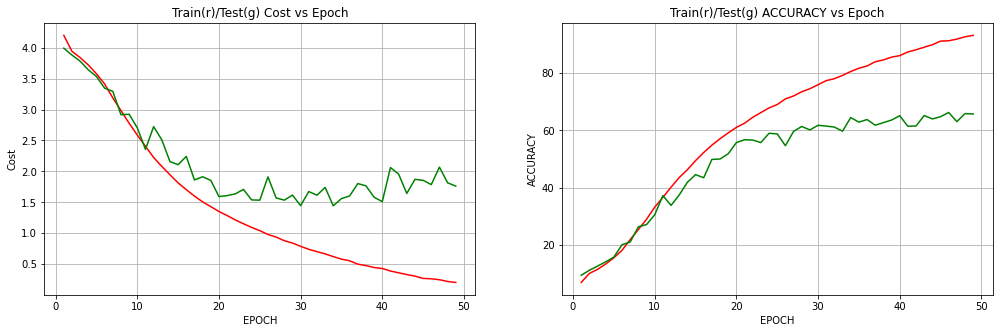

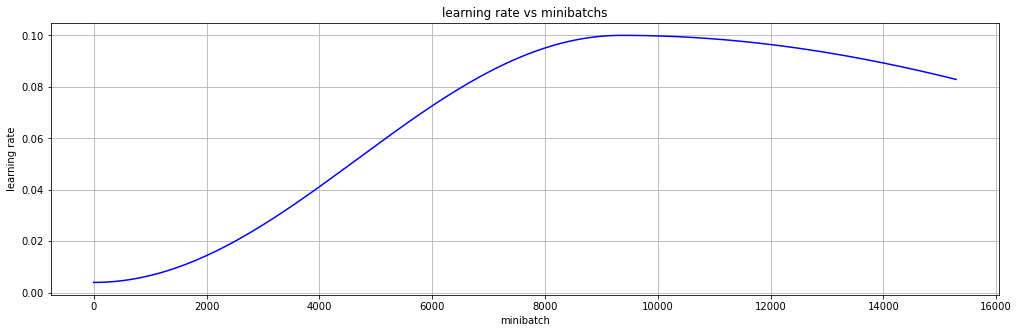

----------------train----------------
Epoch:50/100 batch_idx:103 Train Cost:0.177048
Epoch:50/100 batch_idx:207 Train Cost:0.173553
Epoch:50/100 batch_idx:311 Train Cost:0.194522
Epoch:50/100 batch_idx:311 Train Accuracy:93.530000
----------------test----------------
Epoch:50/100 Test Cost:1.946617 Test Accuracy:64.0600


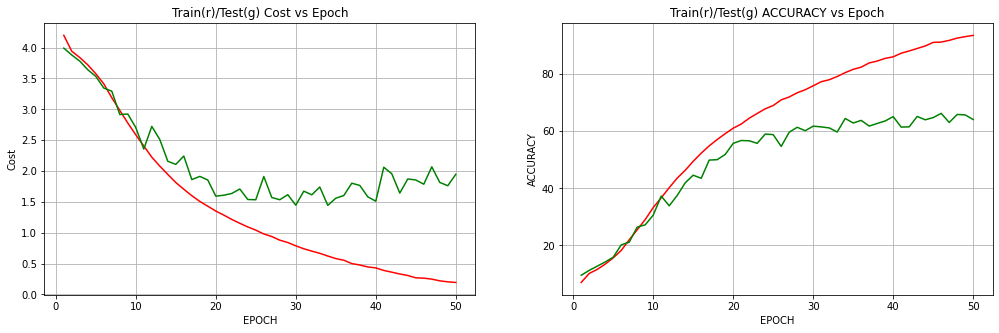

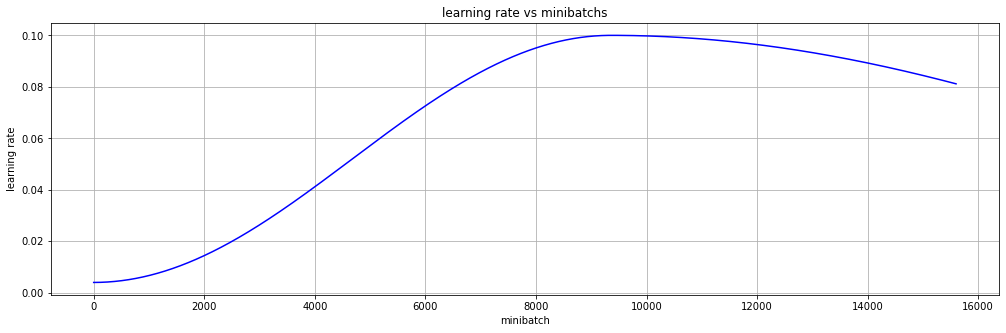

----------------train----------------
Epoch:51/100 batch_idx:103 Train Cost:0.172756
Epoch:51/100 batch_idx:207 Train Cost:0.169851
Epoch:51/100 batch_idx:311 Train Cost:0.169763
Epoch:51/100 batch_idx:311 Train Accuracy:94.286000
----------------test----------------
Epoch:51/100 Test Cost:1.698977 Test Accuracy:67.1500


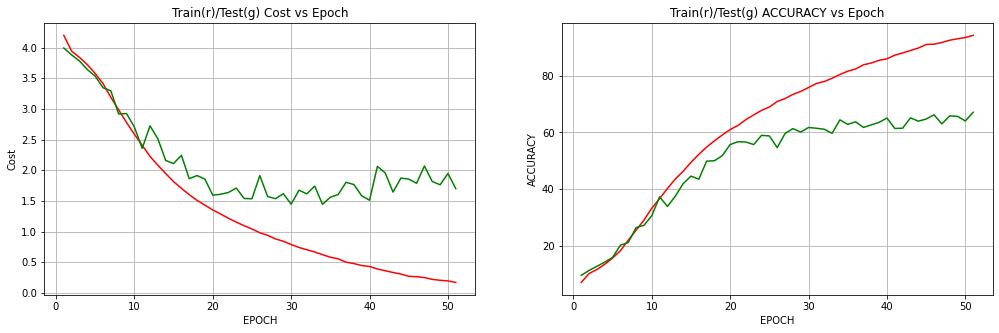

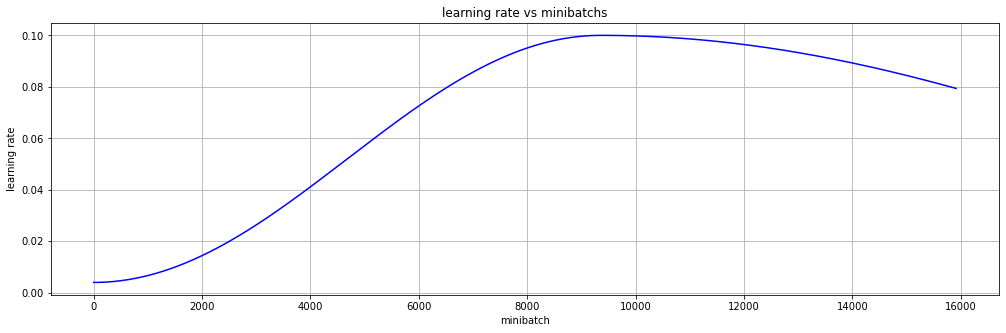

----------------train----------------
Epoch:52/100 batch_idx:103 Train Cost:0.133380
Epoch:52/100 batch_idx:207 Train Cost:0.137100
Epoch:52/100 batch_idx:311 Train Cost:0.143584
Epoch:52/100 batch_idx:311 Train Accuracy:95.138000
----------------test----------------
Epoch:52/100 Test Cost:1.791095 Test Accuracy:66.8200


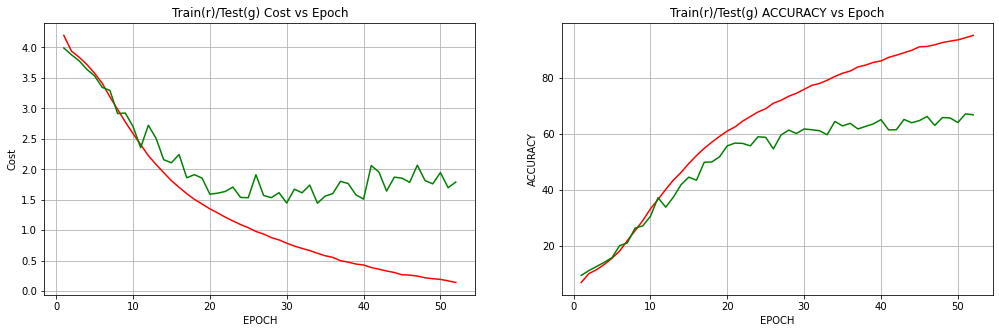

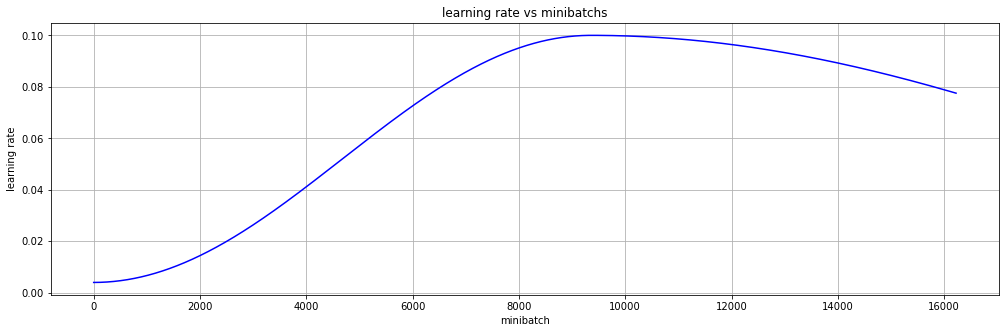

----------------train----------------
Epoch:53/100 batch_idx:103 Train Cost:0.132725
Epoch:53/100 batch_idx:207 Train Cost:0.139353
Epoch:53/100 batch_idx:311 Train Cost:0.139885
Epoch:53/100 batch_idx:311 Train Accuracy:95.326000
----------------test----------------
Epoch:53/100 Test Cost:1.705468 Test Accuracy:67.9500


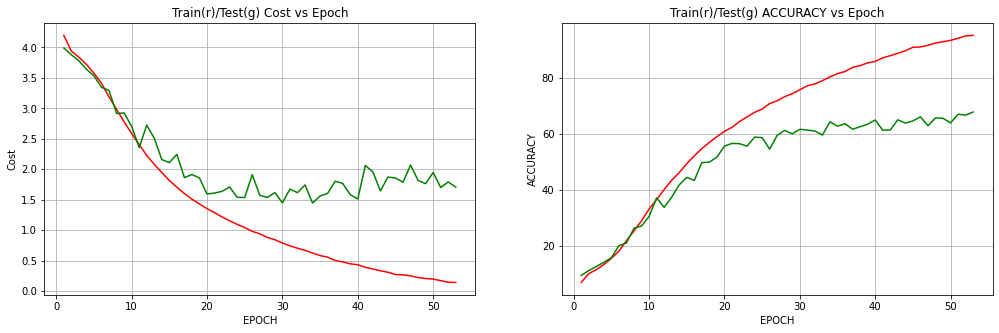

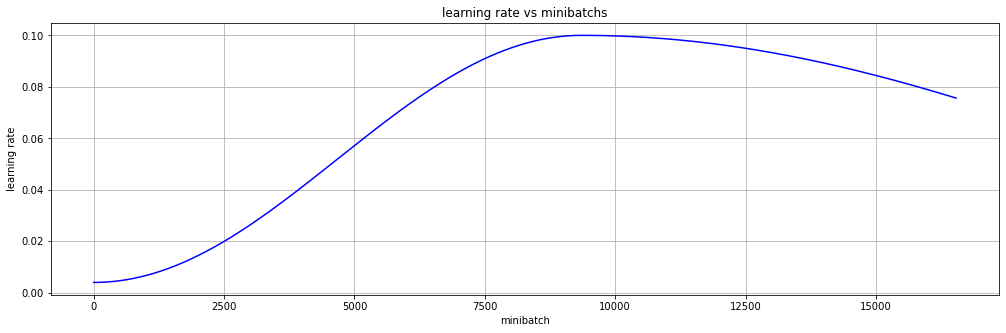

----------------train----------------
Epoch:54/100 batch_idx:103 Train Cost:0.122285
Epoch:54/100 batch_idx:207 Train Cost:0.126974
Epoch:54/100 batch_idx:311 Train Cost:0.134770
Epoch:54/100 batch_idx:311 Train Accuracy:95.492000
----------------test----------------
Epoch:54/100 Test Cost:1.774660 Test Accuracy:67.8200


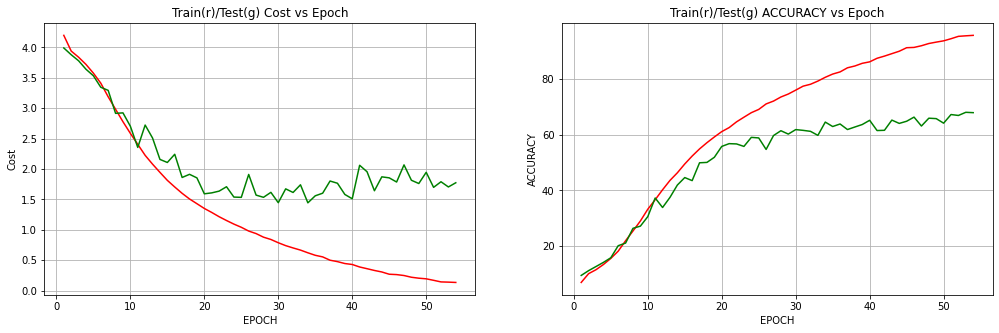

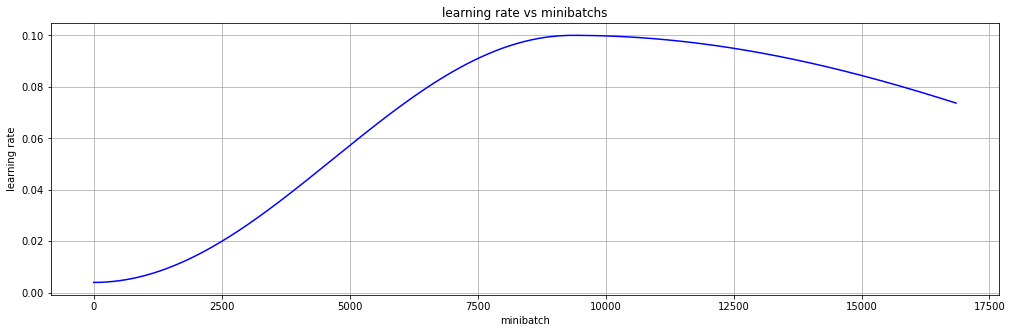

----------------train----------------
Epoch:55/100 batch_idx:103 Train Cost:0.108374
Epoch:55/100 batch_idx:207 Train Cost:0.115836
Epoch:55/100 batch_idx:311 Train Cost:0.124130
Epoch:55/100 batch_idx:311 Train Accuracy:95.840000
----------------test----------------
Epoch:55/100 Test Cost:2.056181 Test Accuracy:67.0100


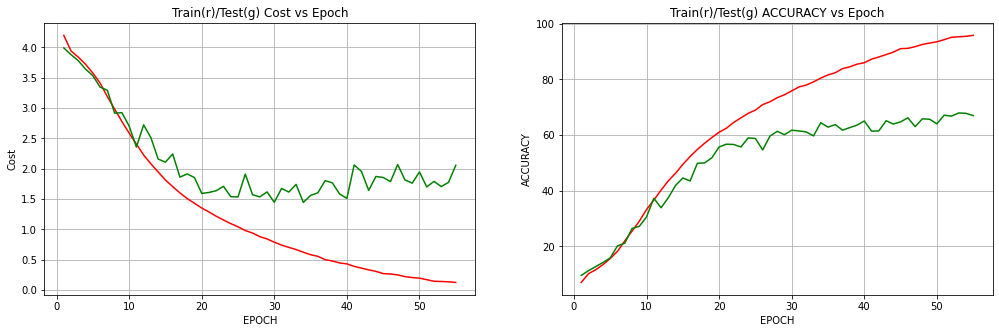

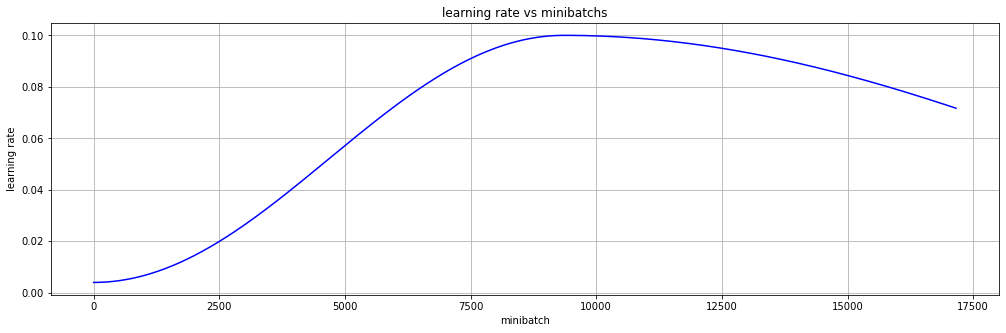

----------------train----------------
Epoch:56/100 batch_idx:103 Train Cost:0.095688
Epoch:56/100 batch_idx:207 Train Cost:0.096047
Epoch:56/100 batch_idx:311 Train Cost:0.100728
Epoch:56/100 batch_idx:311 Train Accuracy:96.680000
----------------test----------------
Epoch:56/100 Test Cost:1.857581 Test Accuracy:68.1100


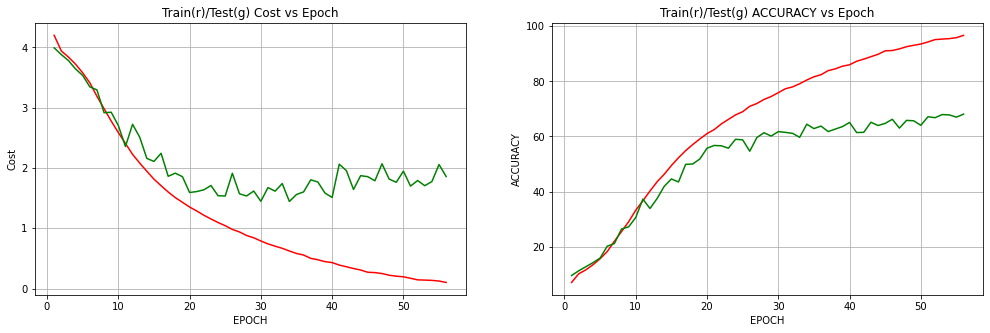

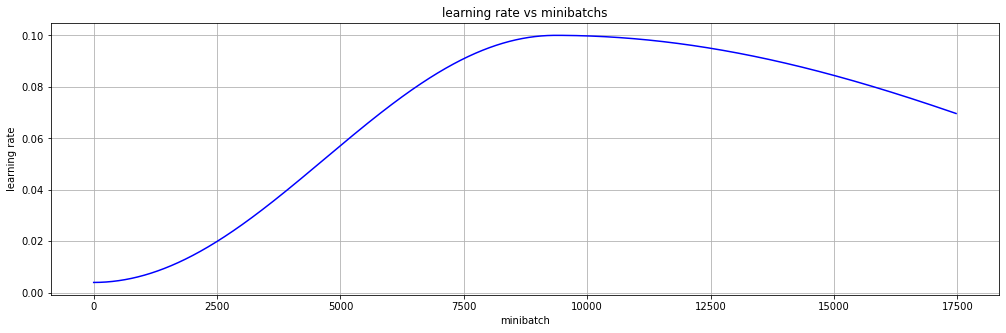

----------------train----------------
Epoch:57/100 batch_idx:103 Train Cost:0.074781
Epoch:57/100 batch_idx:207 Train Cost:0.083306
Epoch:57/100 batch_idx:311 Train Cost:0.087294
Epoch:57/100 batch_idx:311 Train Accuracy:97.140000
----------------test----------------
Epoch:57/100 Test Cost:1.855482 Test Accuracy:68.5800


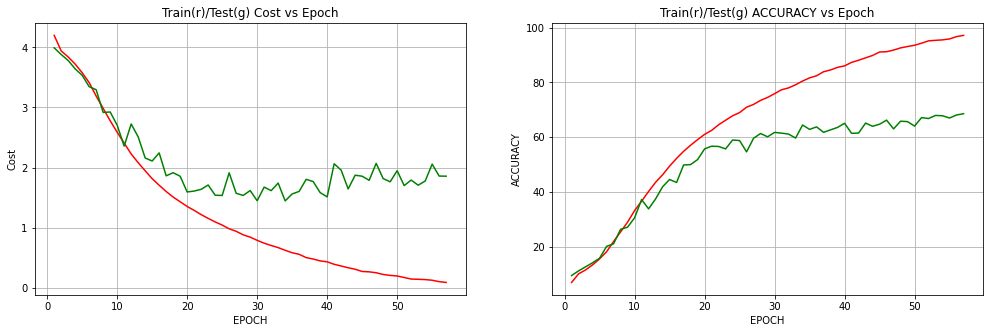

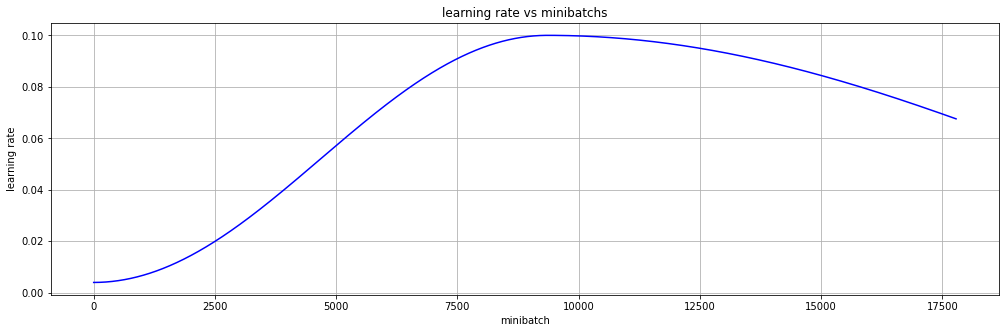

----------------train----------------
Epoch:58/100 batch_idx:103 Train Cost:0.076774
Epoch:58/100 batch_idx:207 Train Cost:0.083213
Epoch:58/100 batch_idx:311 Train Cost:0.091450
Epoch:58/100 batch_idx:311 Train Accuracy:96.938000
----------------test----------------
Epoch:58/100 Test Cost:1.786422 Test Accuracy:68.8500


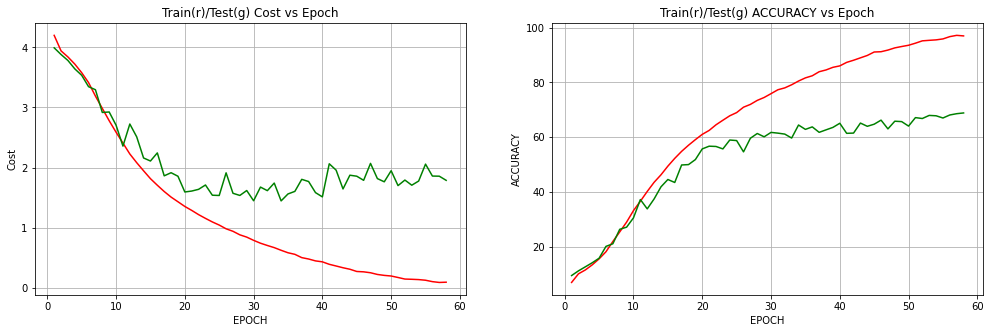

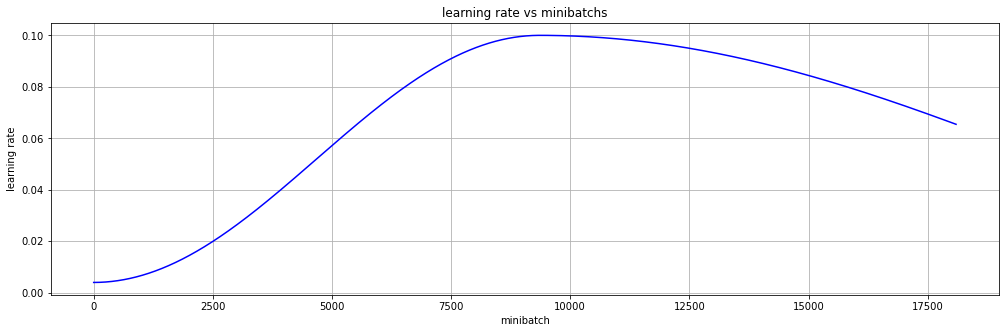

----------------train----------------
Epoch:59/100 batch_idx:103 Train Cost:0.074310
Epoch:59/100 batch_idx:207 Train Cost:0.070742
Epoch:59/100 batch_idx:311 Train Cost:0.074618
Epoch:59/100 batch_idx:311 Train Accuracy:97.508000
----------------test----------------
Epoch:59/100 Test Cost:1.949504 Test Accuracy:68.3400


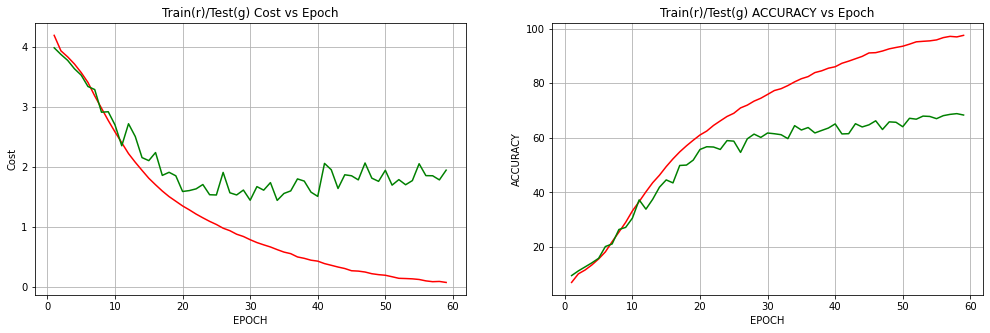

----------------train----------------
Epoch:60/100 batch_idx:103 Train Cost:0.056148
Epoch:60/100 batch_idx:207 Train Cost:0.058149
Epoch:60/100 batch_idx:311 Train Cost:0.060076
Epoch:60/100 batch_idx:311 Train Accuracy:98.096000
----------------test----------------
Epoch:60/100 Test Cost:1.842516 Test Accuracy:69.0800


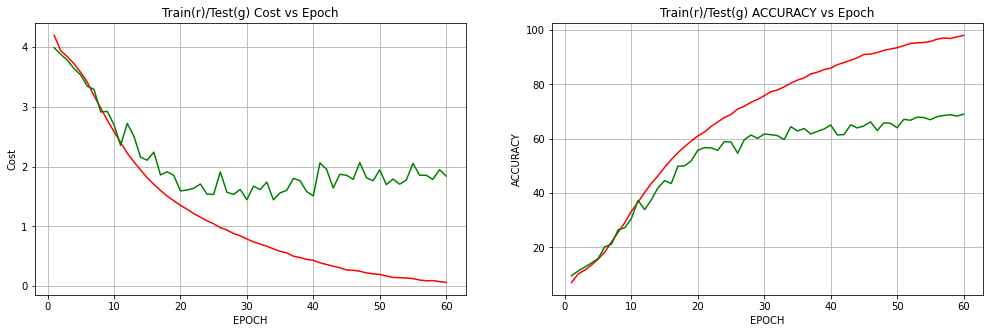

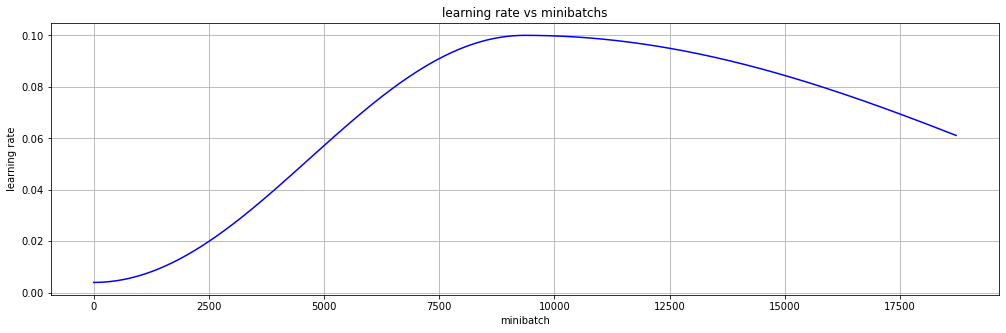

----------------train----------------
Epoch:61/100 batch_idx:103 Train Cost:0.058317
Epoch:61/100 batch_idx:207 Train Cost:0.059616
Epoch:61/100 batch_idx:311 Train Cost:0.058141
Epoch:61/100 batch_idx:311 Train Accuracy:98.104000
----------------test----------------
Epoch:61/100 Test Cost:1.831657 Test Accuracy:69.4700


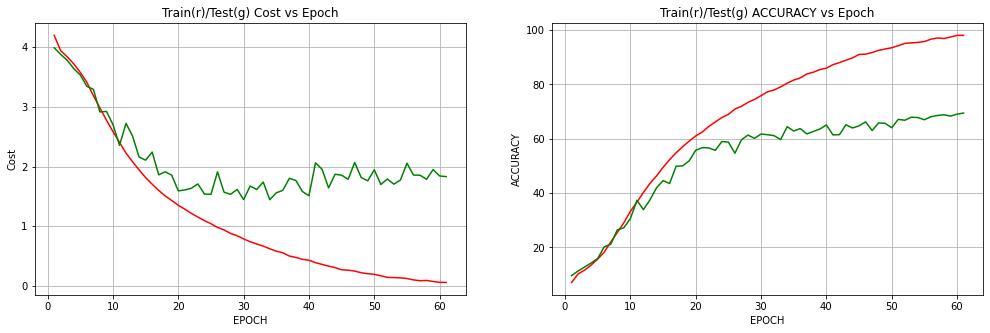

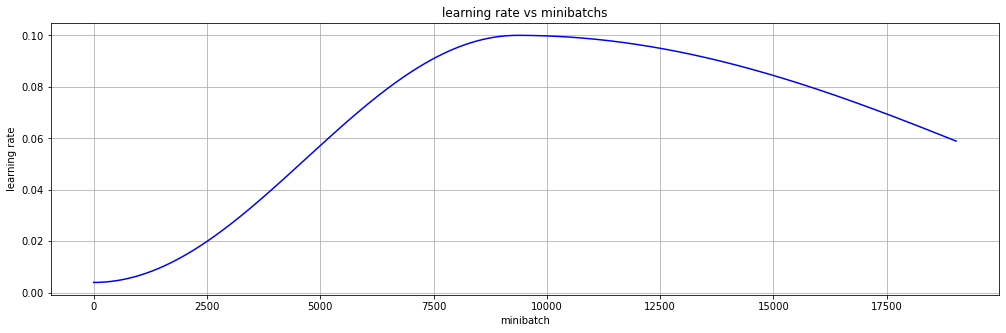

----------------train----------------
Epoch:62/100 batch_idx:103 Train Cost:0.058259
Epoch:62/100 batch_idx:207 Train Cost:0.057912
Epoch:62/100 batch_idx:311 Train Cost:0.057428
Epoch:62/100 batch_idx:311 Train Accuracy:98.172000
----------------test----------------
Epoch:62/100 Test Cost:1.891951 Test Accuracy:69.2400


----------------train----------------
Epoch:63/100 batch_idx:103 Train Cost:0.044190
Epoch:63/100 batch_idx:207 Train Cost:0.043061
Epoch:63/100 batch_idx:311 Train Cost:0.042285
Epoch:63/100 batch_idx:311 Train Accuracy:98.600000
----------------test----------------
Epoch:63/100 Test Cost:1.876066 Test Accuracy:70.0000


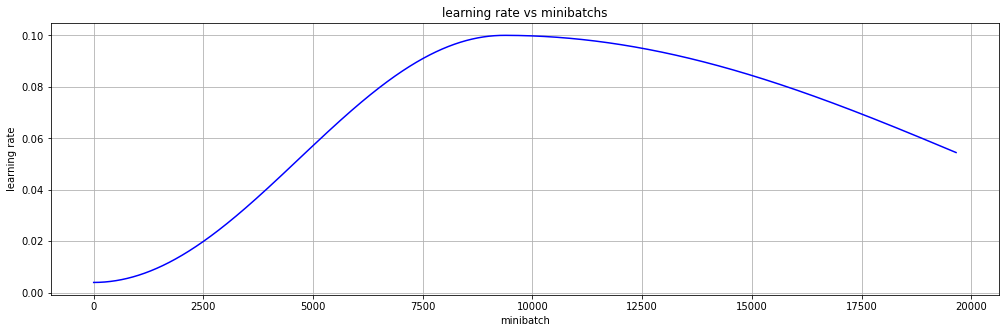

----------------train----------------
Epoch:64/100 batch_idx:103 Train Cost:0.037538
Epoch:64/100 batch_idx:207 Train Cost:0.033702
Epoch:64/100 batch_idx:311 Train Cost:0.034046
Epoch:64/100 batch_idx:311 Train Accuracy:98.940000
----------------test----------------
Epoch:64/100 Test Cost:1.794214 Test Accuracy:70.2800


----------------train----------------
Epoch:65/100 batch_idx:103 Train Cost:0.028384
Epoch:65/100 batch_idx:207 Train Cost:0.027693
Epoch:65/100 batch_idx:311 Train Cost:0.027529
Epoch:65/100 batch_idx:311 Train Accuracy:99.094000
----------------test----------------
Epoch:65/100 Test Cost:1.798233 Test Accuracy:71.2600


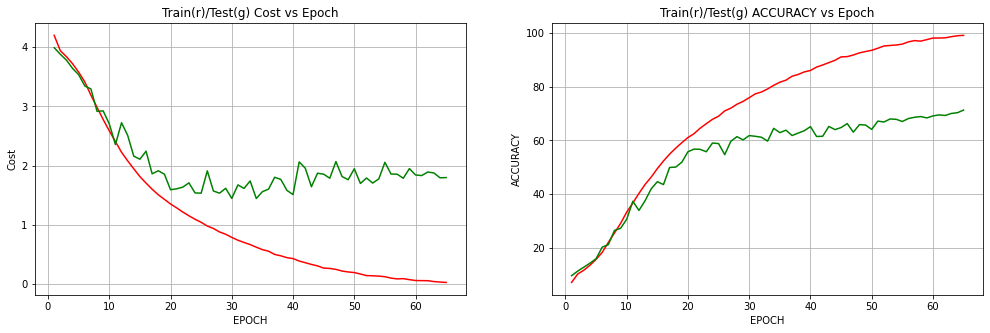

----------------train----------------
Epoch:66/100 batch_idx:103 Train Cost:0.026095
Epoch:66/100 batch_idx:207 Train Cost:0.024284
Epoch:66/100 batch_idx:311 Train Cost:0.023487
Epoch:66/100 batch_idx:311 Train Accuracy:99.290000
----------------test----------------
Epoch:66/100 Test Cost:1.802786 Test Accuracy:70.7200


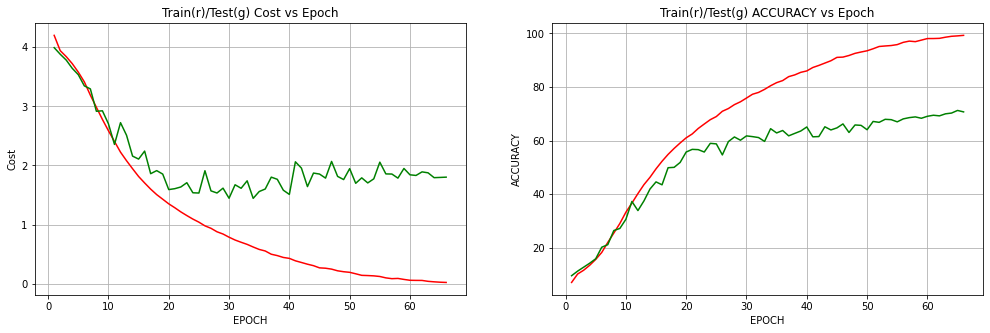

----------------train----------------
Epoch:67/100 batch_idx:103 Train Cost:0.015009
Epoch:67/100 batch_idx:207 Train Cost:0.015645
Epoch:67/100 batch_idx:311 Train Cost:0.016640
Epoch:67/100 batch_idx:311 Train Accuracy:99.494000
----------------test----------------
Epoch:67/100 Test Cost:1.848918 Test Accuracy:71.5900


----------------train----------------
Epoch:68/100 batch_idx:103 Train Cost:0.011617
Epoch:68/100 batch_idx:207 Train Cost:0.012519
Epoch:68/100 batch_idx:311 Train Cost:0.013847
Epoch:68/100 batch_idx:311 Train Accuracy:99.554000
----------------test----------------
Epoch:68/100 Test Cost:1.781487 Test Accuracy:71.7700


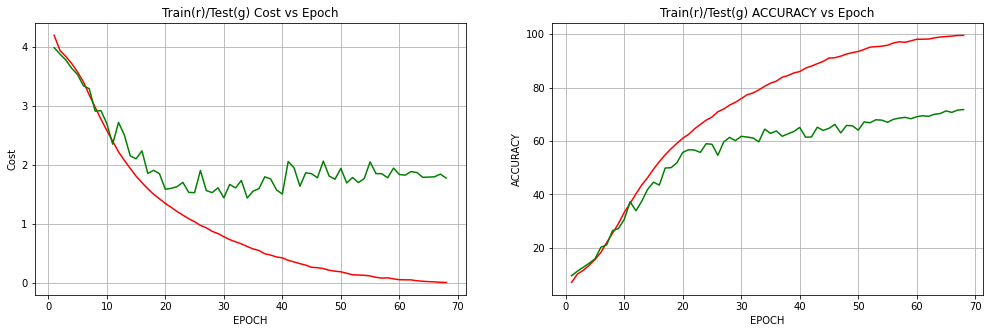

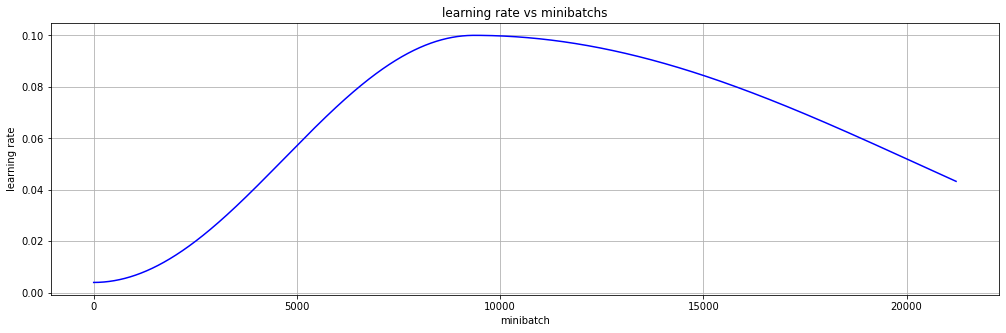

----------------train----------------
Epoch:69/100 batch_idx:103 Train Cost:0.011171
Epoch:69/100 batch_idx:207 Train Cost:0.013208
Epoch:69/100 batch_idx:311 Train Cost:0.012746
Epoch:69/100 batch_idx:311 Train Accuracy:99.564000
----------------test----------------
Epoch:69/100 Test Cost:1.819300 Test Accuracy:71.7900


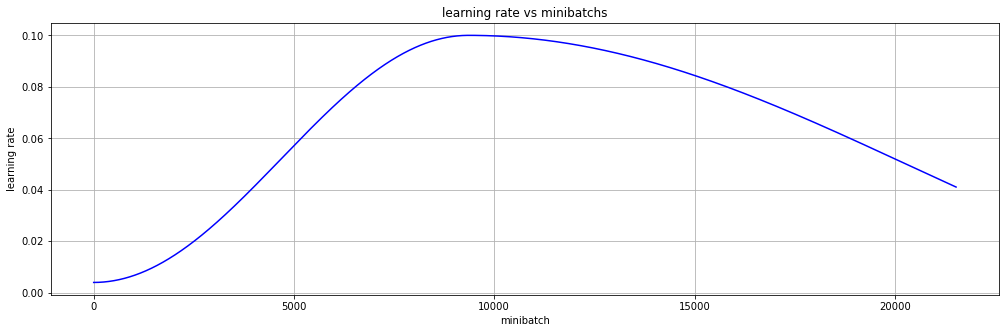

----------------train----------------
Epoch:70/100 batch_idx:103 Train Cost:0.009149
Epoch:70/100 batch_idx:207 Train Cost:0.008622
Epoch:70/100 batch_idx:311 Train Cost:0.008641
Epoch:70/100 batch_idx:311 Train Accuracy:99.700000
----------------test----------------
Epoch:70/100 Test Cost:1.803805 Test Accuracy:72.2100


----------------train----------------
Epoch:71/100 batch_idx:103 Train Cost:0.007121
Epoch:71/100 batch_idx:207 Train Cost:0.007899
Epoch:71/100 batch_idx:311 Train Cost:0.008364
Epoch:71/100 batch_idx:311 Train Accuracy:99.692000
----------------test----------------
Epoch:71/100 Test Cost:1.786677 Test Accuracy:72.4700


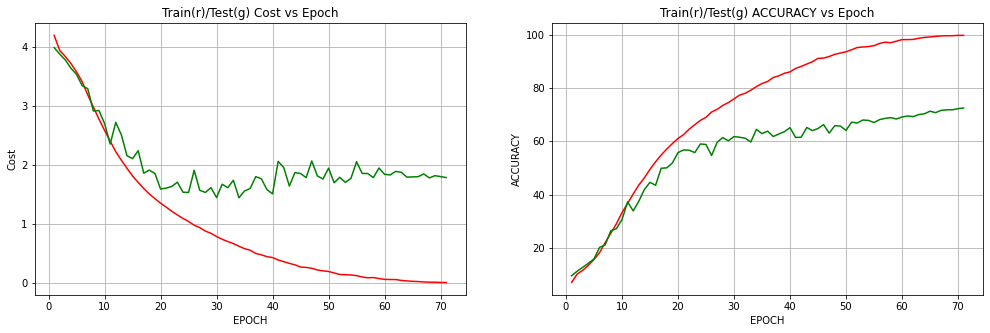

----------------train----------------
Epoch:72/100 batch_idx:103 Train Cost:0.007741
Epoch:72/100 batch_idx:207 Train Cost:0.007444
Epoch:72/100 batch_idx:311 Train Cost:0.007663
Epoch:72/100 batch_idx:311 Train Accuracy:99.698000
----------------test----------------
Epoch:72/100 Test Cost:1.816773 Test Accuracy:71.7100


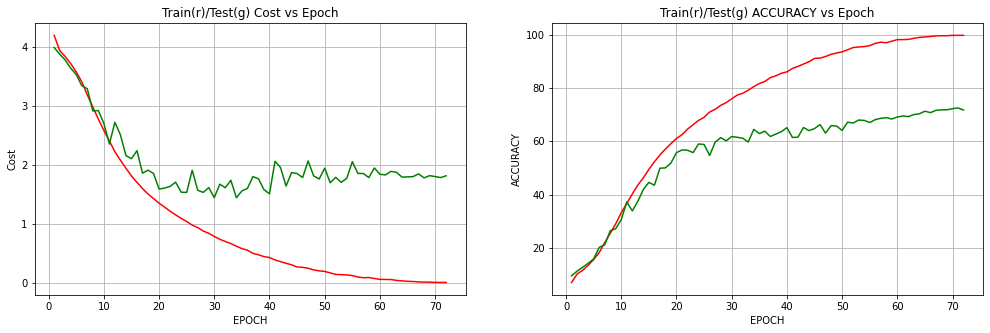

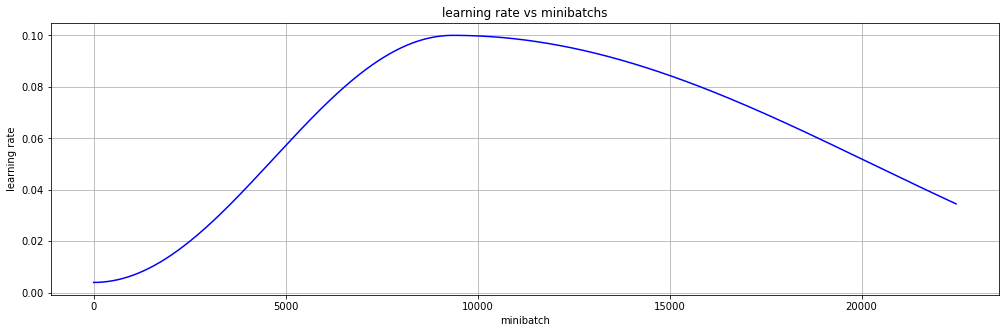

----------------train----------------
Epoch:73/100 batch_idx:103 Train Cost:0.007536
Epoch:73/100 batch_idx:207 Train Cost:0.007375
Epoch:73/100 batch_idx:311 Train Cost:0.006880
Epoch:73/100 batch_idx:311 Train Accuracy:99.736000
----------------test----------------
Epoch:73/100 Test Cost:1.831425 Test Accuracy:72.2800


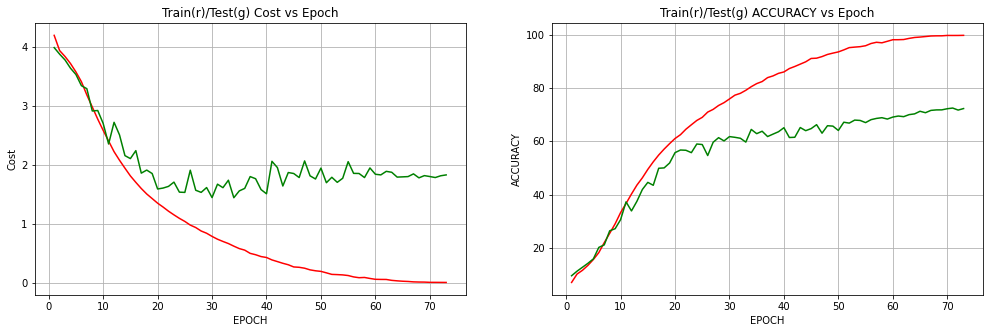

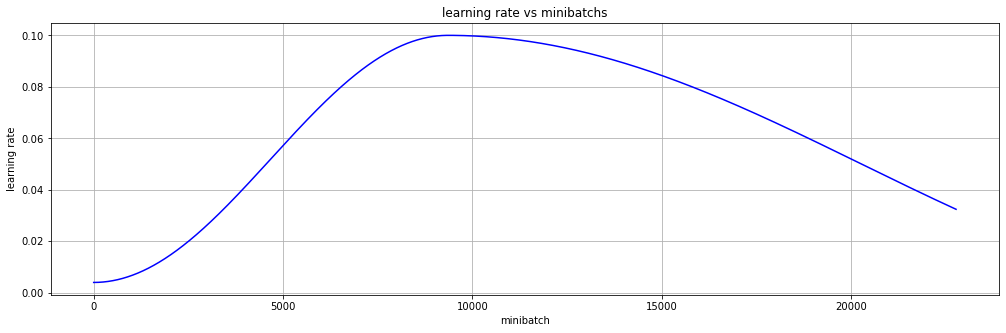

----------------train----------------
Epoch:74/100 batch_idx:103 Train Cost:0.004307
Epoch:74/100 batch_idx:207 Train Cost:0.005444
Epoch:74/100 batch_idx:311 Train Cost:0.005391
Epoch:74/100 batch_idx:311 Train Accuracy:99.766000
----------------test----------------
Epoch:74/100 Test Cost:1.792022 Test Accuracy:72.5800


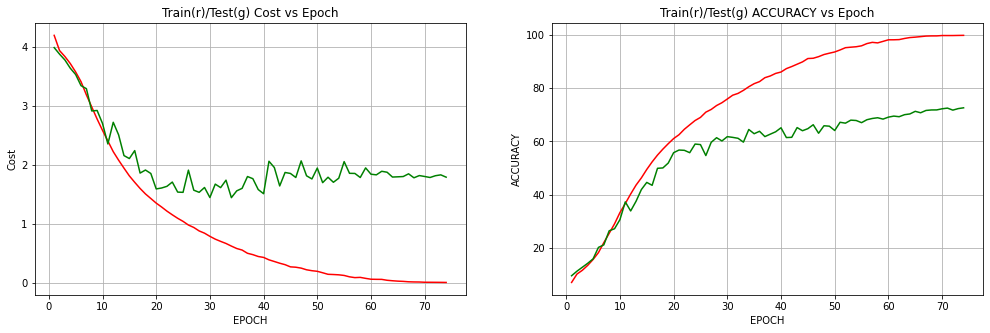

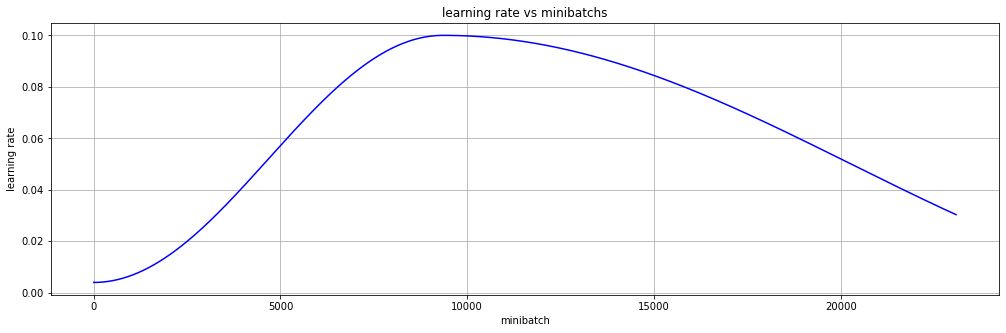

----------------train----------------
Epoch:75/100 batch_idx:103 Train Cost:0.004259
Epoch:75/100 batch_idx:207 Train Cost:0.004820
Epoch:75/100 batch_idx:311 Train Cost:0.004691
Epoch:75/100 batch_idx:311 Train Accuracy:99.776000
----------------test----------------
Epoch:75/100 Test Cost:1.799495 Test Accuracy:72.5800


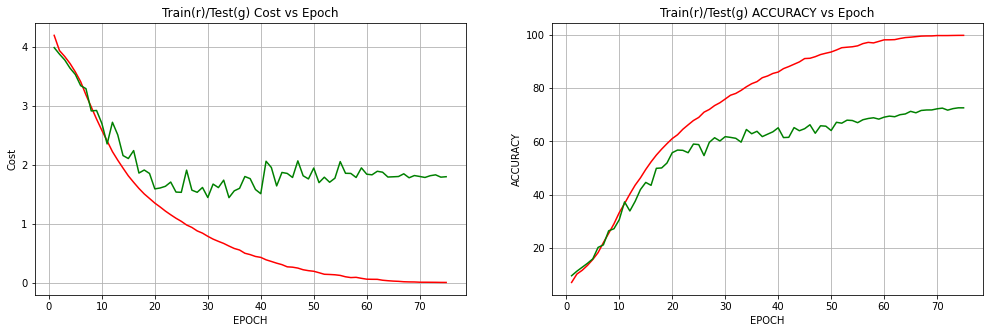

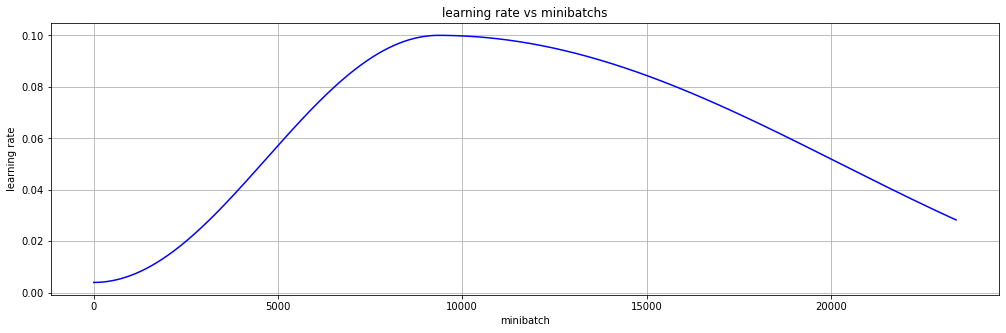

----------------train----------------
Epoch:76/100 batch_idx:103 Train Cost:0.003688
Epoch:76/100 batch_idx:207 Train Cost:0.003880
Epoch:76/100 batch_idx:311 Train Cost:0.004113
Epoch:76/100 batch_idx:311 Train Accuracy:99.782000
----------------test----------------
Epoch:76/100 Test Cost:1.806913 Test Accuracy:72.4200


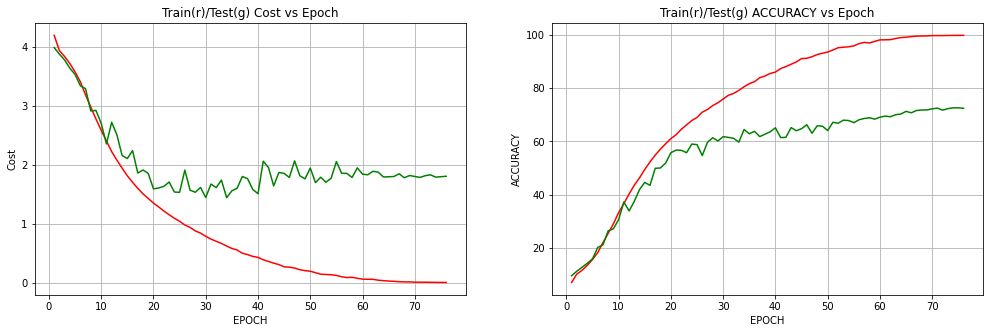

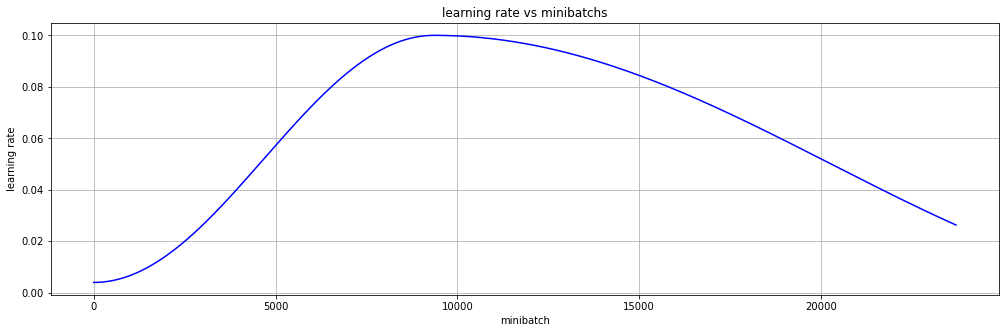

----------------train----------------
Epoch:77/100 batch_idx:103 Train Cost:0.004671
Epoch:77/100 batch_idx:207 Train Cost:0.004840
Epoch:77/100 batch_idx:311 Train Cost:0.004519
Epoch:77/100 batch_idx:311 Train Accuracy:99.764000
----------------test----------------
Epoch:77/100 Test Cost:1.789570 Test Accuracy:72.6700


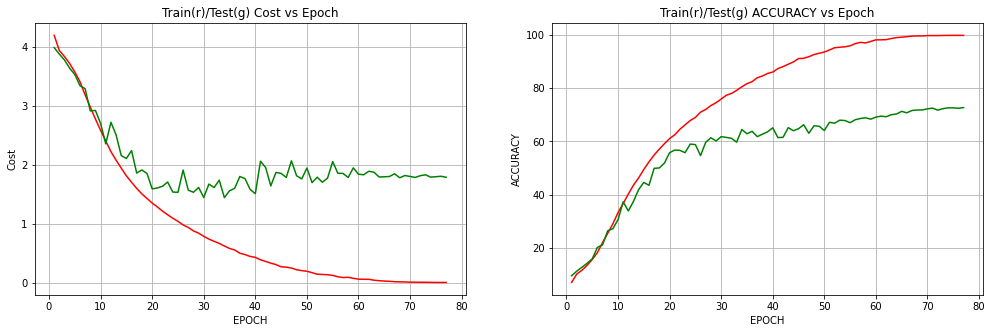

----------------train----------------
Epoch:78/100 batch_idx:103 Train Cost:0.003590
Epoch:78/100 batch_idx:207 Train Cost:0.003527
Epoch:78/100 batch_idx:311 Train Cost:0.003667
Epoch:78/100 batch_idx:311 Train Accuracy:99.788000
----------------test----------------
Epoch:78/100 Test Cost:1.814133 Test Accuracy:72.4400


----------------train----------------
Epoch:79/100 batch_idx:103 Train Cost:0.002508
Epoch:79/100 batch_idx:207 Train Cost:0.002883
Epoch:79/100 batch_idx:311 Train Cost:0.003260
Epoch:79/100 batch_idx:311 Train Accuracy:99.796000
----------------test----------------
Epoch:79/100 Test Cost:1.809560 Test Accuracy:72.6100


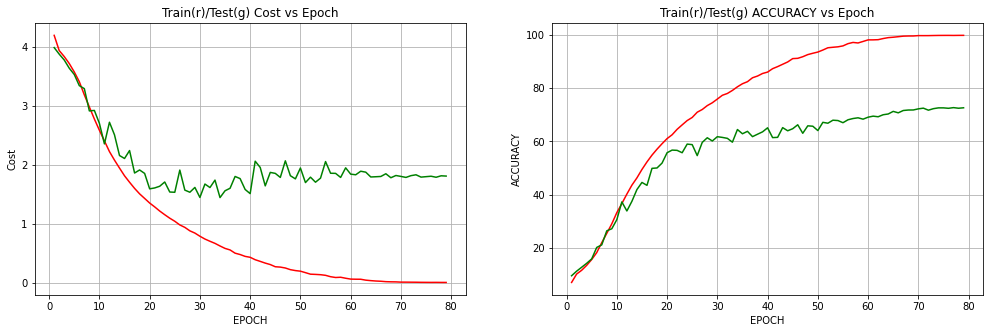

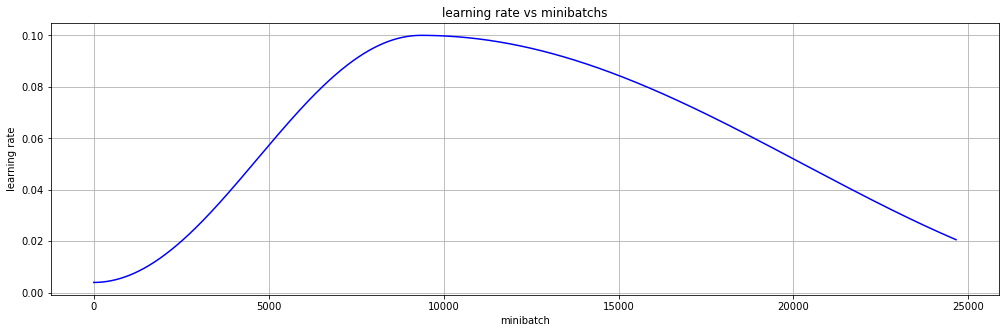

----------------train----------------
Epoch:80/100 batch_idx:103 Train Cost:0.003974
Epoch:80/100 batch_idx:207 Train Cost:0.003786
Epoch:80/100 batch_idx:311 Train Cost:0.003688
Epoch:80/100 batch_idx:311 Train Accuracy:99.786000
----------------test----------------
Epoch:80/100 Test Cost:1.802708 Test Accuracy:72.5500


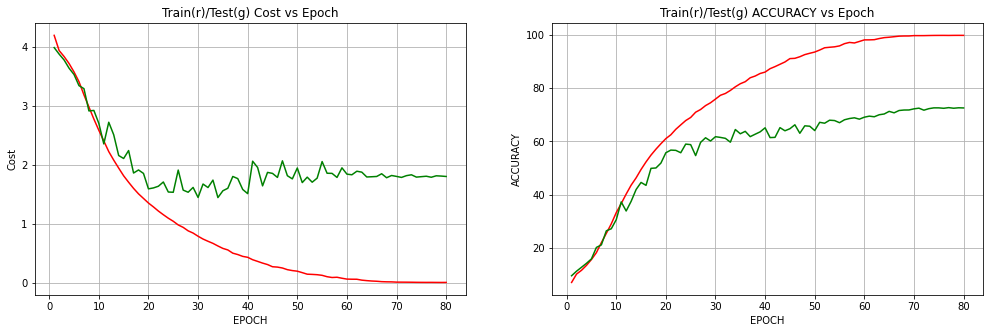

----------------train----------------
Epoch:81/100 batch_idx:103 Train Cost:0.003247
Epoch:81/100 batch_idx:207 Train Cost:0.003257
Epoch:81/100 batch_idx:311 Train Cost:0.002986
Epoch:81/100 batch_idx:311 Train Accuracy:99.800000
----------------test----------------
Epoch:81/100 Test Cost:1.800126 Test Accuracy:72.6300


----------------train----------------
Epoch:82/100 batch_idx:103 Train Cost:0.002134
Epoch:82/100 batch_idx:207 Train Cost:0.002459
Epoch:82/100 batch_idx:311 Train Cost:0.002547
Epoch:82/100 batch_idx:311 Train Accuracy:99.812000
----------------test----------------
Epoch:82/100 Test Cost:1.790304 Test Accuracy:72.7900


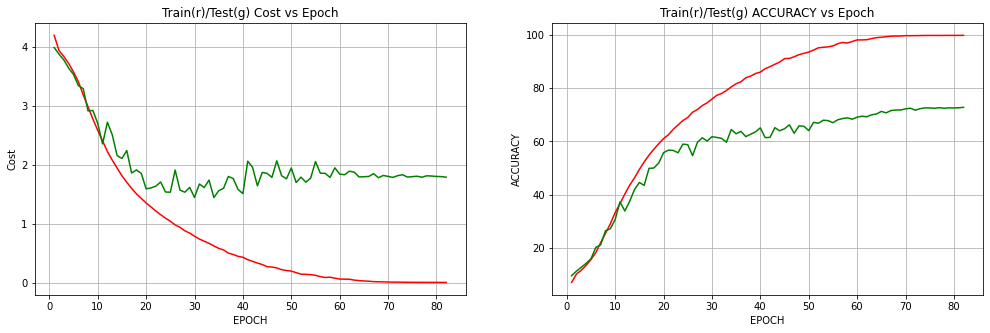

----------------train----------------
Epoch:83/100 batch_idx:103 Train Cost:0.002212
Epoch:83/100 batch_idx:207 Train Cost:0.002459
Epoch:83/100 batch_idx:311 Train Cost:0.002723
Epoch:83/100 batch_idx:311 Train Accuracy:99.796000
----------------test----------------
Epoch:83/100 Test Cost:1.827440 Test Accuracy:72.7200


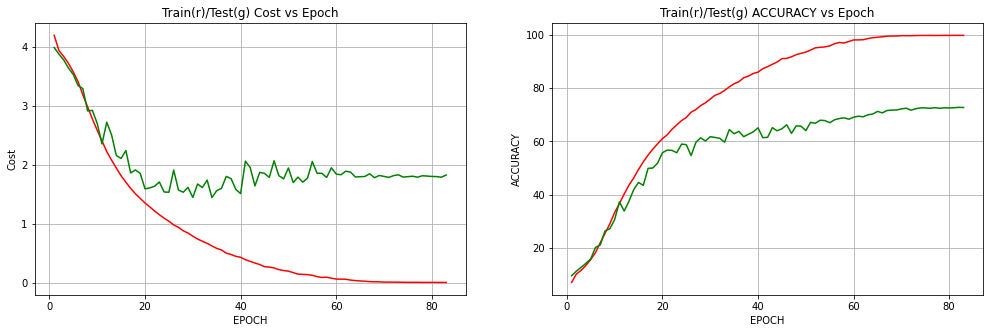

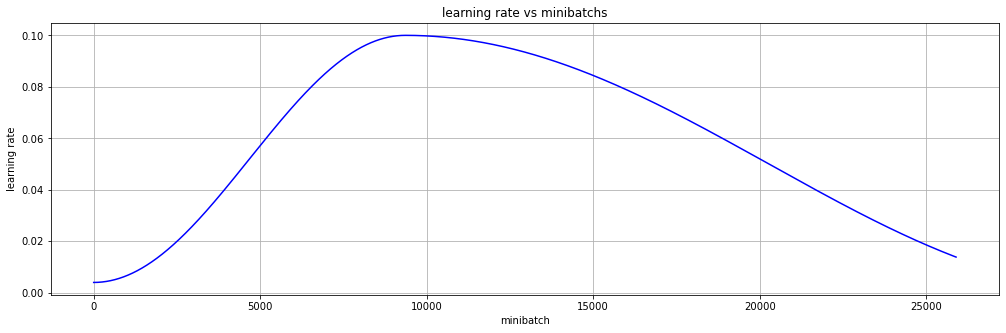

----------------train----------------
Epoch:84/100 batch_idx:103 Train Cost:0.002234
Epoch:84/100 batch_idx:207 Train Cost:0.002232
Epoch:84/100 batch_idx:311 Train Cost:0.002332
Epoch:84/100 batch_idx:311 Train Accuracy:99.806000
----------------test----------------
Epoch:84/100 Test Cost:1.808047 Test Accuracy:72.7400


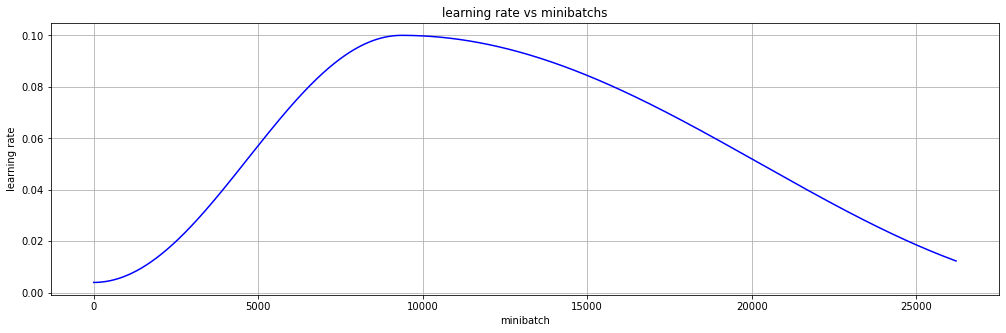

----------------train----------------
Epoch:85/100 batch_idx:103 Train Cost:0.001887
Epoch:85/100 batch_idx:207 Train Cost:0.002167
Epoch:85/100 batch_idx:311 Train Cost:0.002030
Epoch:85/100 batch_idx:311 Train Accuracy:99.816000
----------------test----------------
Epoch:85/100 Test Cost:1.797045 Test Accuracy:72.6700


----------------train----------------
Epoch:86/100 batch_idx:103 Train Cost:0.002522
Epoch:86/100 batch_idx:207 Train Cost:0.002245
Epoch:86/100 batch_idx:311 Train Cost:0.002568
Epoch:86/100 batch_idx:311 Train Accuracy:99.806000
----------------test----------------
Epoch:86/100 Test Cost:1.821668 Test Accuracy:72.6800


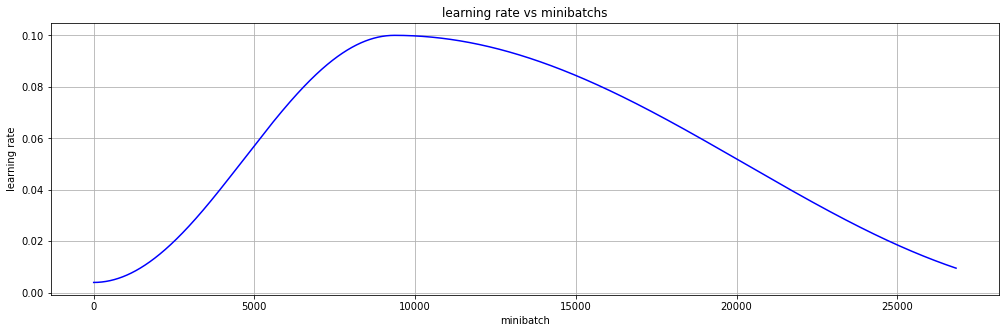

----------------train----------------
Epoch:87/100 batch_idx:103 Train Cost:0.002329
Epoch:87/100 batch_idx:207 Train Cost:0.002315
Epoch:87/100 batch_idx:311 Train Cost:0.002352
Epoch:87/100 batch_idx:311 Train Accuracy:99.804000
----------------test----------------
Epoch:87/100 Test Cost:1.787527 Test Accuracy:73.0700


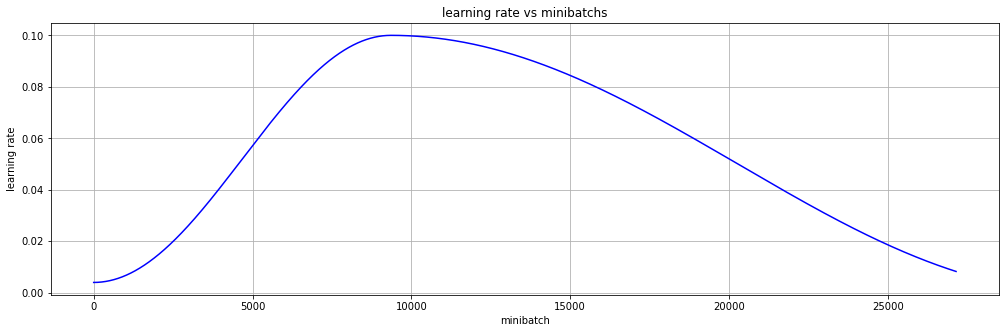

----------------train----------------
Epoch:88/100 batch_idx:103 Train Cost:0.002097
Epoch:88/100 batch_idx:207 Train Cost:0.001881
Epoch:88/100 batch_idx:311 Train Cost:0.001884
Epoch:88/100 batch_idx:311 Train Accuracy:99.816000
----------------test----------------
Epoch:88/100 Test Cost:1.800925 Test Accuracy:73.0200


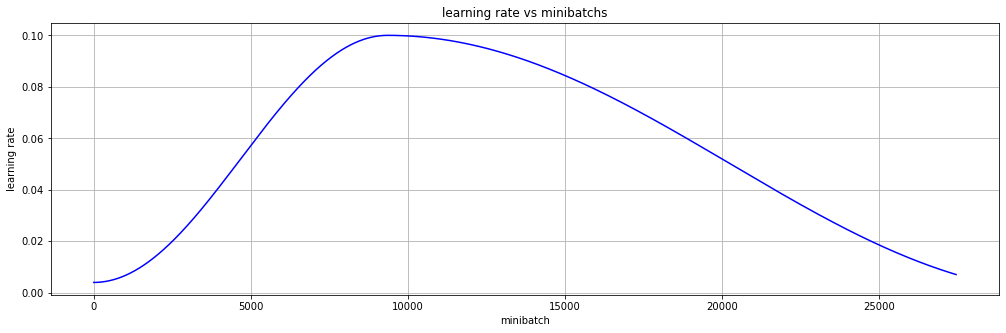

----------------train----------------
Epoch:89/100 batch_idx:103 Train Cost:0.001607
Epoch:89/100 batch_idx:207 Train Cost:0.001650
Epoch:89/100 batch_idx:311 Train Cost:0.001669
Epoch:89/100 batch_idx:311 Train Accuracy:99.810000
----------------test----------------
Epoch:89/100 Test Cost:1.810040 Test Accuracy:72.9100


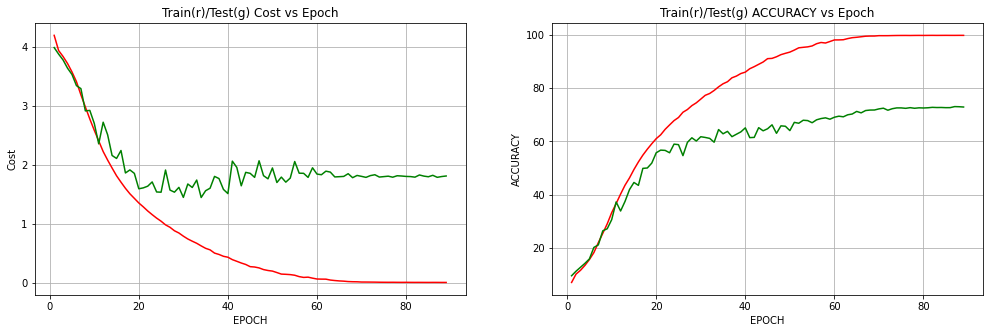

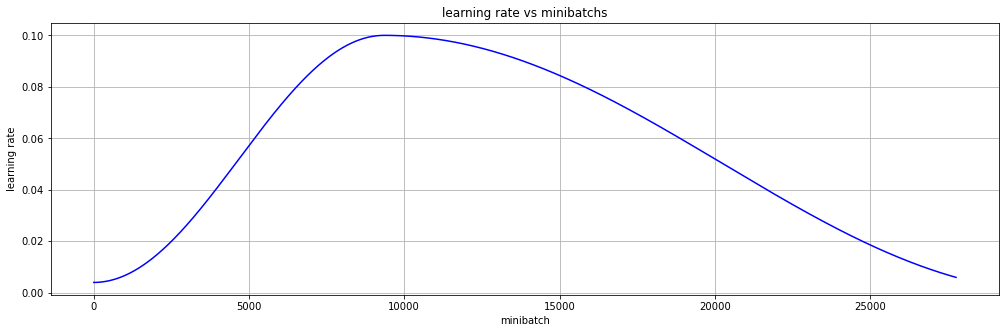

----------------train----------------
Epoch:90/100 batch_idx:103 Train Cost:0.001773
Epoch:90/100 batch_idx:207 Train Cost:0.001926
Epoch:90/100 batch_idx:311 Train Cost:0.001885
Epoch:90/100 batch_idx:311 Train Accuracy:99.808000
----------------test----------------
Epoch:90/100 Test Cost:1.811009 Test Accuracy:72.8800


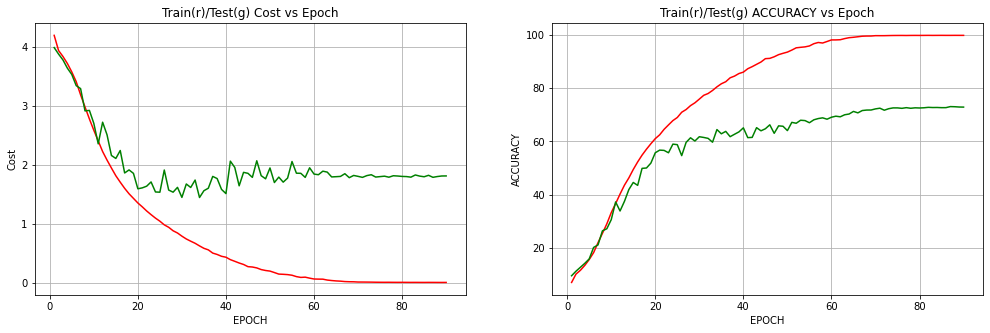

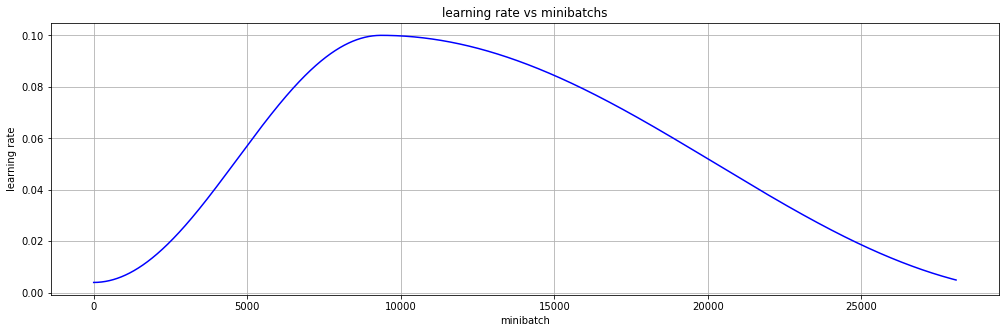

----------------train----------------
Epoch:91/100 batch_idx:103 Train Cost:0.001707
Epoch:91/100 batch_idx:207 Train Cost:0.001818
Epoch:91/100 batch_idx:311 Train Cost:0.001727
Epoch:91/100 batch_idx:311 Train Accuracy:99.814000
----------------test----------------
Epoch:91/100 Test Cost:1.828988 Test Accuracy:72.9200


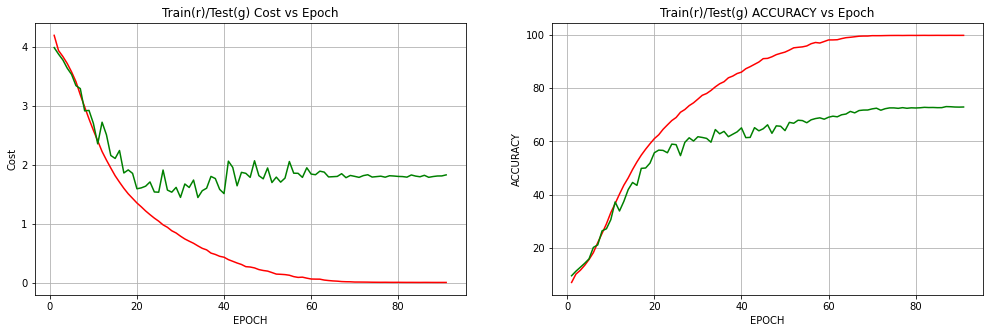

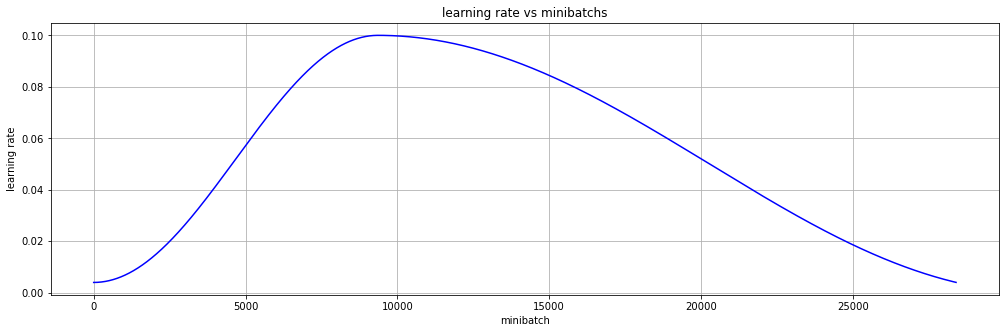

----------------train----------------
Epoch:92/100 batch_idx:103 Train Cost:0.001901
Epoch:92/100 batch_idx:207 Train Cost:0.001741
Epoch:92/100 batch_idx:311 Train Cost:0.001665
Epoch:92/100 batch_idx:311 Train Accuracy:99.804000
----------------test----------------
Epoch:92/100 Test Cost:1.805252 Test Accuracy:72.8800


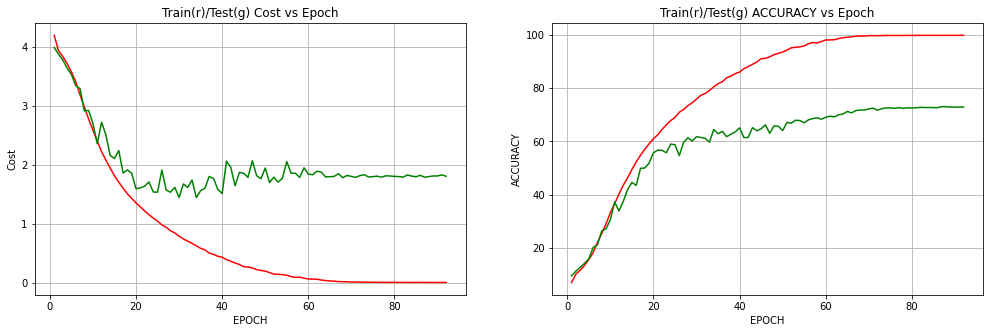

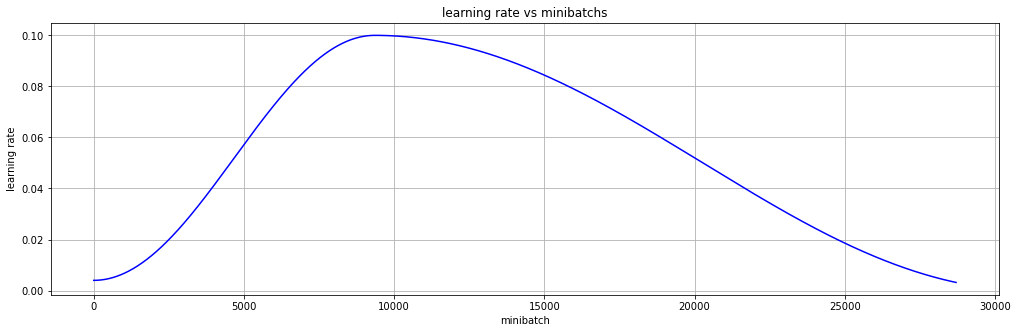

----------------train----------------
Epoch:93/100 batch_idx:103 Train Cost:0.002025
Epoch:93/100 batch_idx:207 Train Cost:0.001796
Epoch:93/100 batch_idx:311 Train Cost:0.001791
Epoch:93/100 batch_idx:311 Train Accuracy:99.810000
----------------test----------------
Epoch:93/100 Test Cost:1.799083 Test Accuracy:72.8400


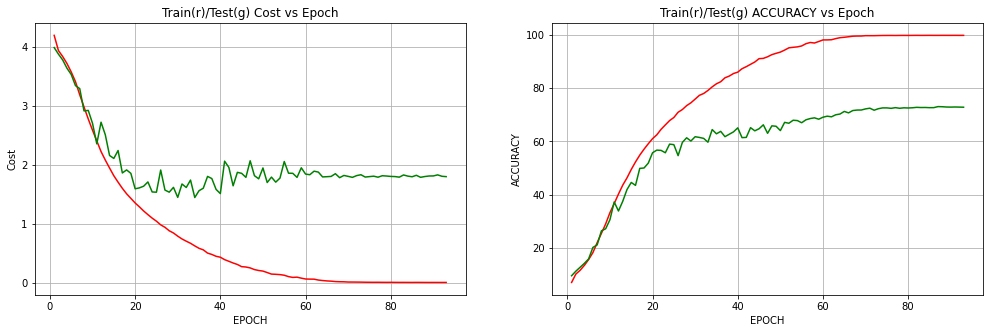

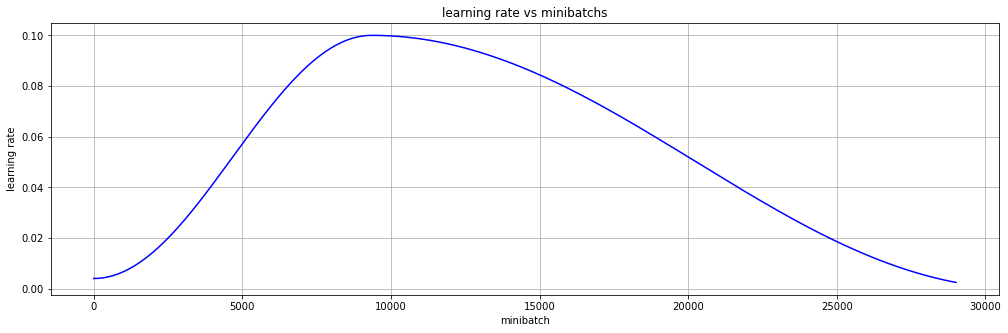

----------------train----------------
Epoch:94/100 batch_idx:103 Train Cost:0.001285
Epoch:94/100 batch_idx:207 Train Cost:0.001534
Epoch:94/100 batch_idx:311 Train Cost:0.001646
Epoch:94/100 batch_idx:311 Train Accuracy:99.816000
----------------test----------------
Epoch:94/100 Test Cost:1.800014 Test Accuracy:72.8800


----------------train----------------
Epoch:95/100 batch_idx:103 Train Cost:0.001512
Epoch:95/100 batch_idx:207 Train Cost:0.001462
Epoch:95/100 batch_idx:311 Train Cost:0.001531
Epoch:95/100 batch_idx:311 Train Accuracy:99.822000
----------------test----------------
Epoch:95/100 Test Cost:1.808957 Test Accuracy:72.7200


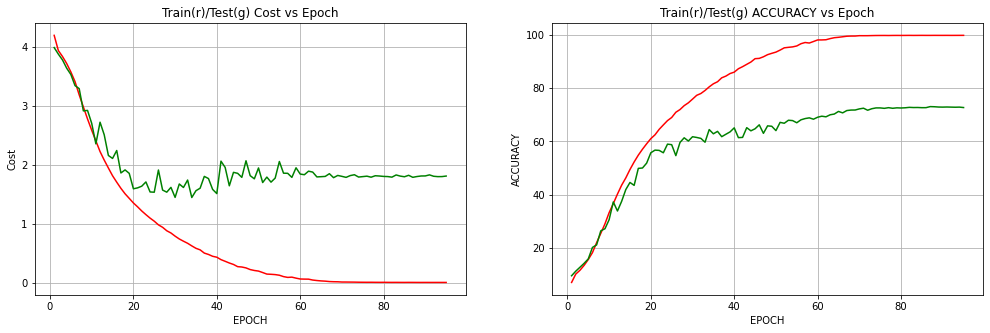

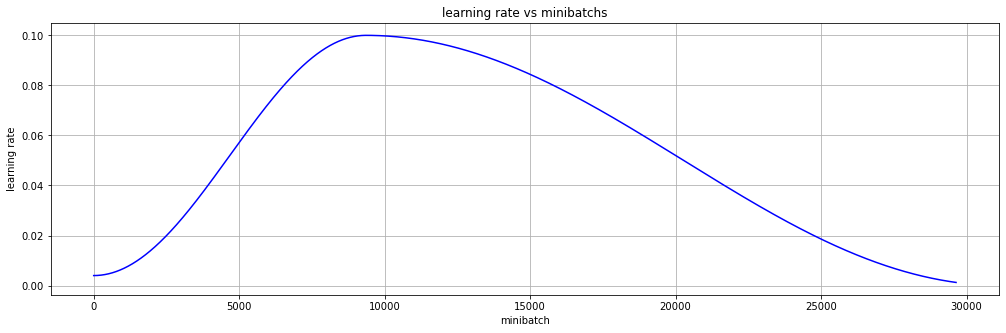

----------------train----------------
Epoch:96/100 batch_idx:103 Train Cost:0.001244
Epoch:96/100 batch_idx:207 Train Cost:0.001462
Epoch:96/100 batch_idx:311 Train Cost:0.001620
Epoch:96/100 batch_idx:311 Train Accuracy:99.810000
----------------test----------------
Epoch:96/100 Test Cost:1.821547 Test Accuracy:72.8000


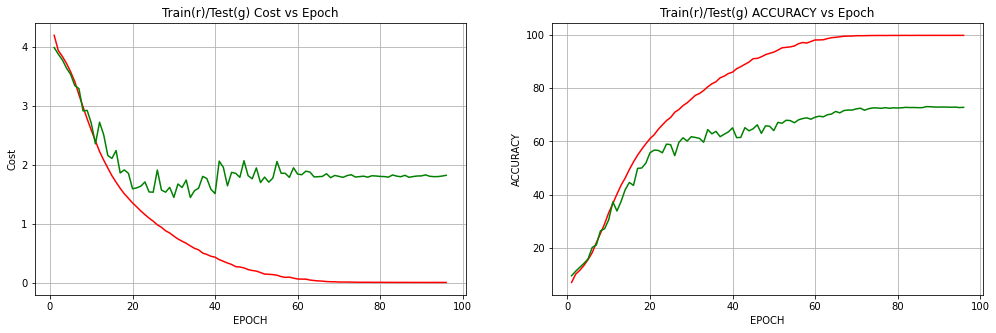

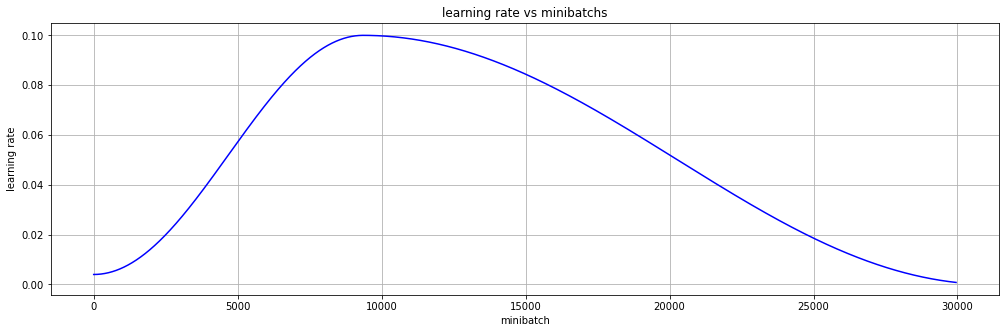

----------------train----------------
Epoch:97/100 batch_idx:103 Train Cost:0.001619
Epoch:97/100 batch_idx:207 Train Cost:0.001660
Epoch:97/100 batch_idx:311 Train Cost:0.001588
Epoch:97/100 batch_idx:311 Train Accuracy:99.820000
----------------test----------------
Epoch:97/100 Test Cost:1.808826 Test Accuracy:72.8300


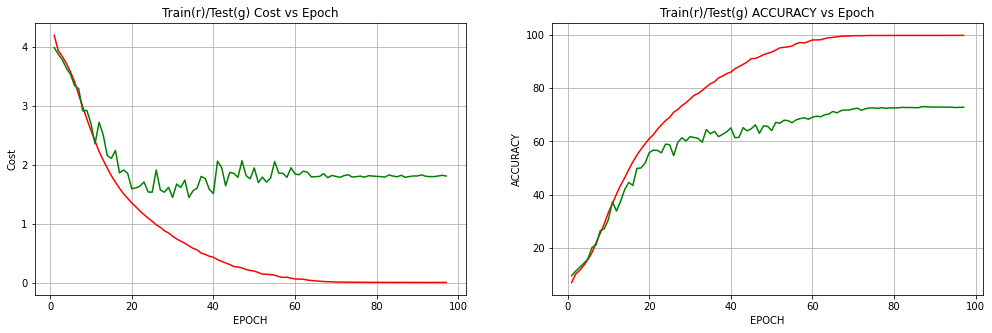

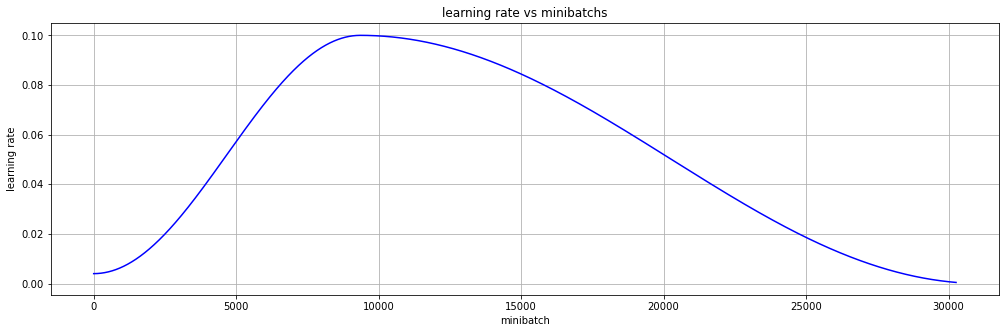

----------------train----------------
Epoch:98/100 batch_idx:103 Train Cost:0.001284
Epoch:98/100 batch_idx:207 Train Cost:0.001394
Epoch:98/100 batch_idx:311 Train Cost:0.001479
Epoch:98/100 batch_idx:311 Train Accuracy:99.820000
----------------test----------------
Epoch:98/100 Test Cost:1.798239 Test Accuracy:72.9000


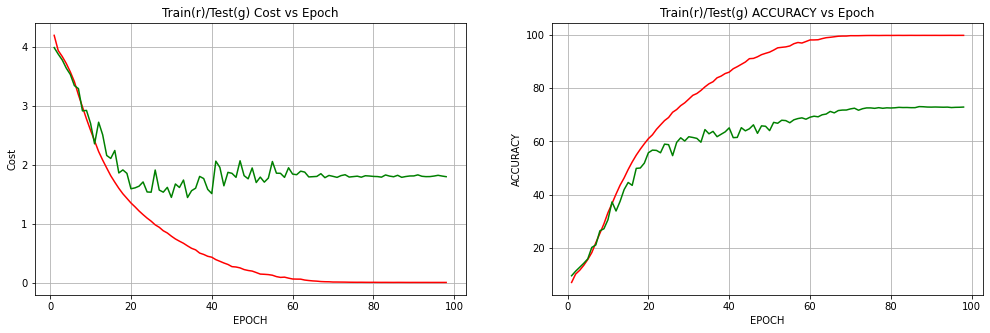

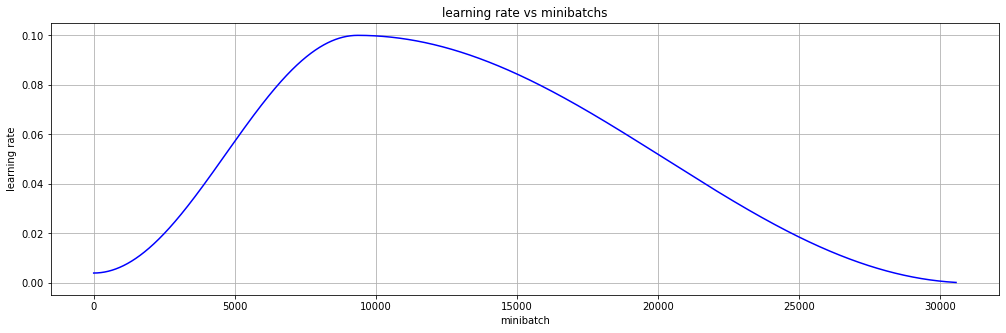

----------------train----------------
Epoch:99/100 batch_idx:103 Train Cost:0.001714
Epoch:99/100 batch_idx:207 Train Cost:0.001517
Epoch:99/100 batch_idx:311 Train Cost:0.001566
Epoch:99/100 batch_idx:311 Train Accuracy:99.818000
----------------test----------------
Epoch:99/100 Test Cost:1.808530 Test Accuracy:72.8000


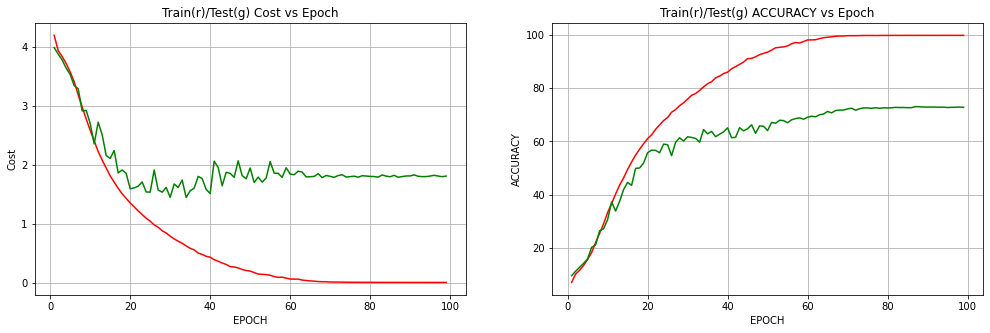

----------------train----------------
Epoch:100/100 batch_idx:103 Train Cost:0.001384
Epoch:100/100 batch_idx:207 Train Cost:0.001315
Epoch:100/100 batch_idx:311 Train Cost:0.001539
Epoch:100/100 batch_idx:311 Train Accuracy:99.820000
----------------test----------------
Epoch:100/100 Test Cost:1.815933 Test Accuracy:72.8000


In [17]:
#clear GPU cache
for _ in range(5):
    gc.collect()
    torch.cuda.empty_cache()

DEVICE = 'cuda:0' #smi0
LEARNING_RATE = 0.1
TRAIN_EPOCHS = 100
initial_conv = 64
layer = [3,5,2] 
channels = [128, 256, 512]

model = ResNet(BasicBlock, initial_conv, layer, channels, 100, True).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=(len(train_data_loader)*10), gamma=0.9)
lr_sche = optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=TRAIN_EPOCHS, steps_per_epoch=len(train_data_loader))
#lr_sche = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8*len(train_data_loader), eta_min=0.001) #CyclicLR mode:'triangular', 'triangular2', 'exp_range'(needs gamma) 
#lr_sche = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, step_size_up=5, max_lr=0.05, gamma=0.5, mode='exp_range', cycle_momentum=False, base_momentum = 0.8, max_momentum=0.9) 
#lr_sche = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, step_size_up = (TRAIN_EPOCHS//8)*len(train_data_loader), max_lr=0.05, mode='triangular2', cycle_momentum=True, base_momentum = 0.8, max_momentum=0.9)

creterion = nn.CrossEntropyLoss().to(DEVICE)
train_cost_arr = []
train_accu_arr = []
test_cost_arr = []
test_accu_arr = []
x_array = []
lr_array = []
str_layer = '|'.join(map(str, layer))
str_channels = '|'.join(map(str, channels))

for epoch in range(TRAIN_EPOCHS):
    x_array.append(epoch + 1)
    train_cost_sum = 0
    test_cost_avg = 0

    model.train()
    train_model(model, epoch+1, train_data_loader, optimizer, lr_sche, creterion, train_cost_arr,train_accu_arr, lr_array)
    
    model.eval()
    _, test_accuracy = test_model(model, epoch+1, test_data_loader, creterion, test_cost_arr, test_accu_arr)

    
    plt.subplot(1,2,1)
    plt.plot(x_array, train_cost_arr, 'r', label='train cost')
    plt.plot(x_array, test_cost_arr, 'g', label='test cost')
    plt.xlabel('EPOCH')
    plt.ylabel('Cost')
    plt.title('Train(r)/Test(g) Cost vs Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(x_array, train_accu_arr, 'r', label='train accu')
    plt.plot(x_array, test_accu_arr, 'g', label='test accu')
    plt.xlabel('EPOCH')
    plt.ylabel('ACCURACY')
    plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
    
    plt.rcParams["figure.figsize"] = (17,5)
    plt.rcParams['axes.grid'] = True 
    #plt.tight_layout()
    plt.show()

    plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
    plt.xlabel('minibatch')
    plt.ylabel('learning rate')
    plt.title('learning rate vs minibatchs')
    plt.show()

torch.save(model, './trained_models/resnet{}_epoch{}_ly{}_ch{}_accu_L|M{:2.2f}|{:2.2f}.pt'.format((sum(layer)*2 + 2),TRAIN_EPOCHS, str_layer, str_channels, test_accu_arr[-1], max(test_accu_arr)))


Text(0.5, 1.0, 'learning rate vs minibatchs')

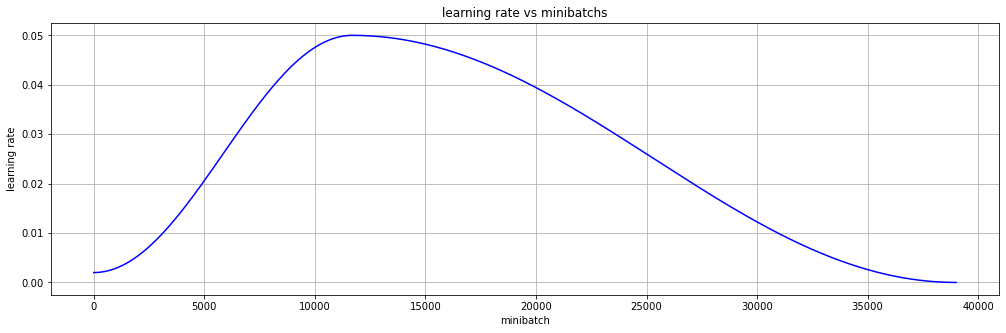

In [ ]:
plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
plt.xlabel('minibatch')
plt.ylabel('learning rate')
plt.title('learning rate vs minibatchs')

In [ ]:
test_accu_arr[-1]

<h4><u><b> save model

In [53]:
torch.save(model, './trained_models/resnet{}_epoch{}_ly{}_ch{}_accu_L|M{:2.2f}|{:2.2f}.pt'.format((sum(layer)*3 + 2),TRAIN_EPOCHS, str_layer, str_channels, test_accu_arr[-1], max(test_accu_arr)))

<h4><b><u> load model

In [34]:
loaded_model = torch.load('./trained_models/___modelname___.pt')

<h4><b><u>2Blocks for simultenious Record of test cost vs epoch

In [51]:
def test_model_for_result(_model, _epoch, _test_data_loader, _creterion, _array):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(test_data_loader)

    _array.append(test_cost_avg)
    accuracy = corrects.item() / len(test_data) * 100

    return test_cost_avg, accuracy

In [52]:
creterion = nn.CrossEntropyLoss().to(DEVICE)

model.eval()
test_cost, test_accuracy = test_model_for_result(model, epoch, test_data_loader, creterion, test_cost_arr)
print('Test Cost: ', test_cost, '\nTest Accuracy', test_accuracy)

----------------test----------------
Test Cost:  1.8344939026651508 
Test Accuracy 71.17


<h4><u><b> load and test model

In [41]:
model_loaded1 = torch.load('./trained_models/resnet_epoch100_83.265.pt')
model_loaded1.to(DEVICE)

model.eval()
test_cost, test_accuracy = test_model_for_result(model_loaded1, epoch, test_data_loader, creterion, test_cost_arr)
print('Test Cost: ', test_cost, '\nTest Accuracy', test_accuracy)

----------------test----------------
Test Cost:  2.2392252336574514 
Test Accuracy 65.77


<h3> <u> <b> Clear GPU

In [33]:
import gc
for _ in range(5):
    gc.collect()
    torch.cuda.empty_cache()